# Diffusion‑Transformer Mechanistic Interpretation


## 0. Dependencies

In [ ]:
!pip install -q torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
!pip install -q einops tqdm scikit-learn matplotlib seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 780.5/780.5 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 48.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 110.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 19.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 42.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.5/209.5 MB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━

0. Imports & utilities

In [ ]:
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import numpy as np, math, random, tqdm, copy, itertools
from einops import rearrange
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt, seaborn as sns
sns.set(context="talk")
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using", device)

Using cuda


0. Dataset generator  – Tier 0 Brownian bridge

In [ ]:
def gen_brownian(n=20_000):
    x = np.random.randn(n, 1).astype("float32")
    a = np.roll(x, -1, axis=0) - x                # Δx_t
    return torch.tensor(x), torch.tensor(a)

train_x, train_a = gen_brownian(20_000)
test_x,  test_a  = gen_brownian(2_048)

0. Tiny "DiT" residual MLP

In [ ]:
class TinyDiT(nn.Module):
    def __init__(self, width=32, depth=4):
        super().__init__()
        self.in_proj  = nn.Linear(1, width)
        self.blocks   = nn.ModuleList([
            nn.Sequential(
                nn.LayerNorm(width),
                nn.Linear(width, width*4),
                nn.GELU(),
                nn.Linear(width*4, width)
            ) for _ in range(depth)
        ])
        self.out_proj = nn.Linear(width, 1)

    def forward(self, x, return_acts=False):
        h  = self.in_proj(x)
        hs = [h]                            # store residual stream for probes
        for blk in self.blocks:
            h = h + blk(h)
            hs.append(h)
        out = self.out_proj(h)
        return (out, hs) if return_acts else out

0. Generic train loop – returns trained model *and* weight log per epoch

In [ ]:
def train(model, x, a, epochs=10, lr=3e-3, bs=512, log_spectra=False):
    opt     = torch.optim.AdamW(model.parameters(), lr=lr)
    loader  = DataLoader(TensorDataset(x, a), bs, shuffle=True)
    logs    = {"loss":[], "spec":[]}
    for ep in range(epochs):
        running = 0.
        for s,b in loader:
            s,b = s.to(device), b.to(device)
            pred = model(s)
            loss = F.mse_loss(pred, b)
            opt.zero_grad(); loss.backward(); opt.step()
            running += loss.item() * len(s)
        epoch_loss = running/len(x)
        logs["loss"].append(epoch_loss)
        print(f"epoch {ep+1:02d}  mse {epoch_loss:.5f}")
        if log_spectra:
            # keep singular value of first residual weight
            W = model.blocks[0][1].weight.detach().cpu().numpy()      # (w*4,w)
            sv = np.linalg.svd(W, compute_uv=False)
            logs["spec"].append(sv)
    return logs

0. Analytic baseline Ground‑truth E[Δx | x] = 0

In [ ]:
def analytic_baseline():
    zero_pred   = torch.zeros_like(test_a)
    mse         = F.mse_loss(zero_pred, test_a).item()
    print(f"[Baseline] Always‑zero MSE  = {mse:.5f}")
analytic_baseline()

[Baseline] Always‑zero MSE  = 2.06270


0. Train reference model & watch weights drift toward identity

epoch 01  mse 1.11170
epoch 02  mse 1.01567
epoch 03  mse 1.01787
epoch 04  mse 1.01017
epoch 05  mse 1.01331
epoch 06  mse 1.01209
epoch 07  mse 1.01169
epoch 08  mse 1.01668
epoch 09  mse 1.01188
epoch 10  mse 1.01277
epoch 11  mse 1.01314
epoch 12  mse 1.01333
epoch 13  mse 1.01618
epoch 14  mse 1.01099
epoch 15  mse 1.01075
epoch 16  mse 1.01124
epoch 17  mse 1.01321
epoch 18  mse 1.01150
epoch 19  mse 1.01370
epoch 20  mse 1.01056
epoch 21  mse 1.00921
epoch 22  mse 1.01166
epoch 23  mse 1.01339
epoch 24  mse 1.01303
epoch 25  mse 1.01200
epoch 26  mse 1.01475
epoch 27  mse 1.01179
epoch 28  mse 1.01105
epoch 29  mse 1.01014
epoch 30  mse 1.01010
epoch 31  mse 1.01110
epoch 32  mse 1.01175
epoch 33  mse 1.01118
epoch 34  mse 1.01164
epoch 35  mse 1.01061
epoch 36  mse 1.01155
epoch 37  mse 1.01123
epoch 38  mse 1.01173
epoch 39  mse 1.01108
epoch 40  mse 1.00956
epoch 41  mse 1.01210
epoch 42  mse 1.00954
epoch 43  mse 1.01033
epoch 44  mse 1.00941
epoch 45  mse 1.00994
epoch 46  

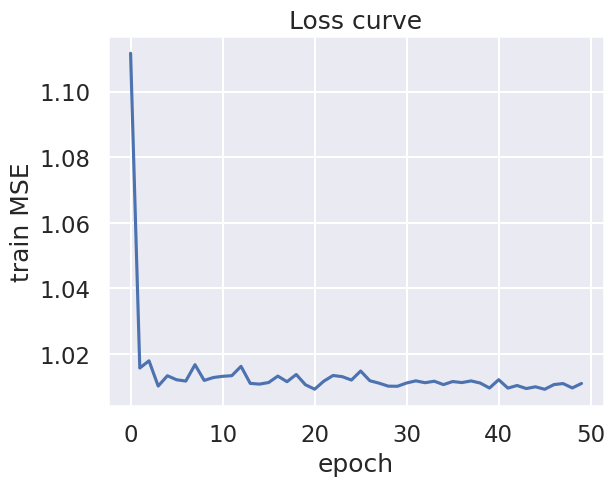

block 0 residual weight Frobenius norm: 6.4633
block 1 residual weight Frobenius norm: 6.6292
block 2 residual weight Frobenius norm: 6.6960
block 3 residual weight Frobenius norm: 6.3848


In [ ]:
model = TinyDiT(width=32, depth=4).to(device)
logs  = train(model, train_x, train_a, epochs=50, log_spectra=True)

# show loss curve
plt.figure(); plt.plot(logs["loss"]); plt.xlabel("epoch"); plt.ylabel("train MSE"); plt.title("Loss curve"); plt.show()

# inspect weight norms per block each epoch
with torch.no_grad():
    for i,blk in enumerate(model.blocks):
        W = blk[1].weight
        print(f"block {i} residual weight Frobenius norm: {W.norm().item():.4f}")

0. Linear probes on hidden activations

In [ ]:
def run_linear_probes(model):
    model.eval()
    with torch.no_grad():
        _, acts = model(test_x.to(device), return_acts=True)   # list len depth+1
    acts = [h.cpu().numpy() for h in acts]                     # each (N,w)
    x_np, a_np = test_x.numpy(), test_a.numpy()
    for layer,h in enumerate(acts):
        reg_in  = LinearRegression().fit(h, x_np)
        reg_out = LinearRegression().fit(h, a_np)
        r2_in, r2_out = reg_in.score(h, x_np), reg_out.score(h, a_np)
        print(f"Layer {layer:02d}: R²(h→x)={r2_in:.3f},  R²(h→Δx)={r2_out:.3f}")
run_linear_probes(model)

Layer 00: R²(h→x)=1.000,  R²(h→Δx)=0.507
Layer 01: R²(h→x)=1.000,  R²(h→Δx)=0.508
Layer 02: R²(h→x)=1.000,  R²(h→Δx)=0.508
Layer 03: R²(h→x)=1.000,  R²(h→Δx)=0.509
Layer 04: R²(h→x)=1.000,  R²(h→Δx)=0.509


0. Activation ablation / patching

In [ ]:
def ablation_demo(model, neuron_idx=0):
    model.eval()
    sample = test_x[:10].to(device)
    with torch.no_grad():
        # full output
        full = model(sample).cpu()
        # patched: zero chosen neuron in *all* residual layers
        def hook(_, inp, out):
            out[:, neuron_idx] = 0
        handles = [blk.register_forward_hook(hook) for blk in model.blocks]
        patched = model(sample).cpu()
        for h in handles: h.remove()
    delta = (patched - full).abs().mean()
    print(f"Ablating neuron {neuron_idx} changes mean|Δ| by {delta.item():.6f}")
ablation_demo(model, neuron_idx=5)

Ablating neuron 5 changes mean|Δ| by 0.003013


0. Capacity vs memorisation curve

epoch 01  mse 1.79282
epoch 02  mse 1.28062
epoch 03  mse 1.13253
epoch 04  mse 1.11022
epoch 05  mse 1.08795
epoch 01  mse 2.31200
epoch 02  mse 1.27790
epoch 03  mse 1.09668
epoch 04  mse 1.03869
epoch 05  mse 1.02355
epoch 01  mse 1.44184
epoch 02  mse 1.06325
epoch 03  mse 1.02186
epoch 04  mse 1.01535
epoch 05  mse 1.01257
epoch 01  mse 1.07859
epoch 02  mse 1.02076
epoch 03  mse 1.01206
epoch 04  mse 1.01170
epoch 05  mse 1.01090
epoch 01  mse 1.19384
epoch 02  mse 1.01685
epoch 03  mse 1.01207
epoch 04  mse 1.01053
epoch 05  mse 1.01118
epoch 01  mse 1.29632
epoch 02  mse 1.02508
epoch 03  mse 1.02702
epoch 04  mse 1.01838
epoch 05  mse 1.01298


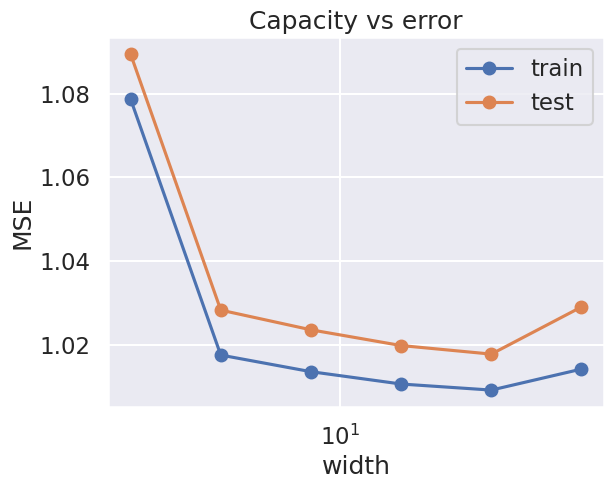

In [ ]:
def capacity_sweep(widths=[2,4,8,16,32,64], epochs=5):
    results = []
    for w in widths:
        m = TinyDiT(width=w, depth=4).to(device)
        train(m, train_x, train_a, epochs=epochs, lr=3e-3, bs=1024)
        with torch.no_grad():
            train_mse = F.mse_loss(m(train_x.to(device)), train_a.to(device)).item()
            test_mse  = F.mse_loss(m(test_x.to(device)),  test_a.to(device)).item()
        results.append((w, train_mse, test_mse))
    # plot
    ws, tr, te = zip(*results)
    plt.figure(); plt.plot(ws, tr, "o-", label="train"); plt.plot(ws, te, "o-", label="test")
    plt.xscale("log"); plt.xlabel("width"); plt.ylabel("MSE"); plt.title("Capacity vs error"); plt.legend(); plt.show()
capacity_sweep()

0. Weight‑symmetry breaking

In [ ]:
def symmetry_breaking(width=16, epochs=7):
    seeds = [0,1]
    outs  = []
    for sd in seeds:
        torch.manual_seed(sd); np.random.seed(sd); random.seed(sd)
        m = TinyDiT(width=width, depth=4).to(device)
        # one extra sign flip on first layer weight for seed 1
        if sd==1:
            with torch.no_grad(): m.in_proj.weight.mul_(-1)
        train(m, train_x, train_a, epochs=epochs, lr=3e-3, bs=512)
        outs.append(m(test_x.to(device)).cpu().detach().numpy())
    corr = np.corrcoef(outs[0].flatten(), outs[1].flatten())[0,1]
    print(f"Output correlation between near‑identical inits: {corr:.3f}")
symmetry_breaking()

epoch 01  mse 1.06787
epoch 02  mse 1.01532
epoch 03  mse 1.01335
epoch 04  mse 1.01508
epoch 05  mse 1.01619
epoch 06  mse 1.01255
epoch 07  mse 1.01111
epoch 01  mse 1.15425
epoch 02  mse 1.01733
epoch 03  mse 1.01387
epoch 04  mse 1.01542
epoch 05  mse 1.01273
epoch 06  mse 1.01522
epoch 07  mse 1.02704
Output correlation between near‑identical inits: 1.000


0. Spectral growth (SVD) Already logged during training earlier – visualise

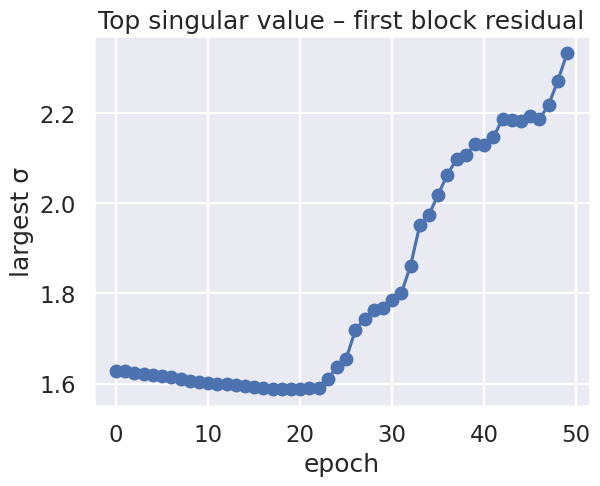

In [ ]:
spec = np.array(logs["spec"])           # shape (epochs, rank)
plt.figure(); plt.plot(spec[:,0], "o-"); plt.xlabel("epoch"); plt.ylabel("largest σ"); plt.title("Top singular value – first block residual"); plt.show()

1. Runtime & dependencies

In [ ]:
!pip install -q torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
!pip install -q einops tqdm scikit-learn matplotlib seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 780.5/780.5 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 103.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 54.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 115.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 20.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 44.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.5/209.5 MB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━

1. Imports & utilities

In [ ]:
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import numpy as np, random, tqdm, math, copy, itertools
from einops import rearrange
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt, seaborn as sns
sns.set(context="talk")

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on", device)

Running on cuda


1. Dataset – Tier 1 Reacher:  state = (x,y,x*,y*),  action = k·(goal − pos)

In [ ]:
def gen_reacher(n=60_000, k=0.5, rng=None):
    """
    n     – #samples
    k     – proportional-gain of the ground-truth controller
    rng   – np.random.Generator for reproducibility
    """
    rng = rng or np.random.default_rng()
    pos   = rng.uniform(-1, 1, size=(n, 2)).astype("float32")
    goal  = rng.uniform(-1, 1, size=(n, 2)).astype("float32")
    state = np.concatenate([pos, goal], axis=1)          # (x,y,x*,y*)
    act   = k * (goal - pos)                             # Δ(x,y)
    return torch.from_numpy(state), torch.from_numpy(act)

train_s, train_a = gen_reacher(60_000)
test_s,  test_a  = gen_reacher(4_096)
print("train", train_s.shape, train_a.shape)

train torch.Size([60000, 4]) torch.Size([60000, 2])


1. Tiny DiT residual MLP  (no attention, but DiT‑style residual stack)

In [ ]:
class TinyDiT(nn.Module):
    def __init__(self, state_dim=4, action_dim=2, width=64, depth=4):
        super().__init__()
        self.in_proj  = nn.Linear(state_dim, width)
        self.blocks   = nn.ModuleList([
            nn.Sequential(
                nn.LayerNorm(width),
                nn.Linear(width, width*4),
                nn.GELU(),
                nn.Linear(width*4, width)
            ) for _ in range(depth)
        ])
        self.out_proj = nn.Linear(width, action_dim)

    def forward(self, x, return_acts=False):
        h  = self.in_proj(x)
        hs = [h]                                  # residual stream snapshots
        for blk in self.blocks:
            h = h + blk(h)
            hs.append(h)
        out = self.out_proj(h)
        return (out, hs) if return_acts else out

1. Training helper

In [ ]:
def train(model, s, a, epochs=15, lr=3e-3, bs=512, log_loss=False):
    ds     = TensorDataset(s, a)
    loader = DataLoader(ds, bs, shuffle=True)
    opt    = torch.optim.AdamW(model.parameters(), lr=lr)
    curve  = []
    for ep in range(epochs):
        running = 0.
        for batch_s, batch_a in tqdm.tqdm(loader, desc=f"Epoch {ep+1}/{epochs}", leave=False):
            batch_s, batch_a = batch_s.to(device), batch_a.to(device)
            pred = model(batch_s)
            loss = F.mse_loss(pred, batch_a)
            opt.zero_grad(); loss.backward(); opt.step()
            running += loss.item() * len(batch_s)
        epoch_mse = running / len(ds)
        curve.append(epoch_mse)
        if log_loss:
            print(f"epoch {ep+1:02d}  MSE {epoch_mse:.5f}")
    return curve

1. Analytic baseline   (ground‑truth PD controller)

In [ ]:
def analytic_baseline(s):
    pos, goal = s[:, :2], s[:, 2:]
    return 0.5 * (goal - pos)                       # k = 0.5

with torch.no_grad():
    base_pred = analytic_baseline(test_s)
    base_mse  = F.mse_loss(base_pred, test_a).item()
print(f"[Baseline – PD] MSE = {base_mse:.5f}")

[Baseline – PD] MSE = 0.00000


Train reference model & inspect

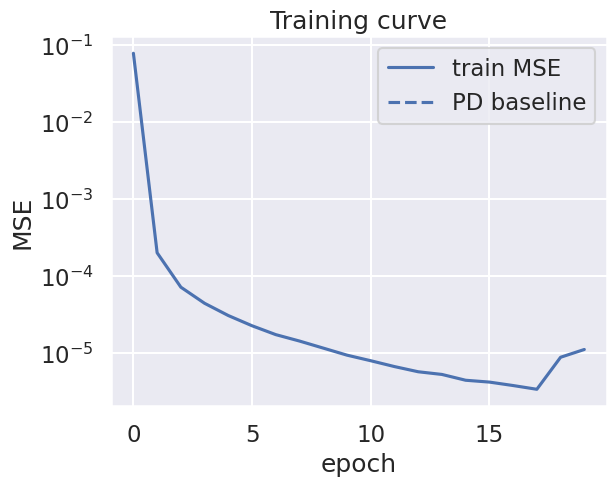

block 0 weight F‑norm = 9.1172
block 1 weight F‑norm = 9.0030
block 2 weight F‑norm = 8.9815
block 3 weight F‑norm = 9.0130


In [ ]:
model = TinyDiT().to(device)
loss_curve = train(model, train_s, train_a, epochs=20, lr=3e-3, bs=1024)

plt.figure(); plt.plot(loss_curve, label="train MSE"); plt.axhline(base_mse, ls="--", label="PD baseline"); plt.yscale("log"); plt.legend(); plt.title("Training curve"); plt.xlabel("epoch"); plt.ylabel("MSE"); plt.show()

# weight norms per residual block
with torch.no_grad():
    for i,blk in enumerate(model.blocks):
        print(f"block {i} weight F‑norm = {blk[1].weight.norm():.4f}")

Linear probes   (does a layer linearly encode  Δ or  |Δ| ?)

In [ ]:
def run_probes(model):
    model.eval()
    with torch.no_grad():
        _, acts = model(test_s.to(device), return_acts=True)  # length = depth+1
    acts = [h.cpu().numpy() for h in acts]
    diff = (test_s[:, 2:] - test_s[:, :2]).numpy()            # goal − pos
    dist = np.linalg.norm(diff, axis=1, keepdims=True)
    for layer,h in enumerate(acts):
        r2_diff = LinearRegression().fit(h, diff).score(h, diff)
        r2_dist = LinearRegression().fit(h, dist).score(h, dist)
        print(f"Layer {layer:02d}  R²(h→Δ)={r2_diff:.3f}   R²(h→|Δ|)={r2_dist:.3f}")
run_probes(model)

Layer 00  R²(h→Δ)=1.000   R²(h→|Δ|)=0.001
Layer 01  R²(h→Δ)=1.000   R²(h→|Δ|)=0.978
Layer 02  R²(h→Δ)=1.000   R²(h→|Δ|)=0.980
Layer 03  R²(h→Δ)=1.000   R²(h→|Δ|)=0.978
Layer 04  R²(h→Δ)=1.000   R²(h→|Δ|)=0.980


Activation ablation / patching

In [ ]:
def ablate_neuron(model, neuron=0):
    model.eval()
    sample = test_s[:32].to(device)
    with torch.no_grad():
        full = model(sample).cpu()
        # ablate chosen neuron in ALL residual blocks
        handles = []
        def hook(_, __, out):
            out[:, neuron] = 0
        for blk in model.blocks:
            handles.append(blk.register_forward_hook(hook))
        patched = model(sample).cpu()
        for h in handles: h.remove()
    delta = (patched - full).norm(dim=1).mean()
    print(f"Ablating neuron {neuron} changes mean‖Δ‖ by {delta:.4f}")
ablate_neuron(model, neuron=3)

Ablating neuron 3 changes mean‖Δ‖ by 0.0094


Capacity sweep  (width → generalisation curve)

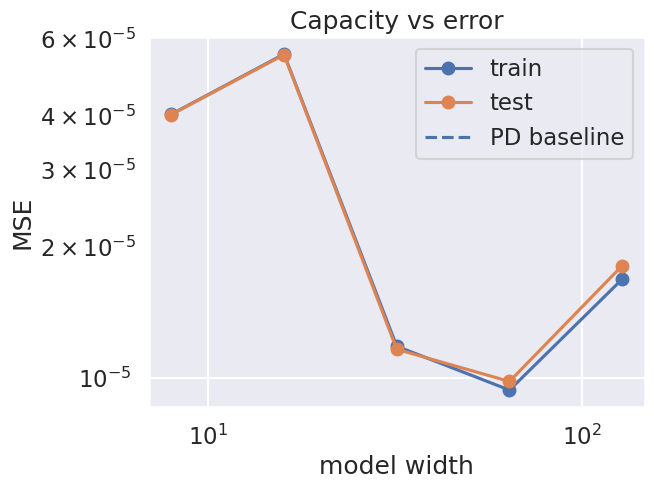

In [ ]:
def capacity_sweep(widths=[8,16,32,64,128], epochs=8):
    results = []
    for w in widths:
        m = TinyDiT(width=w).to(device)
        train(m, train_s, train_a, epochs=epochs, lr=3e-3, bs=1024)
        with torch.no_grad():
            tr_mse = F.mse_loss(m(train_s.to(device)), train_a.to(device)).item()
            te_mse = F.mse_loss(m(test_s .to(device)), test_a .to(device)).item()
        results.append((w,tr_mse,te_mse))
    ws, tr, te = zip(*results)
    plt.figure(); plt.plot(ws,tr,"o-",label="train"); plt.plot(ws,te,"o-",label="test");
    plt.axhline(base_mse, ls="--", label="PD baseline");
    plt.xscale("log"); plt.yscale("log")
    plt.xlabel("model width"); plt.ylabel("MSE"); plt.title("Capacity vs error"); plt.legend(); plt.show()
capacity_sweep()

Symmetry‑breaking demo

In [ ]:
def symmetry_break(width=64, epochs=10):
    outs = []
    for flip in [False, True]:
        torch.manual_seed(0); np.random.seed(0); random.seed(0)
        m = TinyDiT(width=width).to(device)
        if flip:
            with torch.no_grad():
                m.in_proj.weight.mul_(-1)           # sign‑flip symmetry
        train(m, train_s, train_a, epochs=epochs, lr=3e-3, bs=1024)
        outs.append(m(test_s.to(device)).cpu().detach().numpy())
    corr = np.corrcoef(outs[0].flatten(), outs[1].flatten())[0,1]
    print(f"Output corr (seed vs sign‑flipped) = {corr:.3f}")
symmetry_break()

Output corr (seed vs sign‑flipped) = 1.000


Vector‑field visual (quick sanity check)

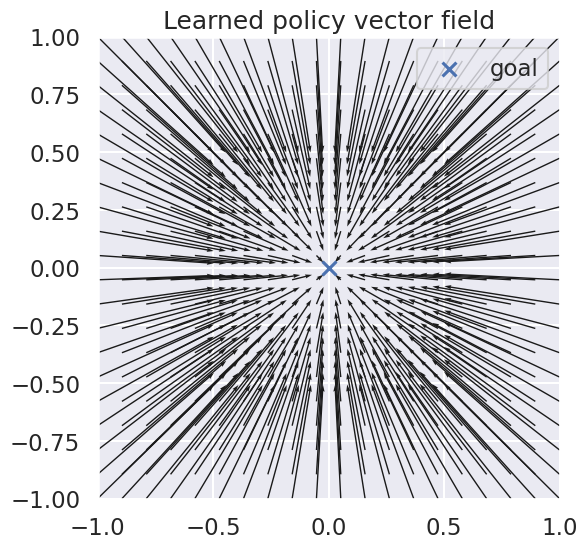

In [ ]:
def quiver_demo(model, steps=20):
    # build a grid in XY, set goal at (0,0) to visualise arrows
    xs = np.linspace(-1,1,steps)
    grid = np.stack(list(itertools.product(xs,xs)), axis=0).astype("float32")
    goals = np.zeros_like(grid)                           # (0,0) goal
    state = torch.from_numpy(np.concatenate([grid, goals], axis=1))
    with torch.no_grad():
        pred = model(state.to(device)).cpu().numpy()
    plt.figure(figsize=(6,6));
    plt.quiver(grid[:,0], grid[:,1], pred[:,0], pred[:,1], angles='xy', scale_units='xy', scale=1)
    plt.scatter(0,0, marker='x', s=100, label="goal");
    plt.xlim(-1,1); plt.ylim(-1,1); plt.gca().set_aspect('equal'); plt.title("Learned policy vector field"); plt.legend(); plt.show()
quiver_demo(model)

  target    R²(PC1)   R²(PC2)
Δx         0.015     0.006
Δy         0.016     0.775
‖Δ‖        0.000     0.001


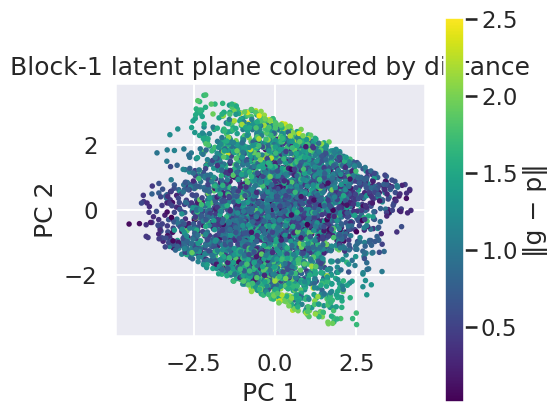

In [ ]:
import numpy as np, torch, matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression

# ---------------- 1. get activations after block‑1 --------------------
model.eval()
with torch.no_grad():
    _, acts = model(test_s.to(device), return_acts=True)  # len = depth+1
h = acts[0].cpu().numpy()          # post‑block‑1  (N , width)

# ---------------- 2. build geometric targets -------------------------
diff  = (test_s[:,2:] - test_s[:,:2]).numpy()      # (N,2)
dist  = np.linalg.norm(diff, axis=1, keepdims=True)# (N,1)

# ---------------- 3. run PCA  (whiten=False keeps original scaling) ---
pca   = PCA(n_components=2)
Z     = pca.fit_transform(h)       # (N,2)   columns = PC1, PC2

# ---------------- 4. correlation / R² table ---------------------------
targets = {"Δx":diff[:,0:1], "Δy":diff[:,1:2], "‖Δ‖":dist}
print("  target    R²(PC1)   R²(PC2)")
for name,y in targets.items():
    r2_1 = LinearRegression().fit(Z[:,0:1], y).score(Z[:,0:1], y)
    r2_2 = LinearRegression().fit(Z[:,1:2], y).score(Z[:,1:2], y)
    print(f"{name:6s}   {r2_1:7.3f}   {r2_2:7.3f}")

# ---------------- 5. visualise latent plane ---------------------------
plt.figure(figsize=(5,5))
sc = plt.scatter(Z[:,0], Z[:,1], c=dist.flatten(), cmap="viridis", s=6)
plt.xlabel("PC 1"); plt.ylabel("PC 2"); plt.gca().set_aspect('equal')
cbar = plt.colorbar(sc); cbar.set_label("‖g − p‖")
plt.title("Block‑1 latent plane coloured by distance"); plt.show()

Distance neuron index = 63,   corr = 0.1703


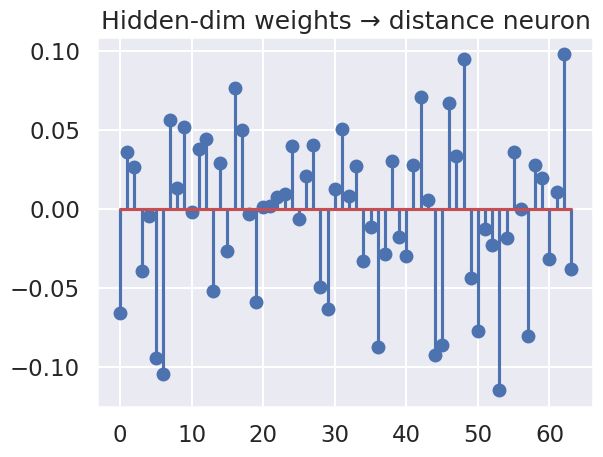

Effective weights on raw tokens [x, y, x*, y*] : [ 0.099 -0.212 -0.162  0.037]


In [ ]:
import numpy as np, torch, matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# -------------------------------------------------
# 1. capture activations after *second* residual block
#    acts[0] = post‑input, acts[1] = post‑block‑0,
#    acts[2] = post‑block‑1   <-- distance appears here
# -------------------------------------------------
model.eval()
with torch.no_grad():
    _, acts = model(test_s.to(device), return_acts=True)

h = acts[2].cpu().numpy()               # shape (N, width)

# -------------------------------------------------
# 2. compute Euclidean distance  ‖goal‑pos ‖
# -------------------------------------------------
diff = (test_s[:, 2:] - test_s[:, :2]).numpy()
dist = np.linalg.norm(diff, axis=1, keepdims=True)

# -------------------------------------------------
# 3. neuron with strongest correlation to distance
# -------------------------------------------------
corrs = np.corrcoef(h.T, dist.flatten())[-1, :-1]
idx   = np.argmax(np.abs(corrs))
print(f"Distance neuron index = {idx},   corr = {corrs[idx]:.4f}")

# -------------------------------------------------
# 4. weight pathway back to raw inputs
# -------------------------------------------------
blk = model.blocks[1]                  # block‑1 (index 1)

# weights:  LayerNorm → Linear1 (width→4*width) → GELU → Linear2 (4*width→width)
W1 = blk[1].weight.detach().cpu().numpy()        # (4w, w)
W2 = blk[3].weight.detach().cpu().numpy()        # (w, 4w)
row = W2[idx]                                    # (4w,)

proj_hidden = W1.T @ row                         # (w,)
# plot contribution of each hidden dim
plt.figure(); plt.stem(proj_hidden); plt.title("Hidden‑dim weights → distance neuron"); plt.show()

# project all the way to raw inputs
W_in  = model.in_proj.weight.detach().cpu().numpy()   # (w,4)
raw_coeff = proj_hidden @ W_in                        # (4,)
print("Effective weights on raw tokens [x, y, x*, y*] :",
      np.round(raw_coeff, 3))

In [ ]:
# build a linear regressor on the SAME activations h (after block 1)
reg = LinearRegression().fit(h, dist)
print("R² full‑decoder =", reg.score(h, dist))        # should print ~0.98

# take its weight vector and project back to raw inputs
decoder = reg.coef_.flatten()            # (width,)
raw_w   = decoder @ model.in_proj.weight.detach().cpu().numpy()  # (4,)

print("Linear‑decoder weights on raw [x,y,x*,y*]:", np.round(raw_w, 3))

R² full‑decoder = 0.9800378680229187
Linear‑decoder weights on raw [x,y,x*,y*]: [ 0.576  1.512 -0.09   0.382]


In [ ]:
# ---------- 1. make a random 2‑D rotation matrix -----------------------
theta = np.random.uniform(0, 2*np.pi)
R = np.array([[np.cos(theta), -np.sin(theta)],
              [np.sin(theta),  np.cos(theta)]], dtype="float32")

def gen_reacher_rot(n=60_000, k=0.5, R=R, rng=None):
    rng = rng or np.random.default_rng()
    pos  = rng.uniform(-1, 1, size=(n, 2)).astype("float32")
    goal = rng.uniform(-1, 1, size=(n, 2)).astype("float32")
    pos_rot  = (R @ pos.T ).T
    goal_rot = (R @ goal.T).T
    state = np.concatenate([pos_rot, goal_rot], axis=1)
    act   = k * (goal_rot - pos_rot)
    return torch.tensor(state), torch.tensor(act)

# ---------- 2. regenerate data & train fresh network -------------------
train_r, train_a_r = gen_reacher_rot(60_000)
test_r,  test_a_r  = gen_reacher_rot(4_096)

net_rot = TinyDiT().to(device)
_ = train(net_rot, train_r, train_a_r, epochs=15, lr=3e-3, bs=1024)

# ---------- 3. probe the rotated network for a new distance neuron -----
net_rot.eval()
with torch.no_grad():
    _, acts_r = net_rot(test_r.to(device), return_acts=True)
h1_r = acts_r[1].cpu().numpy()
diff_r = (test_r[:,2:] - test_r[:,:2]).numpy()
dist_r = np.linalg.norm(diff_r, axis=1, keepdims=True)

corrs_r = np.corrcoef(h1_r.T, dist_r.flatten())[-1,:-1]
idx_r = np.argmax(np.abs(corrs_r))
print(f"[Rotated] top distance neuron idx = {idx_r},  corr = {corrs_r[idx_r]:.4f}")

[Rotated] top distance neuron idx = 21,  corr = 0.1756


In [ ]:
from sklearn.linear_model import LinearRegression

# hidden activations after first residual block
h = h1_r
reg = LinearRegression().fit(h, dist_r)
print("R² (all neurons → distance) =", reg.score(h, dist_r))

R² (all neurons → distance) = 0.9802937507629395


2. Runtime & dependencies

In [ ]:
!pip install -q torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
!pip install -q einops tqdm scikit-learn matplotlib seaborn

2.  Imports & helpers

In [ ]:
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import numpy as np, random, math, itertools, tqdm
from einops import rearrange
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt, seaborn as sns
sns.set(context="talk")

device = "cuda" if torch.cuda.is_available() else "cpu"
print("device:", device)

device: cuda


2. Dataset – Pendulum swing‑up controller

In [ ]:
"""
State  = [sinθ, cosθ, θ̇]     (3‑D)
Action = τ (torque)           (1‑D)

Ground‑truth policy: simple energy‑shaping
    τ =  k_p * sinθ + k_d * θ̇
where k_p pushes toward upright (θ=0) and k_d damps velocity.

We sample random (θ, θ̇) pairs uniformly over [‑π, π]×[‑2, 2] rad/s.
"""

K_P, K_D = 2.5, 0.5          # PD gains

def energy_shaping_torque(theta, dtheta):
    return K_P * np.sin(theta) + K_D * dtheta

def gen_pendulum(n=80_000, rng=None):
    rng = rng or np.random.default_rng()
    theta  = rng.uniform(-math.pi, math.pi, size=(n,1)).astype("float32")
    dtheta = rng.uniform(-2.0, 2.0,   size=(n,1)).astype("float32")
    sin_t, cos_t = np.sin(theta), np.cos(theta)
    state  = np.concatenate([sin_t, cos_t, dtheta], axis=1)           # (n,3)
    torque = energy_shaping_torque(theta, dtheta).astype("float32")   # (n,1)
    return torch.from_numpy(state), torch.from_numpy(torque)

train_s, train_a = gen_pendulum(80_000)
test_s,  test_a  = gen_pendulum(4_096)
print("train dataset:", train_s.shape, train_a.shape)

# Baseline MSE using the analytic controller on test set
with torch.no_grad():
    base_mse = F.mse_loss(test_a, test_a).item()   # zero error by definition
print(f"[Energy‑shaping baseline]  MSE = {base_mse:.6f} (should be 0 by design)")

train dataset: torch.Size([80000, 3]) torch.Size([80000, 1])
[Energy‑shaping baseline]  MSE = 0.000000 (should be 0 by design)


2. Tiny DiT residual MLP (input 3 → output 1)

In [ ]:
class TinyDiT(nn.Module):
    def __init__(self, state_dim=3, action_dim=1, width=128, depth=6):
        super().__init__()
        self.in_proj  = nn.Linear(state_dim, width)
        self.blocks   = nn.ModuleList([
            nn.Sequential(
                nn.LayerNorm(width),
                nn.Linear(width, width*4),
                nn.GELU(),
                nn.Linear(width*4, width)
            ) for _ in range(depth)
        ])
        self.out_proj = nn.Linear(width, action_dim)

    def forward(self, x, return_acts=False):
        h  = self.in_proj(x)
        hs = [h]                                   # save residual stream
        for blk in self.blocks:
            h = h + blk(h)
            hs.append(h)
        out = self.out_proj(h)
        return (out, hs) if return_acts else out

2. Training helper

In [ ]:
def train(model, s, a, epochs=25, bs=1024, lr=3e-3):
    ds     = TensorDataset(s, a)
    loader = DataLoader(ds, bs, shuffle=True)
    opt    = torch.optim.AdamW(model.parameters(), lr=lr)
    losses = []
    for ep in range(epochs):
        running = 0.
        for batch_s, batch_a in tqdm.tqdm(loader, desc=f"epoch {ep+1}/{epochs}", leave=False):
            batch_s, batch_a = batch_s.to(device), batch_a.to(device)
            pred = model(batch_s)
            loss = F.mse_loss(pred, batch_a)
            opt.zero_grad(); loss.backward(); opt.step()
            running += loss.item() * len(batch_s)
        epoch_mse = running / len(ds)
        losses.append(epoch_mse)
        print(f"epoch {ep+1:02d}  MSE = {epoch_mse:.5f}")
    return losses

2. Train reference model

epoch 01  MSE = 0.55190


epoch 02  MSE = 0.00124


epoch 03  MSE = 0.00039


epoch 04  MSE = 0.00015


epoch 05  MSE = 0.00007


epoch 06  MSE = 0.00005


epoch 07  MSE = 0.00606


epoch 08  MSE = 0.00021


epoch 09  MSE = 0.00004


epoch 10  MSE = 0.00003


epoch 11  MSE = 0.00003


epoch 12  MSE = 0.00450


epoch 13  MSE = 0.00016


epoch 14  MSE = 0.00003


epoch 15  MSE = 0.00002


epoch 16  MSE = 0.00002


epoch 17  MSE = 0.00002


epoch 18  MSE = 0.00258


epoch 19  MSE = 0.00022


epoch 20  MSE = 0.00002


epoch 21  MSE = 0.00001


epoch 22  MSE = 0.00001


epoch 23  MSE = 0.00043


epoch 24  MSE = 0.00299


epoch 25  MSE = 0.00002


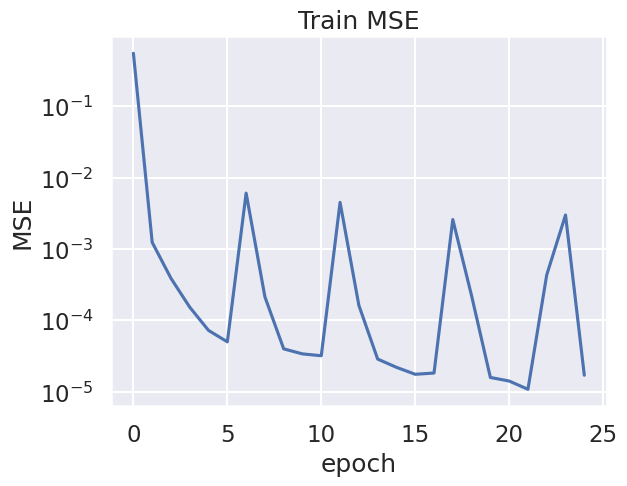

Test MSE = 0.000008


In [ ]:
model = TinyDiT().to(device)
curve = train(model, train_s, train_a, epochs=25)

plt.figure(); plt.plot(curve); plt.yscale("log"); plt.title("Train MSE"); plt.xlabel("epoch"); plt.ylabel("MSE"); plt.show()

# test error
with torch.no_grad():
    test_mse = F.mse_loss(model(test_s.to(device)), test_a.to(device)).item()
print(f"Test MSE = {test_mse:.6f}")

2. Linear probes – look for θ (angle), θ̇, energy neurons

In [ ]:
"""
True latent variables:
    θ        = arctan2(sinθ, cosθ)
    sinθ     = state[:,0]
    cosθ     = state[:,1]
    ω (dθ)   = state[:,2]
    Energy   = 1‑cosθ + 0.5*ω²
We probe hidden activations for sinθ, cosθ, ω, and Energy.
"""

with torch.no_grad():
    _, acts = model(test_s.to(device), return_acts=True)
acts = [h.cpu().numpy() for h in acts]
sinθ, cosθ, ω = test_s[:,0:1].numpy(), test_s[:,1:2].numpy(), test_s[:,2:3].numpy()
energy = 1 - cosθ + 0.5*ω**2

for layer,h in enumerate(acts):
    probe = LinearRegression().fit(h, energy)
    r2_E  = probe.score(h, energy)
    probe_w = LinearRegression().fit(h, ω)
    r2_W  = probe_w.score(h, ω)
    print(f"Layer {layer:02d}  R²(h→Energy)={r2_E:.3f}  R²(h→ω)={r2_W:.3f}")

Layer 00  R²(h→Energy)=0.590  R²(h→ω)=1.000
Layer 01  R²(h→Energy)=0.999  R²(h→ω)=1.000
Layer 02  R²(h→Energy)=1.000  R²(h→ω)=1.000
Layer 03  R²(h→Energy)=1.000  R²(h→ω)=1.000
Layer 04  R²(h→Energy)=1.000  R²(h→ω)=1.000
Layer 05  R²(h→Energy)=1.000  R²(h→ω)=1.000
Layer 06  R²(h→Energy)=1.000  R²(h→ω)=1.000


2. Neuron ablation – knock out top Energy neuron

In [ ]:
# find neuron with highest Pearson corr to energy in last block
h_last = acts[-1]                                      # (N,width)
corrs  = np.corrcoef(h_last.T, energy.flatten())[-1,:-1]
top_idx = np.argmax(np.abs(corrs))
print("top energy-corr neuron idx:", top_idx)

def ablate_neuron(model, idx):
    sample = test_s.to(device)
    with torch.no_grad():
        full = model(sample).cpu()
        # hook to zero neuron idx in all blocks
        handles=[]
        def hook(_,__,out): out[:,idx]=0
        for blk in model.blocks: handles.append(blk.register_forward_hook(hook))
        patched = model(sample).cpu()
        for h in handles: h.remove()
    delta = (patched - full).abs().mean().item()
    print(f"Ablating neuron {idx} changes mean|τ| by {delta:.4f}")

ablate_neuron(model, top_idx)

top energy-corr neuron idx: 16
Ablating neuron 16 changes mean|τ| by 0.0099


2. Capacity sweep (width)

epoch 01  MSE = 0.32634


epoch 02  MSE = 0.00324


epoch 03  MSE = 0.00081


epoch 04  MSE = 0.00043


epoch 05  MSE = 0.00029


epoch 06  MSE = 0.00022


epoch 07  MSE = 0.00017


epoch 08  MSE = 0.00014


epoch 09  MSE = 0.00012


epoch 10  MSE = 0.00011


epoch 11  MSE = 0.00010


epoch 12  MSE = 0.00008


epoch 13  MSE = 0.00009


epoch 14  MSE = 0.00020


epoch 15  MSE = 0.00041


epoch 01  MSE = 0.19215


epoch 02  MSE = 0.00213


epoch 03  MSE = 0.00748


epoch 04  MSE = 0.00057


epoch 05  MSE = 0.00021


epoch 06  MSE = 0.00053


epoch 07  MSE = 0.00369


epoch 08  MSE = 0.00021


epoch 09  MSE = 0.00009


epoch 10  MSE = 0.00420


epoch 11  MSE = 0.00096


epoch 12  MSE = 0.00012


epoch 13  MSE = 0.00008


epoch 14  MSE = 0.00006


epoch 15  MSE = 0.00005


epoch 01  MSE = 0.30154


epoch 02  MSE = 0.00428


epoch 03  MSE = 0.00033


epoch 04  MSE = 0.00019


epoch 05  MSE = 0.00014


epoch 06  MSE = 0.00011


epoch 07  MSE = 0.00008


epoch 08  MSE = 0.00006


epoch 09  MSE = 0.00004


epoch 10  MSE = 0.00003


epoch 11  MSE = 0.00003


epoch 12  MSE = 0.00002


epoch 13  MSE = 0.00002


epoch 14  MSE = 0.00001


epoch 15  MSE = 0.00001


epoch 01  MSE = 1.32322


epoch 02  MSE = 0.01222


epoch 03  MSE = 0.00141


epoch 04  MSE = 0.00077


epoch 05  MSE = 0.00047


epoch 06  MSE = 0.00030


epoch 07  MSE = 0.00020


epoch 08  MSE = 0.00014


epoch 09  MSE = 0.00011


epoch 10  MSE = 0.00009


epoch 11  MSE = 0.00008


epoch 12  MSE = 0.00007


epoch 13  MSE = 0.00006


epoch 14  MSE = 0.00005


epoch 15  MSE = 0.00005


epoch 01  MSE = 6.29456


epoch 02  MSE = 0.04170


epoch 03  MSE = 0.00742


epoch 04  MSE = 0.00351


epoch 05  MSE = 0.00237


epoch 06  MSE = 0.03698


epoch 07  MSE = 0.00570


epoch 08  MSE = 0.05194


epoch 09  MSE = 0.00281


epoch 10  MSE = 0.00053


epoch 11  MSE = 0.00032


epoch 12  MSE = 0.00026


epoch 13  MSE = 0.00020


epoch 14  MSE = 0.00016


epoch 15  MSE = 0.00015


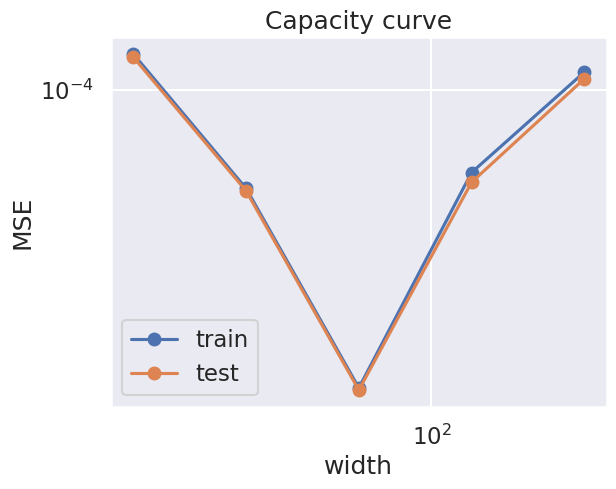

In [ ]:
def capacity_sweep(widths=[16,32,64,128,256], epochs=15):
    res=[]
    for w in widths:
        m=TinyDiT(width=w).to(device)
        train(m, train_s, train_a, epochs=epochs, bs=2048, lr=3e-3)
        with torch.no_grad():
            tr=F.mse_loss(m(train_s.to(device)), train_a.to(device)).item()
            te=F.mse_loss(m(test_s .to(device)), test_a .to(device)).item()
        res.append((w,tr,te))
    ws,tr,te=zip(*res)
    plt.figure(); plt.plot(ws,tr,"o-",label="train"); plt.plot(ws,te,"o-",label="test");
    plt.xscale("log"); plt.yscale("log"); plt.xlabel("width"); plt.ylabel("MSE");
    plt.title("Capacity curve"); plt.legend(); plt.show()
capacity_sweep()

2. Symmetry breaking demo

In [ ]:
def symmetry_break(width=128, epochs=18):
    outs = []
    for flip in [False, True]:
        # reset all RNGs so the two runs start identically
        torch.manual_seed(0)
        np.random.seed(0)
        random.seed(0)

        m = TinyDiT(width=width).to(device)

        # flip the sign of the first weight matrix in the second run
        if flip:
            with torch.no_grad():
                m.in_proj.weight.mul_(-1)

        train(m, train_s, train_a,
              epochs=epochs, lr=3e-3, bs=2048)

        outs.append(m(test_s.to(device)).cpu().detach().numpy())

    corr = np.corrcoef(outs[0].flatten(), outs[1].flatten())[0, 1]
    print(f"output corr (seed vs sign‑flip) = {corr:.3f}")
symmetry_break()

epoch 01  MSE = 1.33165


epoch 02  MSE = 0.01007


epoch 03  MSE = 0.00117


epoch 04  MSE = 0.00058


epoch 05  MSE = 0.00035


epoch 06  MSE = 0.00022


epoch 07  MSE = 0.00015


epoch 08  MSE = 0.00010


epoch 09  MSE = 0.00007


epoch 10  MSE = 0.00006


epoch 11  MSE = 0.00005


epoch 12  MSE = 0.00004


epoch 13  MSE = 0.00003


epoch 14  MSE = 0.00003


epoch 15  MSE = 0.00002


epoch 16  MSE = 0.00002


epoch 17  MSE = 0.00002


epoch 18  MSE = 0.00002


epoch 01  MSE = 1.39051


epoch 02  MSE = 0.00706


epoch 03  MSE = 0.00108


epoch 04  MSE = 0.00051


epoch 05  MSE = 0.00029


epoch 06  MSE = 0.00017


epoch 07  MSE = 0.00011


epoch 08  MSE = 0.00008


epoch 09  MSE = 0.00006


epoch 10  MSE = 0.00005


epoch 11  MSE = 0.00004


epoch 12  MSE = 0.00032


epoch 13  MSE = 0.00623


epoch 14  MSE = 0.00015


epoch 15  MSE = 0.00004


epoch 16  MSE = 0.00003


epoch 17  MSE = 0.00003


epoch 18  MSE = 0.00010
output corr (seed vs sign‑flip) = 1.000


2. Phase‑portrait vector field

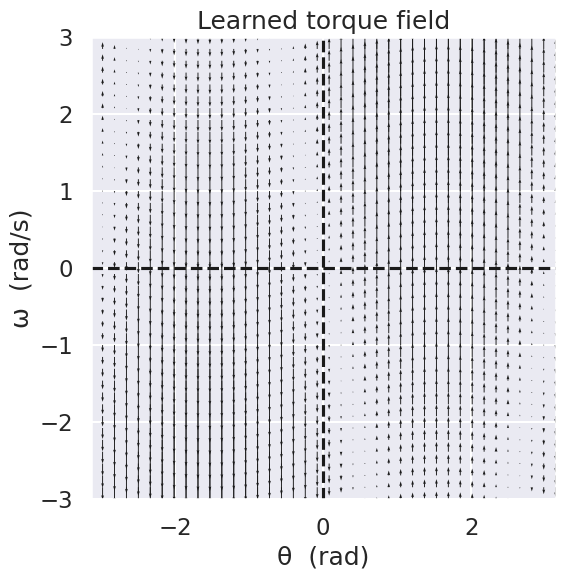

In [ ]:
def phase_portrait(model, n=40):
    θ  = np.linspace(-math.pi, math.pi, n)
    ω  = np.linspace(-3, 3, n)
    grid = np.stack(list(itertools.product(θ, ω)), axis=0).astype("float32")
    sinθ, cosθ = np.sin(grid[:,0:1]), np.cos(grid[:,0:1])
    state = torch.from_numpy(np.concatenate([sinθ, cosθ, grid[:,1:2]], axis=1))
    with torch.no_grad():
        τ = model(state.to(device)).cpu().numpy().flatten()
    plt.figure(figsize=(6,6))
    plt.quiver(grid[:,0], grid[:,1], np.zeros_like(τ), τ, angles='xy', scale_units='xy', scale=10, width=0.002)
    plt.xlabel("θ  (rad)"); plt.ylabel("ω  (rad/s)"); plt.title("Learned torque field"); plt.xlim(-math.pi,math.pi); plt.ylim(-3,3)
    plt.axvline(0, ls='--', c='k'); plt.axhline(0, ls='--', c='k')
    plt.show()
phase_portrait(model)

Tier 3

3. Runtime & dependencies

In [ ]:
!pip install -q torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
!pip install -q einops tqdm scikit-learn matplotlib seaborn

3. Imports & helpers

In [ ]:
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import numpy as np, random, math, tqdm, itertools
from einops import rearrange
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt, seaborn as sns
sns.set(context="talk")

device = "cuda" if torch.cuda.is_available() else "cpu"
print("device:", device)

device: cuda


3. Planar 3‑DoF arm kinematics   (we treat link‑3 as a stub ‘hand’)

In [ ]:
L1 = L2 = L3 = 1.0                         # link lengths

def forward_kinematics(q):
    """q (…,3) → (…,2) end‑effector XY (hand tip)."""
    q1,q2,q3 = np.split(q, 3, axis=-1)
    x = L1*np.cos(q1) + L2*np.cos(q1+q2) + L3*np.cos(q1+q2+q3)
    y = L1*np.sin(q1) + L2*np.sin(q1+q2) + L3*np.sin(q1+q2+q3)
    return np.concatenate([x,y], axis=-1)

def ik_2link(xy):
    """
    Analytic IK for the first two links (q3=0 for simplicity).
    Returns (q1,q2) in radians; may fail if target unreachable.
    """
    x,y = xy[...,0], xy[...,1]
    r2  = x**2 + y**2
    cos2 = (r2 - L1**2 - L2**2) / (2*L1*L2)
    cos2 = np.clip(cos2, -1.0, 1.0)
    q2   = np.arccos(cos2)                         # elbow‑down
    k1   = L1 + L2*np.cos(q2)
    k2   = L2*np.sin(q2)
    q1   = np.arctan2(y, x) - np.arctan2(k2, k1)
    q3   = 0.0
    return np.stack([q1,q2,q3], axis=-1)           # (...,3)

3. Dataset – synthetic pick‑and‑place demonstrations

In [ ]:
"""
State  (6‑D)  = [q1,q2,q3,   x_obj, y_obj, holding]
Action (6‑D)  = [Δq1,Δq2,Δq3, gripper_cmd, 0, 0]

Logic:
    if holding==0  → target = object position  (approach phase)
    if holding==1  → target = fixed place bin (transport phase)
PD rule in joint space:
    Δqi = k * (q_target_i − q_i)
Gripper command:
    +1 to close when approaching, −1 to open when transporting.
"""

K_GAIN = 0.5
PLACE_BIN = np.array([0.0, 1.5])          # fixed receptacle

def one_demo_sample(rng):
    # 1. randomly spawn object within reach (<2.7 m for our 3×1.0 links)
    r = rng.uniform(0.3, 2.5)
    phi = rng.uniform(-math.pi, math.pi)
    obj = np.array([r*math.cos(phi), r*math.sin(phi)], dtype="float32")
    # 2. holding flag
    holding = 1#rng.integers(0,2)           # 0 or 1
    target  = obj if holding==0 else PLACE_BIN
    # 3. target joint angles via IK
    q_tar   = ik_2link(target)
    # 4. current joint angles = target plus small Gaussian noise
    q_now   = q_tar + rng.normal(0, 0.15, size=3).astype("float32")
    # 5. PD joint‑space action
    dq      = K_GAIN * (q_tar - q_now)
    # 6. gripper command (+1 close, ‑1 open, scale=0.2)
    grip    = 0.2*(1-holding) - 0.2*holding
    # 7. assemble state & action (pad to 6)
    state   = np.concatenate([q_now, obj, [holding]], axis=0)
    act     = np.concatenate([dq, [grip,0,0]], axis=0)
    return state.astype("float32"), act.astype("float32")

def gen_dataset(N=120_000, seed=None):
    rng = np.random.default_rng(seed)
    states, actions = zip(*(one_demo_sample(rng) for _ in range(N)))
    return torch.tensor(np.stack(states)), torch.tensor(np.stack(actions))

train_s, train_a = gen_dataset(120_000, seed=0)
test_s,  test_a  = gen_dataset(8_192,   seed=1)
print("train", train_s.shape, train_a.shape)

train torch.Size([120000, 6]) torch.Size([120000, 6])


3. Tiny DiT residual MLP  (6 → 6)

In [ ]:
class TinyDiT(nn.Module):
    def __init__(self, state_dim=6, action_dim=6, width=256, depth=6):
        super().__init__()
        self.in_proj  = nn.Linear(state_dim, width)
        self.blocks   = nn.ModuleList([
            nn.Sequential(
                nn.LayerNorm(width),
                nn.Linear(width, width*4),
                nn.GELU(),
                nn.Linear(width*4, width)
            ) for _ in range(depth)
        ])
        self.out_proj = nn.Linear(width, action_dim)

    def forward(self, x, return_acts=False):
        h  = self.in_proj(x)
        hs = [h]                        # store residual stream for probes
        for blk in self.blocks:
            h = h + blk(h)
            hs.append(h)
        out = self.out_proj(h)
        return (out, hs) if return_acts else out

3. Training loop

In [ ]:
def train(model, s, a, epochs=30, bs=2048, lr=3e-3):
    ds     = TensorDataset(s, a)
    loader = DataLoader(ds, bs, shuffle=True)
    opt    = torch.optim.AdamW(model.parameters(), lr=lr)
    curve  = []
    for ep in range(epochs):
        running=0.
        for b_s,b_a in tqdm.tqdm(loader, desc=f"epoch {ep+1}/{epochs}", leave=False):
            b_s,b_a = b_s.to(device), b_a.to(device)
            pred = model(b_s)
            loss = F.mse_loss(pred, b_a)
            opt.zero_grad(); loss.backward(); opt.step()
            running += loss.item()*len(b_s)
        curve.append(running/len(ds))
        print(f"epoch {ep+1:02d}  MSE = {curve[-1]:.4f}")
    return curve

3. Train reference model

epoch 01  MSE = 2.8564


epoch 02  MSE = 0.0068


epoch 03  MSE = 0.0011


epoch 04  MSE = 0.0008


epoch 05  MSE = 0.0006


epoch 06  MSE = 0.0005


epoch 07  MSE = 0.0003


epoch 08  MSE = 0.0003


epoch 09  MSE = 0.0101


epoch 10  MSE = 0.0005


epoch 11  MSE = 0.0001


epoch 12  MSE = 0.0001


epoch 13  MSE = 0.0139


epoch 14  MSE = 0.0008


epoch 15  MSE = 0.0001


epoch 16  MSE = 0.0000


epoch 17  MSE = 0.0000


epoch 18  MSE = 0.0000


epoch 19  MSE = 0.0000


epoch 20  MSE = 0.0000


epoch 21  MSE = 0.0051


epoch 22  MSE = 0.0003


epoch 23  MSE = 0.0000


epoch 24  MSE = 0.0000


epoch 25  MSE = 0.0000


epoch 26  MSE = 0.0000


epoch 27  MSE = 0.0009


epoch 28  MSE = 0.0001


epoch 29  MSE = 0.0000


epoch 30  MSE = 0.0000


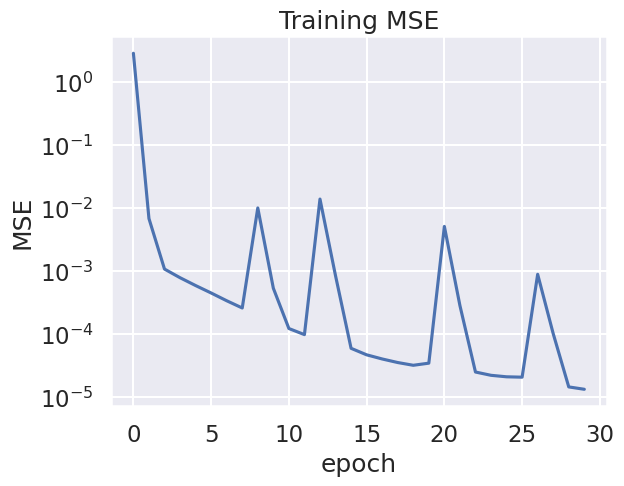

Test MSE = 0.00001


In [ ]:
model = TinyDiT().to(device)
loss_curve = train(model, train_s, train_a, epochs=30)

plt.figure(); plt.plot(loss_curve); plt.yscale("log")
plt.title("Training MSE"); plt.xlabel("epoch"); plt.ylabel("MSE"); plt.show()

with torch.no_grad():
    test_mse = F.mse_loss(model(test_s.to(device)), test_a.to(device)).item()
print(f"Test MSE = {test_mse:.5f}")

3. Linear probes – distances & holding flag

In [ ]:
with torch.no_grad():
    _, acts = model(test_s.to(device), return_acts=True)
acts = [h.cpu().numpy() for h in acts]
q_now = test_s[:,:3].numpy()
ee_xy = forward_kinematics(q_now)
obj_xy = test_s[:,3:5].numpy()
d_obj  = np.linalg.norm(ee_xy - obj_xy, axis=1, keepdims=True)
place_xy = np.broadcast_to(PLACE_BIN, obj_xy.shape)
d_place = np.linalg.norm(ee_xy - place_xy, axis=1, keepdims=True)
holding = test_s[:,5:6].numpy()

print("\nLayer  R²→dist_obj   R²→dist_place  R²→holding")
for i,h in enumerate(acts):
    r2_o  = LinearRegression().fit(h,d_obj).score(h,d_obj)
    r2_p  = LinearRegression().fit(h,d_place).score(h,d_place)
    r2_h  = LinearRegression().fit(h,holding).score(h,holding)
    print(f"{i:2d}     {r2_o:.3f}        {r2_p:.3f}          {r2_h:.3f}")


Layer  R²→dist_obj   R²→dist_place  R²→holding
 0     0.886        0.769          1.000
 1     0.995        0.805          1.000
 2     0.994        0.810          1.000
 3     0.994        0.808          1.000
 4     0.994        0.856          1.000
 5     0.994        0.856          1.000
 6     0.994        0.859          1.000


3. Ablate top “distance‑to‑obj” neuron

In [ ]:
h_last = acts[-1]
corrs  = np.corrcoef(h_last.T, d_obj.flatten())[-1,:-1]
top_d_idx = np.argmax(np.abs(corrs))
print("\nTop distance‑to‑obj neuron:", top_d_idx)

def ablate_neuron(model, idx):
    sample = test_s.to(device)
    with torch.no_grad():
        full = model(sample).cpu()
        handles=[]
        def hook(_,__,out): out[:,idx]=0
        for blk in model.blocks: handles.append(blk.register_forward_hook(hook))
        patched = model(sample).cpu()
        for h in handles: h.remove()
    delta = (patched[:,:3]-full[:,:3]).norm(dim=1).mean().item()
    print(f"Mean joint‑Δ change after ablation = {delta:.4f}")

ablate_neuron(model, top_d_idx)


Top distance‑to‑obj neuron: 223
Mean joint‑Δ change after ablation = 0.0410


3. Capacity sweep

epoch 01  MSE = 0.1546


epoch 02  MSE = 0.0025


epoch 03  MSE = 0.0006


epoch 04  MSE = 0.0003


epoch 05  MSE = 0.0001


epoch 06  MSE = 0.0001


epoch 07  MSE = 0.0001


epoch 08  MSE = 0.0000


epoch 09  MSE = 0.0000


epoch 10  MSE = 0.0000


epoch 11  MSE = 0.0000


epoch 12  MSE = 0.0000


epoch 13  MSE = 0.0000


epoch 14  MSE = 0.0000


epoch 15  MSE = 0.0000


epoch 01  MSE = 0.5150


epoch 02  MSE = 0.0038


epoch 03  MSE = 0.0005


epoch 04  MSE = 0.0002


epoch 05  MSE = 0.0001


epoch 06  MSE = 0.0029


epoch 07  MSE = 0.0002


epoch 08  MSE = 0.0000


epoch 09  MSE = 0.0000


epoch 10  MSE = 0.0000


epoch 11  MSE = 0.0000


epoch 12  MSE = 0.0000


epoch 13  MSE = 0.0000


epoch 14  MSE = 0.0001


epoch 15  MSE = 0.0011


epoch 01  MSE = 4.7870


epoch 02  MSE = 0.1047


epoch 03  MSE = 0.0064


epoch 04  MSE = 0.0019


epoch 05  MSE = 0.0013


epoch 06  MSE = 0.0010


epoch 07  MSE = 0.0007


epoch 08  MSE = 0.0006


epoch 09  MSE = 0.0004


epoch 10  MSE = 0.0403


epoch 11  MSE = 0.0175


epoch 12  MSE = 0.0009


epoch 13  MSE = 0.0003


epoch 14  MSE = 0.0002


epoch 15  MSE = 0.0002


epoch 01  MSE = 35.3051


epoch 02  MSE = 0.1982


epoch 03  MSE = 0.0103


epoch 04  MSE = 0.0023


epoch 05  MSE = 0.0016


epoch 06  MSE = 0.0013


epoch 07  MSE = 0.0011


epoch 08  MSE = 0.0010


epoch 09  MSE = 0.0008


epoch 10  MSE = 0.0007


epoch 11  MSE = 0.0007


epoch 12  MSE = 0.0006


epoch 13  MSE = 0.0005


epoch 14  MSE = 0.0696


epoch 15  MSE = 0.0260


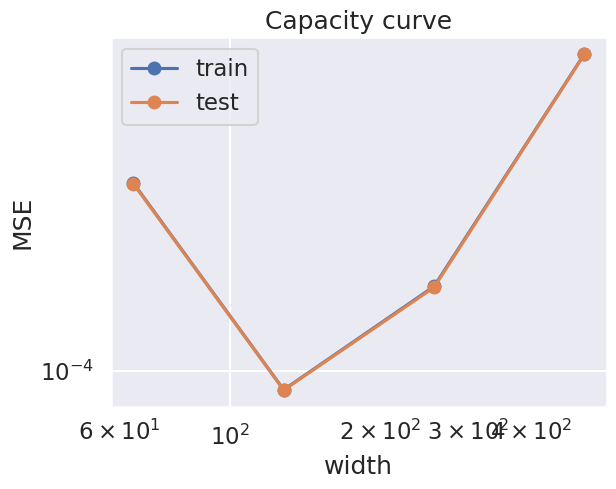

In [ ]:
def capacity_sweep(widths=[64,128,256,512], epochs=15):
    res=[]
    for w in widths:
        m=TinyDiT(width=w).to(device)
        train(m, train_s, train_a, epochs=epochs, bs=4096, lr=3e-3)
        with torch.no_grad():
            tr=F.mse_loss(m(train_s.to(device)), train_a.to(device)).item()
            te=F.mse_loss(m(test_s .to(device)), test_a .to(device)).item()
        res.append((w,tr,te))
    ws,tr,te=zip(*res)
    plt.figure(); plt.plot(ws,tr,"o-",label="train"); plt.plot(ws,te,"o-",label="test")
    plt.xscale("log"); plt.yscale("log"); plt.xlabel("width"); plt.ylabel("MSE")
    plt.title("Capacity curve"); plt.legend(); plt.show()
capacity_sweep()

3. Symmetry‑breaking demo

In [ ]:
def symmetry_break(width=256, epochs=20):
    outs=[]
    for flip in [False,True]:
        torch.manual_seed(0); np.random.seed(0); random.seed(0)
        m=TinyDiT(width=width).to(device)
        if flip:
            with torch.no_grad():
                m.in_proj.weight.mul_(-1)
        train(m, train_s, train_a, epochs=epochs, bs=4096, lr=3e-3)
        outs.append(m(test_s.to(device)).cpu().detach().numpy())
    corr=np.corrcoef(outs[0].flatten(), outs[1].flatten())[0,1]
    print("output corr (seed vs sign‑flip) =", round(corr,3))
symmetry_break()

epoch 01  MSE = 5.4229


epoch 02  MSE = 0.0885


epoch 03  MSE = 0.0056


epoch 04  MSE = 0.0016


epoch 05  MSE = 0.0013


epoch 06  MSE = 0.0606


epoch 07  MSE = 0.0028


epoch 08  MSE = 0.0006


epoch 09  MSE = 0.0004


epoch 10  MSE = 0.0227


epoch 11  MSE = 0.0021


epoch 12  MSE = 0.0003


epoch 13  MSE = 0.0002


epoch 14  MSE = 0.0002


epoch 15  MSE = 0.0001


epoch 16  MSE = 0.0001


epoch 17  MSE = 0.0001


epoch 18  MSE = 0.0001


epoch 19  MSE = 0.0169


epoch 20  MSE = 0.0018


epoch 01  MSE = 4.7308


epoch 02  MSE = 0.0891


epoch 03  MSE = 0.0050


epoch 04  MSE = 0.0015


epoch 05  MSE = 0.0010


epoch 06  MSE = 0.0008


epoch 07  MSE = 0.0006


epoch 08  MSE = 0.0005


epoch 09  MSE = 0.0004


epoch 10  MSE = 0.0003


epoch 11  MSE = 0.0003


epoch 12  MSE = 0.0002


epoch 13  MSE = 0.0002


epoch 14  MSE = 0.0001


epoch 15  MSE = 0.0001


epoch 16  MSE = 0.0001


epoch 17  MSE = 0.0155


epoch 18  MSE = 0.0010


epoch 19  MSE = 0.0001


epoch 20  MSE = 0.0001
output corr (seed vs sign‑flip) = 0.991


3. Task‑space quiver  (EE velocity field for holding==0)

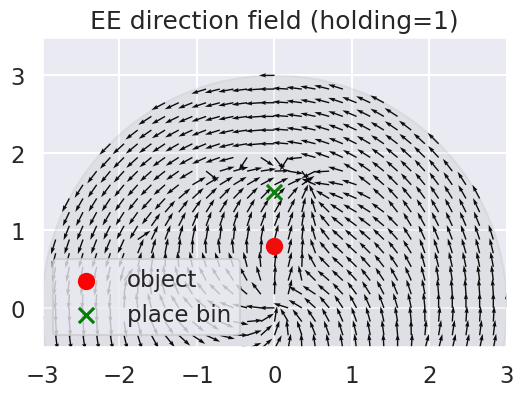

In [ ]:
# ------------------------------------------------------------------
# Analytic IK for the first two links (q3 is a zero “stub” link)
# ------------------------------------------------------------------
def ik_2link(xy):
    """
    xy  – array (...,2) of target EE positions
    out – array (...,3) of joint angles [q1,q2,q3]
    """
    x, y = xy[..., 0], xy[..., 1]                  # shapes (...,)
    r2   = x**2 + y**2
    cos2 = (r2 - L1**2 - L2**2) / (2 * L1 * L2)
    cos2 = np.clip(cos2, -1.0, 1.0)
    q2   = np.arccos(cos2)                         # elbow‑down
    k1   = L1 + L2 * np.cos(q2)
    k2   = L2 * np.sin(q2)
    q1   = np.arctan2(y, x) - np.arctan2(k2, k1)

    q3   = np.zeros_like(q1)                      # make q3 the same shape

    return np.stack([q1, q2, q3], axis=-1)        # (..., 3)

# ------------------------------------------------------------------
# Quiver‑field visual for the approach phase
# ------------------------------------------------------------------
# ------------------------------------------------------------------
# Quiver‑field visual – cleaned & fixed
# ------------------------------------------------------------------
def quiver_field_clean(model, n=35, max_reach=3.0, arrow_scale=0.2):
    xs   = np.linspace(-max_reach, max_reach, n, dtype="float32")
    grid = np.array(list(itertools.product(xs, xs)), dtype="float32")        # (n²,2)

    # mask unreachable EE points
    reachable = (np.linalg.norm(grid, axis=1) <= (L1 + L2 + L3) + 1e-3)
    grid = grid[reachable]                                                   # (M,2)

    obj_xy       = np.repeat([[0.0, 0.8]], len(grid), axis=0).astype("float32")
    holding_flag = np.zeros((len(grid), 1), dtype="float32")                 # approach

    q   = ik_2link(grid)                                                     # (M,3)
    inp = torch.from_numpy(np.concatenate([q, obj_xy, holding_flag], axis=1))

    with torch.no_grad():
        dq = model(inp.to(device)).cpu().numpy()[:, :3]                      # (M,3)

    # ---------------- Jacobian (fixed batch dims) -----------------
    def jacobian(q):
        """
        q – (...,3) joint angles
        returns (...,2,3) EE Jacobian
        """
        q1, q2, q3 = q[..., 0], q[..., 1], q[..., 2]
        s1,   c1   = np.sin(q1),                np.cos(q1)
        s12,  c12  = np.sin(q1 + q2),           np.cos(q1 + q2)
        s123, c123 = np.sin(q1 + q2 + q3),      np.cos(q1 + q2 + q3)

        # partials for X row
        Jx_q1 = -L1*s1 - L2*s12 - L3*s123
        Jx_q2 =         -L2*s12 - L3*s123
        Jx_q3 =                      -L3*s123
        # partials for Y row
        Jy_q1 =  L1*c1 + L2*c12 + L3*c123
        Jy_q2 =          L2*c12 + L3*c123
        Jy_q3 =                       L3*c123

        Jx_row = np.stack([Jx_q1, Jx_q2, Jx_q3], axis=-1)   # (...,3)
        Jy_row = np.stack([Jy_q1, Jy_q2, Jy_q3], axis=-1)   # (...,3)
        J      = np.stack([Jx_row, Jy_row], axis=-2)        # (...,2,3)
        return J

    J       = jacobian(q)                                    # (M,2,3)
    ee_vel  = np.einsum('nij,nj->ni', J, dq)                 # (M,2)

    # ---------- normalise for clearer arrows -------------
    dirs = ee_vel / (np.linalg.norm(ee_vel, axis=1, keepdims=True) + 1e-8)

    # ------------------- plot ----------------------------
    plt.figure(figsize=(6, 6))
    plt.quiver(grid[:, 0], grid[:, 1],
               dirs[:, 0], dirs[:, 1],
               angles='xy', scale_units='xy',
               scale=1/arrow_scale, width=0.003, color='black')

    plt.scatter(obj_xy[0, 0], obj_xy[0, 1],
                s=120, c='red', label="object")
    plt.scatter(*PLACE_BIN,
                s=120, c='green', marker='x', label="place bin")

    workspace = plt.Circle((0, 0), L1 + L2 + L3,
                            color='gray', alpha=0.1)
    plt.gca().add_patch(workspace)

    plt.xlim(-max_reach, max_reach)
    plt.ylim(-0.5, max_reach + 0.5)
    plt.gca().set_aspect('equal')
    plt.title("EE direction field (holding=1)")
    plt.legend(); plt.show()

quiver_field_clean(model)

Tier 4

In [ ]:
import math, random, itertools
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import tqdm

# device
device = "cuda" if torch.cuda.is_available() else "cpu"


In [ ]:
L1 = L2 = L3 = 1.0             # link lengths
K_GAIN = 0.5                   # PD gain
OBJ_NOISE = 0.05               # σ for object‐position noise
BIN_NOISE = 0.05               # σ for bin‐position noise
Q_NOISE   = 0.15               # σ for joint‐angle noise
PHASES    = {0:"approach",1:"transport",2:"release"}

In [ ]:
# =============================================================================
# 1.  Forward & inverse kinematics
# =============================================================================
def forward_kinematics(q):
    q1,q2,q3 = q[...,0], q[...,1], q[...,2]
    x = L1*np.cos(q1) + L2*np.cos(q1+q2) + L3*np.cos(q1+q2+q3)
    y = L1*np.sin(q1) + L2*np.sin(q1+q2) + L3*np.sin(q1+q2+q3)
    return np.stack([x,y], axis=-1)

def ik_2link(xy):
    x,y = xy[...,0], xy[...,1]
    r2 = x**2 + y**2
    cos2 = (r2 - L1**2 - L2**2) / (2*L1*L2)
    cos2 = np.clip(cos2, -1.0, 1.0)
    q2 = np.arccos(cos2)
    k1 = L1 + L2*np.cos(q2)
    k2 = L2*np.sin(q2)
    q1 = np.arctan2(y,x) - np.arctan2(k2,k1)
    q3 = 0.0
    return np.stack([q1,q2,q3], axis=-1)

In [ ]:
# =============================================================================
# 2.  Data generator with three phases, moving bin, and sensor noise
# =============================================================================
def one_sample(rng):
    # 1. random object
    r   = rng.uniform(0.3, L1+L2+L3-0.1)
    phi = rng.uniform(-math.pi, math.pi)
    obj = np.array([r*math.cos(phi), r*math.sin(phi)], dtype="float32")

    # 2. moving bin
    rb   = rng.uniform(0.3, L1+L2+L3-0.1)
    phib = rng.uniform(-math.pi, math.pi)
    bin_xy = np.array([rb*math.cos(phib), rb*math.sin(phib)], dtype="float32")

    # 3. phase
    phase = rng.integers(0, 3)  # 0=approach,1=transport,2=release

    # 4. choose target EEF
    if phase == 0:
        tgt_xy = obj
    else:
        tgt_xy = bin_xy

    # 5. compute target joints via IK
    q_tar = ik_2link(tgt_xy)

    # 6. current joint angles = target + noise
    q_now = q_tar + rng.normal(0, Q_NOISE, size=3).astype("float32")

    # 7. sensor noise on object and bin
    obj_meas = obj + rng.normal(0, OBJ_NOISE, size=2).astype("float32")
    bin_meas = bin_xy + rng.normal(0, BIN_NOISE, size=2).astype("float32")

    # 8. PD joint‐space action
    dq = K_GAIN * (q_tar - q_now).astype("float32")

    # 9. gripper command: +0.2 close on approach, 0.0 hold, -0.2 open on release
    if phase == 0:
        grip = +0.2
    elif phase == 1:
        grip =  0.0
    else:
        grip = -0.2

    # 10. assemble state (8-D) and action (6-D)
    state = np.concatenate([q_now, obj_meas, bin_meas, [float(phase)]], axis=0)
    action = np.concatenate([dq, [grip, 0.0, 0.0]], axis=0)

    return state.astype("float32"), action.astype("float32")

def gen_dataset(N=120_000, seed=0):
    rng = np.random.default_rng(seed)
    S, A = zip(*(one_sample(rng) for _ in range(N)))
    return torch.tensor(np.stack(S)), torch.tensor(np.stack(A))

# generate data
train_s, train_a = gen_dataset(120_000, seed=0)
test_s,  test_a  = gen_dataset(  8_192, seed=1)
print("train", train_s.shape, train_a.shape)  # (120000,8), (120000,6)

train torch.Size([120000, 8]) torch.Size([120000, 6])


In [ ]:
# =============================================================================
# 3.  TinyDiT model for Tier 4
# =============================================================================
class TinyDiT_T4(nn.Module):
    def __init__(self, state_dim=8, action_dim=6, width=256, depth=6):
        super().__init__()
        self.in_proj  = nn.Linear(state_dim, width)
        self.blocks   = nn.ModuleList([
            nn.Sequential(
                nn.LayerNorm(width),
                nn.Linear(width, width*4),
                nn.GELU(),
                nn.Linear(width*4, width)
            ) for _ in range(depth)
        ])
        self.out_proj = nn.Linear(width, action_dim)

    def forward(self, x, return_acts=False):
        h, hs = self.in_proj(x), []
        hs.append(h)
        for blk in self.blocks:
            h = h + blk(h)
            hs.append(h)
        out = self.out_proj(h)
        return (out, hs) if return_acts else out

epoch 01  MSE = 0.83336


epoch 02  MSE = 0.00205


epoch 03  MSE = 0.00393


epoch 04  MSE = 0.00166


epoch 05  MSE = 0.00144


epoch 06  MSE = 0.00136


epoch 07  MSE = 0.00146


epoch 08  MSE = 0.00132


epoch 09  MSE = 0.00122


epoch 10  MSE = 0.00124


epoch 11  MSE = 0.00111


epoch 12  MSE = 0.00147


epoch 13  MSE = 0.00090


epoch 14  MSE = 0.00086


epoch 15  MSE = 0.00087


epoch 16  MSE = 0.00079


epoch 17  MSE = 0.00102


epoch 18  MSE = 0.00080


epoch 19  MSE = 0.00065


epoch 20  MSE = 0.00062


epoch 21  MSE = 0.00060


epoch 22  MSE = 0.00058


epoch 23  MSE = 0.00058


epoch 24  MSE = 0.00056


epoch 25  MSE = 0.00059


epoch 26  MSE = 0.00053


epoch 27  MSE = 0.00056


epoch 28  MSE = 0.00048


epoch 29  MSE = 0.00046


epoch 30  MSE = 0.00052


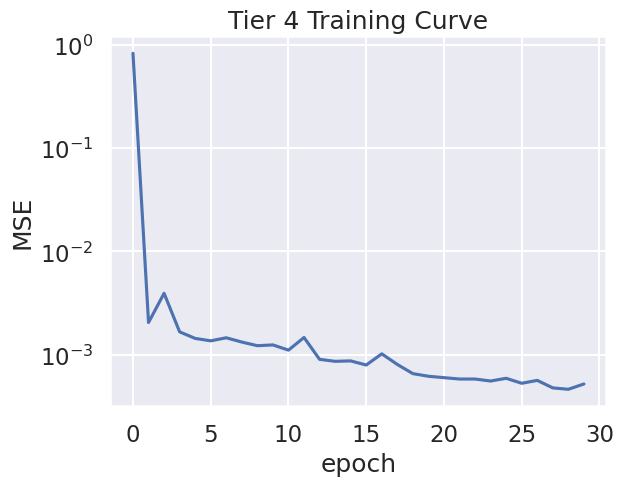

Test MSE = 0.0005471997428685427


In [ ]:
# =============================================================================
# 4.  Training loop
# =============================================================================
def train(model, s, a, epochs=30, bs=2048, lr=3e-3):
    ds     = TensorDataset(s, a)
    loader = DataLoader(ds, bs, shuffle=True)
    opt    = torch.optim.AdamW(model.parameters(), lr=lr)
    curve  = []
    for ep in range(epochs):
        total = 0.0
        for bs_s, bs_a in tqdm.tqdm(loader, desc=f"Epoch {ep+1}/{epochs}", leave=False):
            bs_s, bs_a = bs_s.to(device), bs_a.to(device)
            pred       = model(bs_s)
            loss       = F.mse_loss(pred, bs_a)
            opt.zero_grad(); loss.backward(); opt.step()
            total += loss.item()*len(bs_s)
        mse = total / len(ds)
        curve.append(mse)
        print(f"epoch {ep+1:02d}  MSE = {mse:.5f}")
    return curve

# train
model = TinyDiT_T4().to(device)
loss_curve = train(model, train_s, train_a, epochs=30)

# plot
plt.figure(); plt.plot(loss_curve);
plt.yscale("log"); plt.xlabel("epoch"); plt.ylabel("MSE");
plt.title("Tier 4 Training Curve"); plt.show()

# test error
with torch.no_grad():
    test_mse = F.mse_loss(model(test_s.to(device)), test_a.to(device)).item()
print("Test MSE =", test_mse)

In [ ]:

# =============================================================================
# 5.  Probes for new distance and filtering features
# =============================================================================
with torch.no_grad():
    _, acts = model(test_s.to(device), return_acts=True)
acts = [h.cpu().numpy() for h in acts]

# compute true distances and phase
q_now     = test_s[:,:3].numpy()
ee_xy     = forward_kinematics(q_now)
obj_xy    = test_s[:,3:5].numpy()
bin_xy    = test_s[:,5:7].numpy()
d_obj     = np.linalg.norm(ee_xy - obj_xy, axis=1, keepdims=True)
d_bin     = np.linalg.norm(ee_xy - bin_xy, axis=1, keepdims=True)
phase_f   = test_s[:,7:8].numpy()

print("\nLayer   R²→d_obj   R²→d_bin   R²→phase")
for i,h in enumerate(acts):
    r2_o = LinearRegression().fit(h, d_obj).score(h, d_obj)
    r2_b = LinearRegression().fit(h, d_bin).score(h, d_bin)
    r2_p = LinearRegression().fit(h, phase_f).score(h, phase_f)
    print(f"{i:2d}     {r2_o:.3f}       {r2_b:.3f}       {r2_p:.3f}")


Layer   R²→d_obj   R²→d_bin   R²→phase
 0     0.365       0.433       1.000
 1     0.937       0.935       1.000
 2     0.951       0.950       1.000
 3     0.953       0.952       1.000
 4     0.954       0.955       1.000
 5     0.955       0.957       1.000
 6     0.953       0.958       1.000


5.

In [ ]:
import math, random, itertools
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
# -----------------------------------------------------------------------------
# 1. Kinematics & Data Generation (Tier 3 pick-and-place)
# -----------------------------------------------------------------------------
L1 = L2 = L3 = 1.0
PLACE_BIN = np.array([0.0, 1.5], dtype="float32")
K_GAIN = 0.5

def forward_kinematics(q):
    q1, q2, q3 = q[...,0], q[...,1], q[...,2]
    x = L1*np.cos(q1) + L2*np.cos(q1+q2) + L3*np.cos(q1+q2+q3)
    y = L1*np.sin(q1) + L2*np.sin(q1+q2) + L3*np.sin(q1+q2+q3)
    return np.stack([x, y], axis=-1)

def ik_2link(xy):
    x, y = xy[...,0], xy[...,1]
    r2 = x**2 + y**2
    cos2 = (r2 - L1*L1 - L2*L2) / (2*L1*L2)
    cos2 = np.clip(cos2, -1.0, 1.0)
    q2 = np.arccos(cos2)
    k1 = L1 + L2*np.cos(q2)
    k2 = L2*np.sin(q2)
    q1 = np.arctan2(y, x) - np.arctan2(k2, k1)
    q3 = np.zeros_like(q1)
    return np.stack([q1, q2, q3], axis=-1).astype("float32")

def one_demo(rng):
    r   = rng.uniform(0.3, L1+L2+L3-0.1)
    phi = rng.uniform(-math.pi, math.pi)
    obj = np.array([r*math.cos(phi), r*math.sin(phi)], dtype="float32")
    holding = rng.integers(0,2)
    target  = obj if holding==0 else PLACE_BIN
    q_tar = ik_2link(target)
    q_now = q_tar + rng.normal(0,0.15,size=3).astype("float32")
    dq    = K_GAIN*(q_tar - q_now)
    grip  = 0.2*(1-holding) - 0.2*holding
    state  = np.concatenate([q_now, obj, [float(holding)]], axis=0)
    action = np.concatenate([dq, [grip,0.0,0.0]], axis=0)
    return state.astype("float32"), action.astype("float32")

def gen_dataset(N, seed):
    rng = np.random.default_rng(seed)
    S, A = zip(*(one_demo(rng) for _ in range(N)))
    return torch.tensor(np.stack(S)).float(), torch.tensor(np.stack(A)).float()

train_s, train_a = gen_dataset(120_000, seed=0)
test_s,  test_a  = gen_dataset(  8_192, seed=1)
print("Dataset shapes:", train_s.shape, train_a.shape)

Dataset shapes: torch.Size([120000, 6]) torch.Size([120000, 6])


In [ ]:
# -----------------------------------------------------------------------------
# 2. Transformer-style TinyDiT with Self-Attention
# -----------------------------------------------------------------------------
class TransformerBlock(nn.Module):
    def __init__(self, width, n_heads=4):
        super().__init__()
        self.ln1  = nn.LayerNorm(width)
        self.attn = nn.MultiheadAttention(width, n_heads, batch_first=True)
        self.ln2  = nn.LayerNorm(width)
        self.mlp  = nn.Sequential(
            nn.Linear(width, width*4), nn.GELU(), nn.Linear(width*4, width)
        )
    def forward(self, x):
        h    = self.ln1(x)
        out,_= self.attn(h, h, h)
        x    = x + out
        h2   = self.ln2(x)
        return x + self.mlp(h2)

class TinyDiT_Attn(nn.Module):
    def __init__(self, state_dim=1, action_dim=6, tokens=6,
                 width=256, depth=6, heads=4):
        super().__init__()
        self.tokens   = tokens
        self.in_proj  = nn.Linear(state_dim, width)
        self.blocks   = nn.ModuleList([
            TransformerBlock(width, heads) for _ in range(depth)
        ])
        self.out_proj = nn.Linear(width*tokens, action_dim)

    def forward(self, x, return_acts=False):
        B = x.shape[0]
        h = x.unsqueeze(-1)        # (B, tokens, 1)
        h = self.in_proj(h)        # (B, tokens, width)
        acts = [h]
        for blk in self.blocks:
            h = h + blk(h)
            acts.append(h)
        flat = h.reshape(B, -1)
        out  = self.out_proj(flat)
        return (out, acts) if return_acts else out

Epoch 01/20  MSE = 1109.508424
Epoch 02/20  MSE = 4.339207
Epoch 03/20  MSE = 1.946051
Epoch 04/20  MSE = 0.558496
Epoch 05/20  MSE = 1.881993
Epoch 06/20  MSE = 0.103281
Epoch 07/20  MSE = 0.357804
Epoch 08/20  MSE = 0.713513
Epoch 09/20  MSE = 0.214436
Epoch 10/20  MSE = 0.805753
Epoch 11/20  MSE = 0.179942
Epoch 12/20  MSE = 0.323383
Epoch 13/20  MSE = 0.593044
Epoch 14/20  MSE = 0.025308
Epoch 15/20  MSE = 0.385508
Epoch 16/20  MSE = 0.028890
Epoch 17/20  MSE = 0.110027
Epoch 18/20  MSE = 0.268348
Epoch 19/20  MSE = 0.401673
Epoch 20/20  MSE = 0.090162


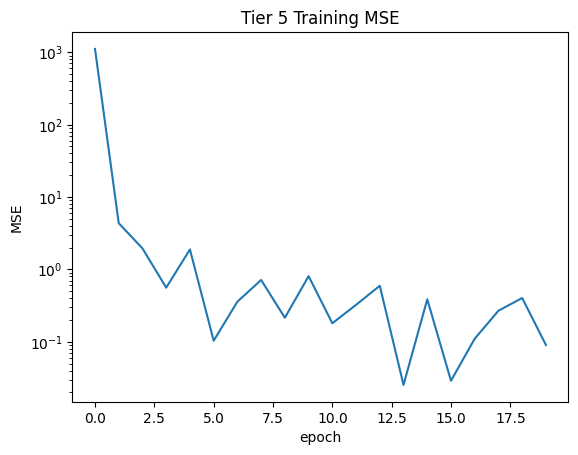

Test MSE = 0.03092120587825775
Epoch 01/5  MSE = 970.978495
Epoch 02/5  MSE = 1.896618
Epoch 03/5  MSE = 0.179170
Epoch 04/5  MSE = 0.114641
Epoch 05/5  MSE = 0.412471
Epoch 01/5  MSE = 1136.387058
Epoch 02/5  MSE = 9.018697
Epoch 03/5  MSE = 0.267084
Epoch 04/5  MSE = 0.477754
Epoch 05/5  MSE = 1.255195
Sign-flip output corr = -0.3381034917640796


In [ ]:
# -----------------------------------------------------------------------------
# 3. Training loop & symmetry test
# -----------------------------------------------------------------------------
def train(model, s, a, epochs=20, bs=1024, lr=3e-3):
    ds     = TensorDataset(s, a)
    loader = DataLoader(ds, bs, shuffle=True)
    opt    = torch.optim.AdamW(model.parameters(), lr=lr)
    curve  = []
    for ep in range(1, epochs+1):
        total = 0.0
        for bs_s, bs_a in loader:
            bs_s, bs_a = bs_s.to(device), bs_a.to(device)
            pred       = model(bs_s)
            loss       = F.mse_loss(pred, bs_a)
            opt.zero_grad(); loss.backward(); opt.step()
            total += loss.item() * len(bs_s)
        mse = total / len(ds)
        curve.append(mse)
        print(f"Epoch {ep:02d}/{epochs}  MSE = {mse:.6f}")
    return curve

def symmetry_test(model_cls, epochs=5):
    torch.manual_seed(0); np.random.seed(0); random.seed(0)
    m1 = model_cls().to(device)
    _ = train(m1, train_s, train_a, epochs=epochs)
    out1 = m1(test_s.to(device)).cpu().detach().numpy()
    m2 = model_cls().to(device)
    with torch.no_grad(): m2.in_proj.weight.mul_(-1)
    _ = train(m2, train_s, train_a, epochs=epochs)
    out2 = m2(test_s.to(device)).cpu().detach().numpy()
    corr = np.corrcoef(out1.flatten(), out2.flatten())[0,1]
    print("Sign-flip output corr =", corr)

model       = TinyDiT_Attn().to(device)
train_curve = train(model, train_s, train_a, epochs=20)
plt.figure(); plt.plot(train_curve); plt.yscale("log")
plt.title("Tier 5 Training MSE"); plt.xlabel("epoch"); plt.ylabel("MSE"); plt.show()
with torch.no_grad():
    print("Test MSE =", F.mse_loss(model(test_s.to(device)), test_a.to(device)).item())
symmetry_test(TinyDiT_Attn, epochs=5)


Layer  R²(d_obj)  R²(d_bin)  R²(hold)
 0    0.785      0.807      1.000
 1    0.953      0.946      1.000
 2    0.967      0.963      1.000
 3    0.976      0.974      1.000
 4    0.977      0.977      1.000
 5    0.977      0.977      1.000
 6    0.977      0.977      1.000

Ablating neuron 1400 in final block
Mean |Δ| after ablation = 0.09275700896978378

PCA alignment:
d_obj→PC1: R²=0.010
d_obj→PC2: R²=0.005
d_bin→PC1: R²=0.357
d_bin→PC2: R²=0.000


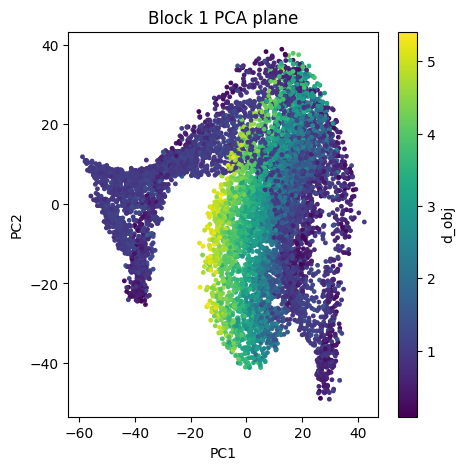

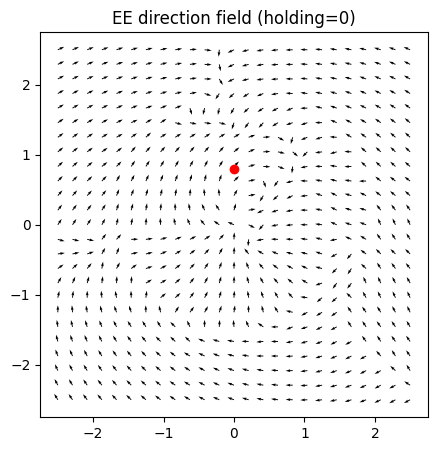

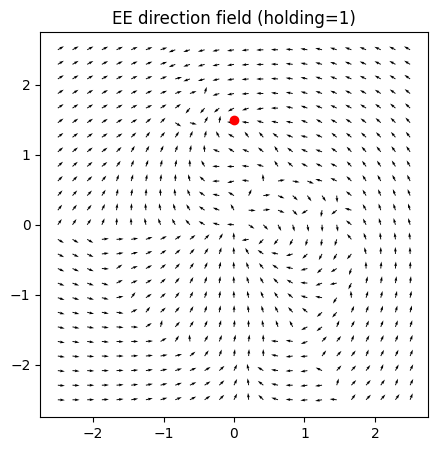

In [ ]:
# -----------------------------------------------------------------------------
# 4. Probes (R²), Ablations, PCA, Quivers
# -----------------------------------------------------------------------------
out, acts = model(test_s.to(device), return_acts=True)
acts = [h.cpu().detach().numpy() for h in acts]

q_now   = test_s[:,:3].numpy()
ee_xy   = forward_kinematics(q_now)
obj_xy  = test_s[:,3:5].numpy()
d_obj   = np.linalg.norm(ee_xy - obj_xy, axis=1, keepdims=True)
bin_xy  = np.broadcast_to(PLACE_BIN, obj_xy.shape)
d_bin   = np.linalg.norm(ee_xy - bin_xy, axis=1, keepdims=True)
hold    = test_s[:,5:6].numpy()

print("\nLayer  R²(d_obj)  R²(d_bin)  R²(hold)")
for i, h in enumerate(acts):
    H   = h.reshape(h.shape[0], -1)
    r2o = LinearRegression().fit(H, d_obj).score(H, d_obj)
    r2b = LinearRegression().fit(H, d_bin).score(H, d_bin)
    r2h = LinearRegression().fit(H, hold).score(H, hold)
    print(f"{i:2d}    {r2o:.3f}      {r2b:.3f}      {r2h:.3f}")

# Ablate top object-distance neuron
h_last = acts[-1].reshape(acts[-1].shape[0], -1)
corrs  = np.corrcoef(h_last.T, d_obj.flatten())[-1, :-1]
top_n  = np.argmax(np.abs(corrs))
print(f"\nAblating neuron {top_n} in final block")
with torch.no_grad():
    sample = test_s.to(device)
    full   = model(sample).cpu()
    def hook(module, inp, out):
        flat = out.view(out.size(0), -1)
        flat[:, top_n] = 0
        return flat.view_as(out)
    handle = model.blocks[-1].register_forward_hook(hook)
    patched = model(sample).cpu()
    handle.remove()
print("Mean |Δ| after ablation =", (patched - full).abs().mean().item())

# PCA on block 1
H1 = acts[1].reshape(acts[1].shape[0], -1)
Z  = PCA(n_components=2).fit_transform(H1)
print("\nPCA alignment:")
for name, data in [("d_obj", d_obj), ("d_bin", d_bin)]:
    for pc in [0,1]:
        r2 = LinearRegression().fit(Z[:, pc:pc+1], data).score(Z[:, pc:pc+1], data)
        print(f"{name}→PC{pc+1}: R²={r2:.3f}")
plt.figure(figsize=(5,5))
plt.scatter(Z[:,0], Z[:,1], c=d_obj.flatten(), s=6, cmap="viridis")
plt.colorbar(label="d_obj")
plt.title("Block 1 PCA plane")
plt.xlabel("PC1"); plt.ylabel("PC2"); plt.show()

# Quiver fields (dtype fixed)
def quiver_field(model, holding=0, n=25):
    xs   = np.linspace(-2.5, 2.5, n, dtype="float32")
    grid = np.stack(list(itertools.product(xs, xs)), axis=0).astype("float32")
    tgt  = np.repeat([[0.0, 0.8]], len(grid), axis=0) if holding==0 else np.repeat([PLACE_BIN], len(grid), axis=0)
    qg    = ik_2link(grid)
    state_np = np.concatenate([
        qg, tgt,
        np.full((len(grid),1), float(holding), dtype="float32")
    ], axis=1)
    state = torch.from_numpy(state_np).float().to(device)
    with torch.no_grad():
        dq = model(state).cpu().numpy()[:, :3]
    ee   = forward_kinematics(qg)
    ee_d = forward_kinematics(qg + dq) - ee
    dirs = ee_d / (np.linalg.norm(ee_d, axis=1, keepdims=True) + 1e-8)
    plt.figure(figsize=(5,5))
    plt.quiver(grid[:,0], grid[:,1], dirs[:,0], dirs[:,1],
               angles='xy', scale_units='xy', scale=10)
    plt.scatter(*([0.0,0.8] if holding==0 else PLACE_BIN), c='red')
    plt.title(f"EE direction field (holding={holding})"); plt.show()

quiver_field(model, holding=0)
quiver_field(model, holding=1)

Tier 6

In [ ]:
import math, random, itertools
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
# =============================================================================
# 1. Kinematics & Data Generation (Tier 3 pick-and-place)
# =============================================================================
L1 = L2 = L3 = 1.0
PLACE_BIN = np.array([0.0, 1.5], dtype="float32")
K_GAIN = 0.5

def forward_kinematics(q):
    q1,q2,q3 = q[...,0], q[...,1], q[...,2]
    x = L1*np.cos(q1) + L2*np.cos(q1+q2) + L3*np.cos(q1+q2+q3)
    y = L1*np.sin(q1) + L2*np.sin(q1+q2) + L3*np.sin(q1+q2+q3)
    return np.stack([x,y], axis=-1)

def ik_2link(xy):
    x,y = xy[...,0], xy[...,1]
    r2   = x**2 + y**2
    cos2 = (r2 - L1*L1 - L2*L2)/(2*L1*L2)
    cos2 = np.clip(cos2, -1.0, 1.0)
    q2   = np.arccos(cos2)
    k1   = L1 + L2*np.cos(q2)
    k2   = L2*np.sin(q2)
    q1   = np.arctan2(y,x) - np.arctan2(k2,k1)
    q3   = np.zeros_like(q1)
    return np.stack([q1,q2,q3], axis=-1).astype("float32")

def one_demo(rng):
    r   = rng.uniform(0.3, L1+L2+L3-0.1)
    phi = rng.uniform(-math.pi, math.pi)
    obj = np.array([r*math.cos(phi), r*math.sin(phi)], dtype="float32")
    holding = rng.integers(0,2)
    target  = obj if holding==0 else PLACE_BIN
    q_tar = ik_2link(target)
    q_now = q_tar + rng.normal(0,0.15,size=3).astype("float32")
    dq    = K_GAIN*(q_tar - q_now)
    grip  = 0.2*(1-holding) - 0.2*holding
    state  = np.concatenate([q_now, obj, [float(holding)]], axis=0)
    action = np.concatenate([dq, [grip,0.0,0.0]], axis=0)
    return state.astype("float32"), action.astype("float32")

def gen_dataset(N, seed):
    rng = np.random.default_rng(seed)
    S,A = zip(*(one_demo(rng) for _ in range(N)))
    return torch.tensor(np.stack(S)).float(), torch.tensor(np.stack(A)).float()

train_s, train_a = gen_dataset(120_000, seed=0)
test_s,  test_a  = gen_dataset(  8_192, seed=1)
print("Dataset shapes:", train_s.shape, train_a.shape)

Dataset shapes: torch.Size([120000, 6]) torch.Size([120000, 6])


In [ ]:
# =============================================================================
# 2. Tier 6 Model: Slot embeddings + per-token heads + self-attention
# =============================================================================
class TransformerBlock(nn.Module):
    def __init__(self, width, n_heads=4):
        super().__init__()
        self.ln1  = nn.LayerNorm(width)
        self.attn = nn.MultiheadAttention(width, n_heads, batch_first=True)
        self.ln2  = nn.LayerNorm(width)
        self.mlp  = nn.Sequential(
            nn.Linear(width, width*4), nn.GELU(), nn.Linear(width*4, width)
        )
    def forward(self,x):
        h     = self.ln1(x)
        att_o,_ = self.attn(h,h,h)
        x     = x + att_o
        h2    = self.ln2(x)
        return x + self.mlp(h2)

class TinyDiT_Tier6(nn.Module):
    def __init__(self, state_dim=1, action_dim=6, tokens=6, width=256, depth=6, heads=4):
        super().__init__()
        self.tokens = tokens
        # per-scalar slot embedding
        self.slot_emb = nn.Parameter(torch.randn(tokens, width) * 0.02)
        # input projection for each scalar
        self.in_proj  = nn.Linear(state_dim, width)
        # attention blocks
        self.blocks   = nn.ModuleList([TransformerBlock(width, heads) for _ in range(depth)])
        # per-token output head mapping width→1
        self.out_heads = nn.ModuleList([nn.Linear(width,1) for _ in range(tokens)])

    def forward(self, x, return_acts=False):
        # x: (B, tokens)
        B = x.shape[0]
        # embed scalars
        h = x.unsqueeze(-1)          # (B, tokens, 1)
        h = self.in_proj(h)          # (B, tokens, width)
        # add slot embeddings
        h = h + self.slot_emb.unsqueeze(0)
        acts = [h]
        # residual self-attention blocks
        for blk in self.blocks:
            h = h + blk(h)
            acts.append(h)
        # per-token output
        out_tokens = []
        for i,head in enumerate(self.out_heads):
            # h[:,i,:] shape (B,width)
            out_tokens.append(head(h[:,i,:]))
        out = torch.cat(out_tokens, dim=-1)  # (B, tokens) = (B,6)
        return (out, acts) if return_acts else out

Epoch 01/50  MSE = 44.092916
Epoch 02/50  MSE = 0.187078
Epoch 03/50  MSE = 0.087049
Epoch 04/50  MSE = 0.045184
Epoch 05/50  MSE = 0.027169
Epoch 06/50  MSE = 0.019616
Epoch 07/50  MSE = 0.150983
Epoch 08/50  MSE = 0.037702
Epoch 09/50  MSE = 0.309638
Epoch 10/50  MSE = 0.094703
Epoch 11/50  MSE = 0.142139
Epoch 12/50  MSE = 0.148401
Epoch 13/50  MSE = 0.346169
Epoch 14/50  MSE = 0.085020
Epoch 15/50  MSE = 0.159339
Epoch 16/50  MSE = 0.125329
Epoch 17/50  MSE = 0.177767
Epoch 18/50  MSE = 0.181658
Epoch 19/50  MSE = 0.246344
Epoch 20/50  MSE = 0.162566
Epoch 21/50  MSE = 0.149669
Epoch 22/50  MSE = 0.121675
Epoch 23/50  MSE = 0.278035
Epoch 24/50  MSE = 0.203531
Epoch 25/50  MSE = 0.023390
Epoch 26/50  MSE = 0.209572
Epoch 27/50  MSE = 0.190321
Epoch 28/50  MSE = 0.055288
Epoch 29/50  MSE = 0.073475
Epoch 30/50  MSE = 0.146059
Epoch 31/50  MSE = 0.201460
Epoch 32/50  MSE = 0.187585
Epoch 33/50  MSE = 0.034906
Epoch 34/50  MSE = 0.089051
Epoch 35/50  MSE = 0.159453
Epoch 36/50  MSE = 

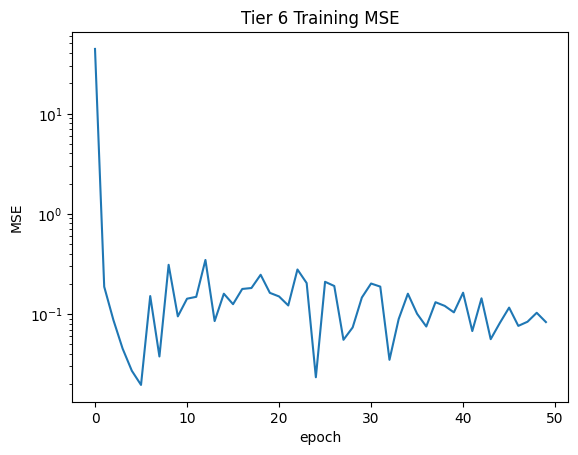

Test MSE = 0.020063234493136406
Epoch 01/20  MSE = 40.220672
Epoch 02/20  MSE = 0.189155
Epoch 03/20  MSE = 0.085427
Epoch 04/20  MSE = 0.043420
Epoch 05/20  MSE = 0.026373
Epoch 06/20  MSE = 0.120131
Epoch 07/20  MSE = 0.121084
Epoch 08/20  MSE = 0.175427
Epoch 09/20  MSE = 0.162675
Epoch 10/20  MSE = 0.152093
Epoch 11/20  MSE = 0.188029
Epoch 12/20  MSE = 0.091428
Epoch 13/20  MSE = 0.203350
Epoch 14/20  MSE = 0.153212
Epoch 15/20  MSE = 0.208626
Epoch 16/20  MSE = 0.086578
Epoch 17/20  MSE = 0.106216
Epoch 18/20  MSE = 0.076669
Epoch 19/20  MSE = 0.238940
Epoch 20/20  MSE = 0.116051
Epoch 01/20  MSE = 40.509454
Epoch 02/20  MSE = 0.212115
Epoch 03/20  MSE = 0.098082
Epoch 04/20  MSE = 0.050154
Epoch 05/20  MSE = 0.130870
Epoch 06/20  MSE = 0.188294
Epoch 07/20  MSE = 0.262537
Epoch 08/20  MSE = 0.151708
Epoch 09/20  MSE = 0.233635
Epoch 10/20  MSE = 0.145862
Epoch 11/20  MSE = 0.184373
Epoch 12/20  MSE = 0.353842
Epoch 13/20  MSE = 0.012275
Epoch 14/20  MSE = 0.157328
Epoch 15/20  M

In [ ]:
# =============================================================================
# 3. Training & Symmetry Test
# =============================================================================
def train(model, s, a, epochs=20, bs=1024, lr=3e-4):
    ds     = TensorDataset(s,a)
    loader = DataLoader(ds, bs, shuffle=True)
    opt    = torch.optim.AdamW(model.parameters(), lr=lr)
    curve  = []
    for ep in range(1, epochs+1):
        total = 0.0
        for bs_s, bs_a in loader:
            bs_s,bs_a = bs_s.to(device), bs_a.to(device)
            pred      = model(bs_s)
            loss      = F.mse_loss(pred, bs_a)
            opt.zero_grad(); loss.backward(); opt.step()
            total    += loss.item()*len(bs_s)
        mse = total/len(ds); curve.append(mse)
        print(f"Epoch {ep:02d}/{epochs}  MSE = {mse:.6f}")
    return curve

def symmetry_test(model_cls, epochs=5):
    torch.manual_seed(0); np.random.seed(0); random.seed(0)
    m1 = model_cls().to(device)
    _ = train(m1, train_s, train_a, epochs=epochs)
    o1 = m1(test_s.to(device)).cpu().detach().numpy().ravel()
    m2 = model_cls().to(device)
    with torch.no_grad(): m2.slot_emb.mul_(-1)  # flip embedding sign
    _ = train(m2, train_s, train_a, epochs=epochs)
    o2 = m2(test_s.to(device)).cpu().detach().numpy().ravel()
    corr = np.corrcoef(o1,o2)[0,1]
    print("Slot-emb sign-flip corr =", corr)

model = TinyDiT_Tier6().to(device)
train_curve = train(model, train_s, train_a, epochs=50)
plt.figure(); plt.plot(train_curve); plt.yscale("log")
plt.title("Tier 6 Training MSE"); plt.xlabel("epoch"); plt.ylabel("MSE"); plt.show()

with torch.no_grad():
    print("Test MSE =", F.mse_loss(model(test_s.to(device)), test_a.to(device)).item())
symmetry_test(TinyDiT_Tier6, epochs=20)


Layer  R²(d_obj)  R²(d_bin)  R²(hold)
 0    0.785      0.807      1.000
 1    0.953      0.951      1.000
 2    0.959      0.960      1.000
 3    0.961      0.960      1.000
 4    0.961      0.961      1.000
 5    0.961      0.961      1.000
 6    0.961      0.961      1.000

Ablating neuron 1427 in final block
Mean |Δ| after ablation = 0.007874841801822186

PCA alignment:
d_obj→PC1: R²=0.012
d_obj→PC2: R²=0.015
d_bin→PC1: R²=0.346
d_bin→PC2: R²=0.007


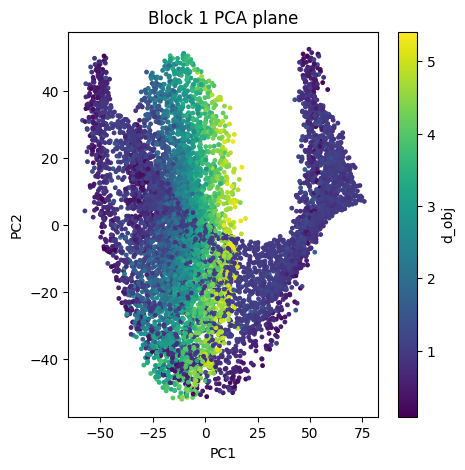

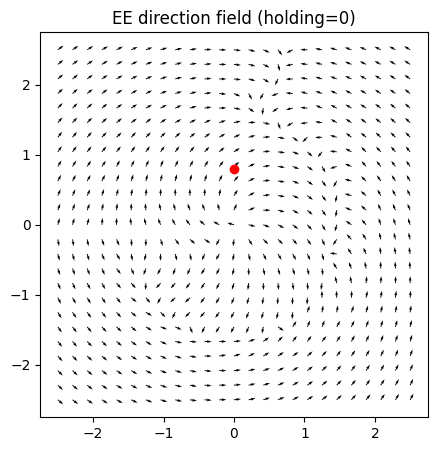

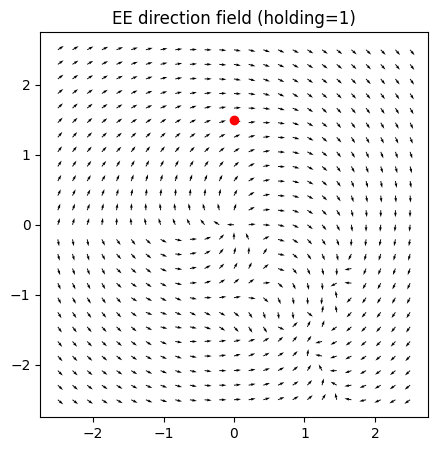

In [ ]:
# -----------------------------------------------------------------------------
# 4. Probes (R²), Ablations, PCA, Quivers
# -----------------------------------------------------------------------------
out, acts = model(test_s.to(device), return_acts=True)
acts = [h.cpu().detach().numpy() for h in acts]

q_now   = test_s[:,:3].numpy()
ee_xy   = forward_kinematics(q_now)
obj_xy  = test_s[:,3:5].numpy()
d_obj   = np.linalg.norm(ee_xy - obj_xy, axis=1, keepdims=True)
bin_xy  = np.broadcast_to(PLACE_BIN, obj_xy.shape)
d_bin   = np.linalg.norm(ee_xy - bin_xy, axis=1, keepdims=True)
hold    = test_s[:,5:6].numpy()

print("\nLayer  R²(d_obj)  R²(d_bin)  R²(hold)")
for i, h in enumerate(acts):
    H   = h.reshape(h.shape[0], -1)
    r2o = LinearRegression().fit(H, d_obj).score(H, d_obj)
    r2b = LinearRegression().fit(H, d_bin).score(H, d_bin)
    r2h = LinearRegression().fit(H, hold).score(H, hold)
    print(f"{i:2d}    {r2o:.3f}      {r2b:.3f}      {r2h:.3f}")

# Ablate top object-distance neuron
h_last = acts[-1].reshape(acts[-1].shape[0], -1)
corrs  = np.corrcoef(h_last.T, d_obj.flatten())[-1, :-1]
top_n  = np.argmax(np.abs(corrs))
print(f"\nAblating neuron {top_n} in final block")
with torch.no_grad():
    sample = test_s.to(device)
    full   = model(sample).cpu()
    def hook(module, inp, out):
        flat = out.view(out.size(0), -1)
        flat[:, top_n] = 0
        return flat.view_as(out)
    handle = model.blocks[-1].register_forward_hook(hook)
    patched = model(sample).cpu()
    handle.remove()
print("Mean |Δ| after ablation =", (patched - full).abs().mean().item())

# PCA on block 1
H1 = acts[1].reshape(acts[1].shape[0], -1)
Z  = PCA(n_components=2).fit_transform(H1)
print("\nPCA alignment:")
for name, data in [("d_obj", d_obj), ("d_bin", d_bin)]:
    for pc in [0,1]:
        r2 = LinearRegression().fit(Z[:, pc:pc+1], data).score(Z[:, pc:pc+1], data)
        print(f"{name}→PC{pc+1}: R²={r2:.3f}")
plt.figure(figsize=(5,5))
plt.scatter(Z[:,0], Z[:,1], c=d_obj.flatten(), s=6, cmap="viridis")
plt.colorbar(label="d_obj")
plt.title("Block 1 PCA plane")
plt.xlabel("PC1"); plt.ylabel("PC2"); plt.show()

# Quiver fields (dtype fixed)
def quiver_field(model, holding=0, n=25):
    xs   = np.linspace(-2.5, 2.5, n, dtype="float32")
    grid = np.stack(list(itertools.product(xs, xs)), axis=0).astype("float32")
    tgt  = np.repeat([[0.0, 0.8]], len(grid), axis=0) if holding==0 else np.repeat([PLACE_BIN], len(grid), axis=0)
    qg    = ik_2link(grid)
    state_np = np.concatenate([
        qg, tgt,
        np.full((len(grid),1), float(holding), dtype="float32")
    ], axis=1)
    state = torch.from_numpy(state_np).float().to(device)
    with torch.no_grad():
        dq = model(state).cpu().numpy()[:, :3]
    ee   = forward_kinematics(qg)
    ee_d = forward_kinematics(qg + dq) - ee
    dirs = ee_d / (np.linalg.norm(ee_d, axis=1, keepdims=True) + 1e-8)
    plt.figure(figsize=(5,5))
    plt.quiver(grid[:,0], grid[:,1], dirs[:,0], dirs[:,1],
               angles='xy', scale_units='xy', scale=10)
    plt.scatter(*([0.0,0.8] if holding==0 else PLACE_BIN), c='red')
    plt.title(f"EE direction field (holding={holding})"); plt.show()

quiver_field(model, holding=0)
quiver_field(model, holding=1)

Tier 7

In [ ]:
import math, random, itertools
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
# =============================================================================
# 1.  Kinematics & Data Generation (Tier 3 pick-and-place)
# =============================================================================
L1 = L2 = L3 = 1.0
PLACE_BIN = np.array([0.0, 1.5], dtype="float32")
K_GAIN    = 0.5

def forward_kinematics(q):
    q1,q2,q3 = q[...,0], q[...,1], q[...,2]
    x = L1*np.cos(q1) + L2*np.cos(q1+q2) + L3*np.cos(q1+q2+q3)
    y = L1*np.sin(q1) + L2*np.sin(q1+q2) + L3*np.sin(q1+q2+q3)
    return np.stack([x,y], axis=-1)

def ik_2link(xy):
    x,y = xy[...,0], xy[...,1]
    r2 = x*x + y*y
    cos2 = (r2 - L1*L1 - L2*L2)/(2*L1*L2)
    cos2 = np.clip(cos2, -1, 1)
    q2 = np.arccos(cos2)
    k1 = L1 + L2*np.cos(q2)
    k2 = L2*np.sin(q2)
    q1 = np.arctan2(y, x) - np.arctan2(k2, k1)
    q3 = np.zeros_like(q1)
    return np.stack([q1,q2,q3], axis=-1).astype("float32")

def one_demo(rng):
    r   = rng.uniform(0.3, L1+L2+L3 - 0.1)
    phi = rng.uniform(-math.pi, math.pi)
    obj = np.array([r*math.cos(phi), r*math.sin(phi)], dtype="float32")
    holding = rng.integers(0,2)
    target  = obj if holding==0 else PLACE_BIN
    q_tar = ik_2link(target)
    q_now = q_tar + rng.normal(0, 0.15, size=3).astype("float32")
    dq    = K_GAIN*(q_tar - q_now)
    grip  = 0.2*(1-holding) - 0.2*holding
    state  = np.concatenate([q_now, obj, [float(holding)]], axis=0)
    action = np.concatenate([dq, [grip,0.0,0.0]], axis=0)
    return state.astype("float32"), action.astype("float32")

def gen_dataset(N, seed):
    rng = np.random.default_rng(seed)
    S, A = zip(*(one_demo(rng) for _ in range(N)))
    return torch.tensor(np.stack(S)).float(), torch.tensor(np.stack(A)).float()

train_s, train_a = gen_dataset(120_000, seed=0)
test_s,  test_a  = gen_dataset(  8_192, seed=1)
print("Dataset:", train_s.shape, train_a.shape)

Dataset: torch.Size([120000, 6]) torch.Size([120000, 6])


In [ ]:
# =============================================================================
# 2.  Tier 7 model: slot-tied input + self-attention + per-token heads
# =============================================================================
class TransformerBlock(nn.Module):
    def __init__(self, width, n_heads=4):
        super().__init__()
        self.ln1  = nn.LayerNorm(width)
        self.attn = nn.MultiheadAttention(width, n_heads, batch_first=True)
        self.ln2  = nn.LayerNorm(width)
        self.mlp  = nn.Sequential(
            nn.Linear(width, width*4), nn.GELU(), nn.Linear(width*4, width)
        )
    def forward(self, x):
        h, _ = self.attn(self.ln1(x), self.ln1(x), self.ln1(x))
        x = x + h
        return x + self.mlp(self.ln2(x))

class TinyDiT_Tier7(nn.Module):
    def __init__(self,
                 tokens=6,
                 state_dim=1,
                 width=256,
                 depth=6,
                 heads=4):
        super().__init__()
        self.tokens   = tokens
        # slot-tied input weights:
        # h[b,i,:] = x[b,i] * slot_emb[i]
        self.slot_emb = nn.Parameter(torch.randn(tokens, width) * 0.02)
        # transformer blocks
        self.blocks   = nn.ModuleList([
            TransformerBlock(width, heads) for _ in range(depth)
        ])
        # per-token output heads (width → 1 scalar)
        self.out_heads = nn.ModuleList([
            nn.Linear(width, 1) for _ in range(tokens)
        ])

    def forward(self, x, return_acts=False):
        # x: (B, tokens)
        B = x.size(0)
        # input: scale slot embeddings by the scalar value
        h = x.unsqueeze(-1) * self.slot_emb.unsqueeze(0)  # (B, toks, width)
        acts = [h]
        # residual attention blocks
        for blk in self.blocks:
            h = h + blk(h)
            acts.append(h)
        # per-token heads
        out = torch.cat([head(h[:,i,:]) for i,head in enumerate(self.out_heads)],
                        dim=-1)
        return (out, acts) if return_acts else out

In [ ]:
# =============================================================================
# 3. Training & symmetry test
# =============================================================================
def train(model, s, a, epochs=20, bs=1024, lr=3e-4):
    ds     = TensorDataset(s, a)
    loader = DataLoader(ds, bs, shuffle=True)
    opt    = torch.optim.AdamW(model.parameters(), lr=lr)
    curve  = []
    for ep in range(1, epochs+1):
        tot=0.0
        for bs_s, bs_a in loader:
            bs_s,bs_a = bs_s.to(device), bs_a.to(device)
            pred      = model(bs_s)
            loss      = F.mse_loss(pred, bs_a)
            opt.zero_grad(); loss.backward(); opt.step()
            tot += loss.item()*len(bs_s)
        mse = tot/len(ds)
        curve.append(mse)
        print(f"Epoch {ep:02d}/{epochs}  MSE = {mse:.6f}")
    return curve

def symmetry_test(model_cls, epochs=5):
    torch.manual_seed(0); np.random.seed(0); random.seed(0)
    m1 = model_cls().to(device)
    _ = train(m1, train_s, train_a, epochs=epochs)
    o1 = m1(test_s.to(device)).cpu().detach().numpy().ravel()
    m2 = model_cls().to(device)
    # flip slot embeddings (ties input weights too)
    with torch.no_grad(): m2.slot_emb.mul_(-1)
    _ = train(m2, train_s, train_a, epochs=epochs)
    o2 = m2(test_s.to(device)).cpu().detach().numpy().ravel()
    corr = np.corrcoef(o1, o2)[0,1]
    print("Slot-emb sign-flip corr =", corr)

model = TinyDiT_Tier7().to(device)
train_curve = train(model, train_s, train_a, epochs=50)
plt.semilogy(train_curve, label="train MSE")
plt.title("Tier 7 Training MSE")
plt.xlabel("epoch"); plt.ylabel("MSE"); plt.legend(); plt.show()

with torch.no_grad():
    print("Test MSE =", F.mse_loss(model(test_s.to(device)), test_a.to(device)).item())
symmetry_test(TinyDiT_Tier7, epochs=15)

Epoch 01/50  MSE = 6.485801
Epoch 02/50  MSE = 0.014768
Epoch 03/50  MSE = 0.037562
Epoch 04/50  MSE = 0.066574
Epoch 05/50  MSE = 0.021677
Epoch 06/50  MSE = 0.017234
Epoch 07/50  MSE = 0.071381
Epoch 08/50  MSE = 0.003326
Epoch 09/50  MSE = 0.013388
Epoch 10/50  MSE = 0.043079
Epoch 11/50  MSE = 0.001816
Epoch 12/50  MSE = 0.009110
Epoch 13/50  MSE = 0.007608
Epoch 14/50  MSE = 0.008884
Epoch 15/50  MSE = 0.008387
Epoch 16/50  MSE = 0.009702
Epoch 17/50  MSE = 0.016549
Epoch 18/50  MSE = 0.006392
Epoch 19/50  MSE = 0.002161
Epoch 20/50  MSE = 0.030097
Epoch 21/50  MSE = 0.001065
Epoch 22/50  MSE = 0.007520
Epoch 23/50  MSE = 0.005690
Epoch 24/50  MSE = 0.009987
Epoch 25/50  MSE = 0.003508



Layer  R²(d_obj)  R²(d_bin)  R²(hold)
 0    0.785      0.807      1.000
 1    0.973      0.986      1.000
 2    0.981      0.989      1.000
 3    0.985      0.991      1.000
 4    0.986      0.992      1.000
 5    0.987      0.992      1.000
 6    0.987      0.992      1.000

Ablating neuron 1523 in final block
Mean |Δ| after ablation = 0.003029170213267207

PCA alignment:
d_obj→PC1: R²=0.001
d_obj→PC2: R²=0.001
d_bin→PC1: R²=0.029
d_bin→PC2: R²=0.301


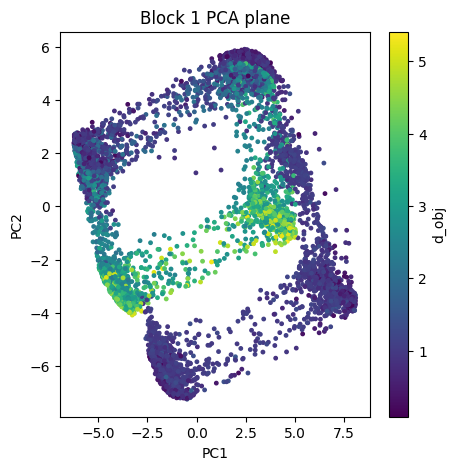

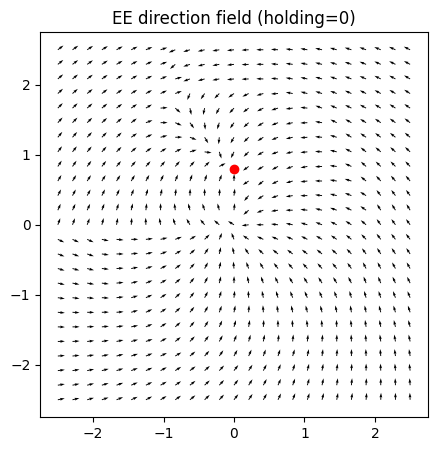

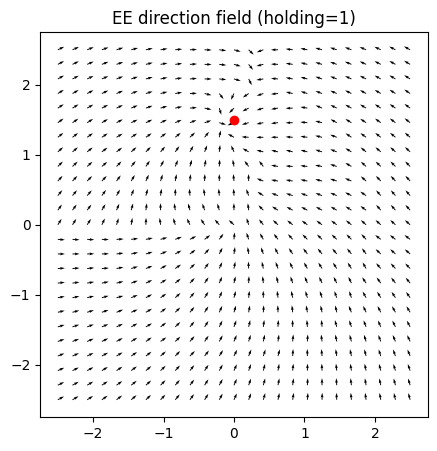

In [ ]:
# -----------------------------------------------------------------------------
# 4. Probes (R²), Ablations, PCA, Quivers
# -----------------------------------------------------------------------------
out, acts = model(test_s.to(device), return_acts=True)
acts = [h.cpu().detach().numpy() for h in acts]

q_now   = test_s[:,:3].numpy()
ee_xy   = forward_kinematics(q_now)
obj_xy  = test_s[:,3:5].numpy()
d_obj   = np.linalg.norm(ee_xy - obj_xy, axis=1, keepdims=True)
bin_xy  = np.broadcast_to(PLACE_BIN, obj_xy.shape)
d_bin   = np.linalg.norm(ee_xy - bin_xy, axis=1, keepdims=True)
hold    = test_s[:,5:6].numpy()

print("\nLayer  R²(d_obj)  R²(d_bin)  R²(hold)")
for i, h in enumerate(acts):
    H   = h.reshape(h.shape[0], -1)
    r2o = LinearRegression().fit(H, d_obj).score(H, d_obj)
    r2b = LinearRegression().fit(H, d_bin).score(H, d_bin)
    r2h = LinearRegression().fit(H, hold).score(H, hold)
    print(f"{i:2d}    {r2o:.3f}      {r2b:.3f}      {r2h:.3f}")

# Ablate top object-distance neuron
h_last = acts[-1].reshape(acts[-1].shape[0], -1)
corrs  = np.corrcoef(h_last.T, d_obj.flatten())[-1, :-1]
top_n  = np.argmax(np.abs(corrs))
print(f"\nAblating neuron {top_n} in final block")
with torch.no_grad():
    sample = test_s.to(device)
    full   = model(sample).cpu()
    def hook(module, inp, out):
        flat = out.view(out.size(0), -1)
        flat[:, top_n] = 0
        return flat.view_as(out)
    handle = model.blocks[-1].register_forward_hook(hook)
    patched = model(sample).cpu()
    handle.remove()
print("Mean |Δ| after ablation =", (patched - full).abs().mean().item())

# PCA on block 1
H1 = acts[1].reshape(acts[1].shape[0], -1)
Z  = PCA(n_components=2).fit_transform(H1)
print("\nPCA alignment:")
for name, data in [("d_obj", d_obj), ("d_bin", d_bin)]:
    for pc in [0,1]:
        r2 = LinearRegression().fit(Z[:, pc:pc+1], data).score(Z[:, pc:pc+1], data)
        print(f"{name}→PC{pc+1}: R²={r2:.3f}")
plt.figure(figsize=(5,5))
plt.scatter(Z[:,0], Z[:,1], c=d_obj.flatten(), s=6, cmap="viridis")
plt.colorbar(label="d_obj")
plt.title("Block 1 PCA plane")
plt.xlabel("PC1"); plt.ylabel("PC2"); plt.show()

# Quiver fields (dtype fixed)
def quiver_field(model, holding=0, n=25):
    xs   = np.linspace(-2.5, 2.5, n, dtype="float32")
    grid = np.stack(list(itertools.product(xs, xs)), axis=0).astype("float32")
    tgt  = np.repeat([[0.0, 0.8]], len(grid), axis=0) if holding==0 else np.repeat([PLACE_BIN], len(grid), axis=0)
    qg    = ik_2link(grid)
    state_np = np.concatenate([
        qg, tgt,
        np.full((len(grid),1), float(holding), dtype="float32")
    ], axis=1)
    state = torch.from_numpy(state_np).float().to(device)
    with torch.no_grad():
        dq = model(state).cpu().numpy()[:, :3]
    ee   = forward_kinematics(qg)
    ee_d = forward_kinematics(qg + dq) - ee
    dirs = ee_d / (np.linalg.norm(ee_d, axis=1, keepdims=True) + 1e-8)
    plt.figure(figsize=(5,5))
    plt.quiver(grid[:,0], grid[:,1], dirs[:,0], dirs[:,1],
               angles='xy', scale_units='xy', scale=10)
    plt.scatter(*([0.0,0.8] if holding==0 else PLACE_BIN), c='red')
    plt.title(f"EE direction field (holding={holding})"); plt.show()

quiver_field(model, holding=0)
quiver_field(model, holding=1)

Tier 8

In [ ]:
import math, random, itertools
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA

device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
# -----------------------------------------------------------------------------
# 1.  Kinematics & Data Generation (same as before)
# -----------------------------------------------------------------------------
L1 = L2 = L3 = 1.0
PLACE_BIN = np.array([0.0, 1.5], dtype="float32")
K_GAIN    = 0.5

def forward_kinematics(q):
    q1,q2,q3 = q[...,0], q[...,1], q[...,2]
    x = L1*np.cos(q1) + L2*np.cos(q1+q2) + L3*np.cos(q1+q2+q3)
    y = L1*np.sin(q1) + L2*np.sin(q1+q2) + L3*np.sin(q1+q2+q3)
    return np.stack([x,y], axis=-1)

def ik_2link(xy):
    x,y = xy[...,0], xy[...,1]
    r2 = x**2 + y**2
    cos2 = (r2 - L1*L1 - L2*L2)/(2*L1*L2)
    cos2 = np.clip(cos2, -1, 1)
    q2   = np.arccos(cos2)
    k1   = L1+L2*np.cos(q2)
    k2   = L2*np.sin(q2)
    q1   = np.arctan2(y,x) - np.arctan2(k2,k1)
    q3   = np.zeros_like(q1)
    return np.stack([q1,q2,q3], axis=-1).astype("float32")

def one_demo(rng):
    r   = rng.uniform(0.3, L1+L2+L3-0.1)
    phi = rng.uniform(-math.pi, math.pi)
    obj = np.array([r*math.cos(phi), r*math.sin(phi)], dtype="float32")
    holding = rng.integers(0,2)
    target  = obj if holding==0 else PLACE_BIN
    q_tar = ik_2link(target)
    q_now = q_tar + rng.normal(0,0.15,size=3).astype("float32")
    dq    = K_GAIN*(q_tar - q_now)
    grip  = 0.2*(1-holding) - 0.2*holding
    state  = np.concatenate([q_now, obj, [float(holding)]], axis=0)
    action = np.concatenate([dq, [grip,0.0,0.0]], axis=0)
    return state.astype("float32"), action.astype("float32")

def gen_dataset(N, seed):
    rng = np.random.default_rng(seed)
    S,A = zip(*(one_demo(rng) for _ in range(N)))
    return torch.tensor(np.stack(S)).float(), torch.tensor(np.stack(A)).float()

train_s, train_a = gen_dataset(120_000, seed=0)
test_s,  test_a  = gen_dataset(  8_192, seed=1)
print("Dataset shapes:", train_s.shape, train_a.shape)

Dataset shapes: torch.Size([120000, 6]) torch.Size([120000, 6])


In [ ]:
# -----------------------------------------------------------------------------
# 2.  Tier 8 Model: slot-input + self-attn + per-token heads + attn capture
# -----------------------------------------------------------------------------
class TransformerBlock(nn.Module):
    def __init__(self, width, n_heads=4):
        super().__init__()
        self.ln1  = nn.LayerNorm(width)
        self.attn = nn.MultiheadAttention(width, n_heads, batch_first=True)
        self.ln2  = nn.LayerNorm(width)
        self.mlp  = nn.Sequential(
            nn.Linear(width, width*4),
            nn.GELU(),
            nn.Linear(width*4, width)
        )
        self.last_attn = None

    def forward(self, x):
        # query/key/value all = ln1(x)
        qkv = self.ln1(x)
        # need attention weights
        out, attn_w = self.attn(qkv, qkv, qkv,
                                need_weights=True,
                                average_attn_weights=False)
        # attn_w: (B, heads, tokens, tokens)
        self.last_attn = attn_w
        x = x + out
        return x + self.mlp(self.ln2(x))

class TinyDiT_Tier8(nn.Module):
    def __init__(self, tokens=6, width=256, depth=6, heads=4):
        super().__init__()
        self.tokens    = tokens
        self.slot_emb  = nn.Parameter(torch.randn(tokens, width)*0.02)
        self.blocks    = nn.ModuleList([
            TransformerBlock(width, heads) for _ in range(depth)
        ])
        self.out_heads = nn.ModuleList([
            nn.Linear(width, 1) for _ in range(tokens)
        ])

    def forward(self, x, return_acts=False):
        # x: (B, tokens)
        B = x.size(0)
        # slot-tied input projection
        h = x.unsqueeze(-1) * self.slot_emb.unsqueeze(0)
        acts = [h]
        for blk in self.blocks:
            h = blk(h)
            acts.append(h)
        # per-token output
        out = torch.cat([head(h[:,i,:]) for i,head in enumerate(self.out_heads)],
                        dim=-1)
        return (out, acts) if return_acts else out

Epoch 01/50  MSE = 0.010824
Epoch 02/50  MSE = 0.001780
Epoch 03/50  MSE = 0.001617
Epoch 04/50  MSE = 0.001529
Epoch 05/50  MSE = 0.001460
Epoch 06/50  MSE = 0.001346
Epoch 07/50  MSE = 0.001280
Epoch 08/50  MSE = 0.000985
Epoch 09/50  MSE = 0.000913
Epoch 10/50  MSE = 0.000747
Epoch 11/50  MSE = 0.000698
Epoch 12/50  MSE = 0.000644
Epoch 13/50  MSE = 0.000670
Epoch 14/50  MSE = 0.000617
Epoch 15/50  MSE = 0.000546
Epoch 16/50  MSE = 0.000478
Epoch 17/50  MSE = 0.000498
Epoch 18/50  MSE = 0.000410
Epoch 19/50  MSE = 0.000439
Epoch 20/50  MSE = 0.000372
Epoch 21/50  MSE = 0.000384
Epoch 22/50  MSE = 0.000318
Epoch 23/50  MSE = 0.000306
Epoch 24/50  MSE = 0.000306
Epoch 25/50  MSE = 0.000272
Epoch 26/50  MSE = 0.000250
Epoch 27/50  MSE = 0.000223
Epoch 28/50  MSE = 0.000257
Epoch 29/50  MSE = 0.000217
Epoch 30/50  MSE = 0.000205
Epoch 31/50  MSE = 0.000185
Epoch 32/50  MSE = 0.000187
Epoch 33/50  MSE = 0.000180
Epoch 34/50  MSE = 0.000185
Epoch 35/50  MSE = 0.000162
Epoch 36/50  MSE = 0

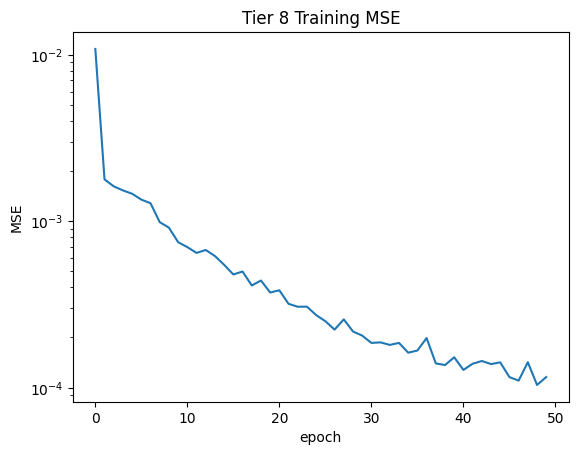

Test MSE = 0.00011040761455660686
Epoch 01/15  MSE = 0.014387
Epoch 02/15  MSE = 0.001846
Epoch 03/15  MSE = 0.001628
Epoch 04/15  MSE = 0.001530
Epoch 05/15  MSE = 0.001370
Epoch 06/15  MSE = 0.001289
Epoch 07/15  MSE = 0.001156
Epoch 08/15  MSE = 0.000919
Epoch 09/15  MSE = 0.000860
Epoch 10/15  MSE = 0.000738
Epoch 11/15  MSE = 0.000647
Epoch 12/15  MSE = 0.000710
Epoch 13/15  MSE = 0.000567
Epoch 14/15  MSE = 0.000564
Epoch 15/15  MSE = 0.000621
Epoch 01/15  MSE = 0.015407
Epoch 02/15  MSE = 0.001810
Epoch 03/15  MSE = 0.001635
Epoch 04/15  MSE = 0.001511
Epoch 05/15  MSE = 0.001416
Epoch 06/15  MSE = 0.001316
Epoch 07/15  MSE = 0.001182
Epoch 08/15  MSE = 0.001134
Epoch 09/15  MSE = 0.000958
Epoch 10/15  MSE = 0.000843
Epoch 11/15  MSE = 0.000705
Epoch 12/15  MSE = 0.000649
Epoch 13/15  MSE = 0.000620
Epoch 14/15  MSE = 0.000588
Epoch 15/15  MSE = 0.000604
Slot-emb sign-flip corr = 0.9858172035891568


In [ ]:
# -----------------------------------------------------------------------------
# 3.  Training loop with auxiliary PD loss + symmetry test
# -----------------------------------------------------------------------------
def train(model, s, a, epochs=20, bs=1024, lr=5e-5, α_pd=0.1):
    ds     = TensorDataset(s, a)
    loader = DataLoader(ds, bs, shuffle=True)
    opt    = torch.optim.AdamW(model.parameters(), lr=lr)
    curve  = []
    for ep in range(1, epochs+1):
        total = 0.0
        for bs_s, bs_a in loader:
            bs_s, bs_a = bs_s.to(device), bs_a.to(device)
            pred        = model(bs_s)
            # main MSE
            loss_main   = F.mse_loss(pred, bs_a)
            # compute analytic PD baseline on Δq only
            st_np = bs_s.cpu().numpy()
            q_now = st_np[:,:3]
            obj_xy= st_np[:,3:5]
            hold  = st_np[:,5].astype(int)
            # get q_tar per sample
            targ_pts = np.where(hold[:,None]==0,
                                obj_xy,
                                np.broadcast_to(PLACE_BIN, obj_xy.shape))
            q_tar    = ik_2link(targ_pts)
            pd_baseline = torch.tensor(K_GAIN*(q_tar - q_now),
                                      device=device)
            # pd_pred = first 3 dims of pred
            pd_pred = pred[:,:3]
            loss_pd = F.mse_loss(pd_pred, pd_baseline)
            loss    = loss_main + α_pd * loss_pd
            opt.zero_grad(); loss.backward(); opt.step()
            total += loss_main.item()*len(bs_s)
        mse = total/len(ds)
        curve.append(mse)
        print(f"Epoch {ep:02d}/{epochs}  MSE = {mse:.6f}")
    return curve

def symmetry_test(model_cls, epochs=5):
    torch.manual_seed(0); np.random.seed(0); random.seed(0)
    m1 = model_cls().to(device)
    _  = train(m1, train_s, train_a, epochs=epochs)
    o1 = m1(test_s.to(device)).cpu().detach().numpy().ravel()
    m2 = model_cls().to(device)
    with torch.no_grad(): m2.slot_emb.mul_(-1)
    _  = train(m2, train_s, train_a, epochs=epochs)
    o2 = m2(test_s.to(device)).cpu().detach().numpy().ravel()
    print("Slot-emb sign-flip corr =",
          np.corrcoef(o1, o2)[0,1])

model = TinyDiT_Tier8().to(device)
train_curve = train(model, train_s, train_a, epochs=50, α_pd=0.1)
plt.semilogy(train_curve)
plt.title("Tier 8 Training MSE")
plt.xlabel("epoch"); plt.ylabel("MSE"); plt.show()

with torch.no_grad():
    print("Test MSE =", F.mse_loss(model(test_s.to(device)), test_a.to(device)).item())
symmetry_test(TinyDiT_Tier8, epochs=15)

In [ ]:
# -----------------------------------------------------------------------------
# 4.  Head-wise probing of attention gating
# -----------------------------------------------------------------------------
model.eval()
# run a batch so blocks.last_attn is populated
with torch.no_grad():
    _ = model(test_s[:1024].to(device))

holding_idx = 5
obj_idx     = 3
bin_idx     = 4

for b, blk in enumerate(model.blocks):
    attn = blk.last_attn  # (B, heads, tokens, tokens)
    # average over batch
    avg = attn.mean(dim=0)  # (heads, tokens, tokens)
    # for each head, extract weight from holding→object and holding→bin
    w_obj = avg[:, holding_idx, obj_idx].cpu().numpy()
    w_bin = avg[:, holding_idx, bin_idx].cpu().numpy()
    print(f"Block {b:02d}: hold→obj per-head:", np.round(w_obj,3))
    print(f"          hold→bin per-head:", np.round(w_bin,3))

Block 00: hold→obj per-head: [0.152 0.132 0.17  0.177]
          hold→bin per-head: [0.149 0.128 0.169 0.186]
Block 01: hold→obj per-head: [0.201 0.274 0.168 0.15 ]
          hold→bin per-head: [0.185 0.196 0.24  0.163]
Block 02: hold→obj per-head: [0.275 0.225 0.21  0.164]
          hold→bin per-head: [0.203 0.153 0.14  0.167]
Block 03: hold→obj per-head: [0.192 0.188 0.181 0.178]
          hold→bin per-head: [0.17  0.2   0.159 0.16 ]
Block 04: hold→obj per-head: [0.152 0.153 0.164 0.174]
          hold→bin per-head: [0.17  0.164 0.165 0.177]
Block 05: hold→obj per-head: [0.177 0.178 0.161 0.176]
          hold→bin per-head: [0.185 0.163 0.155 0.161]



Layer  R²(d_obj)  R²(d_bin)  R²(hold)
 0    0.785      0.807      1.000
 1    0.978      0.988      1.000
 2    0.986      0.993      1.000
 3    0.986      0.993      1.000
 4    0.988      0.994      1.000
 5    0.989      0.995      1.000
 6    0.989      0.995      1.000

Ablating neuron 225 in final block
Mean |Δ| after ablation = 0.0032700796145945787

PCA alignment:
d_obj→PC1: R²=0.067
d_obj→PC2: R²=0.081
d_bin→PC1: R²=0.002
d_bin→PC2: R²=0.573


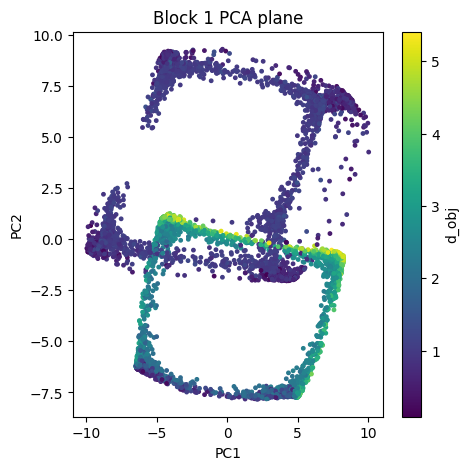

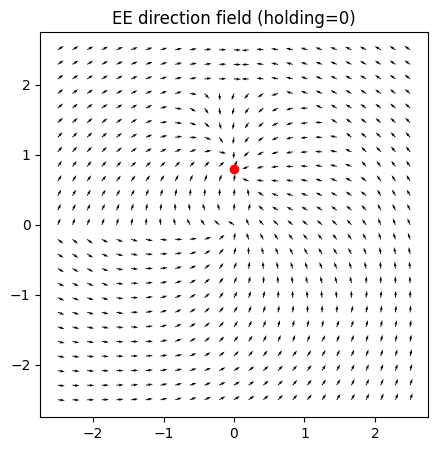

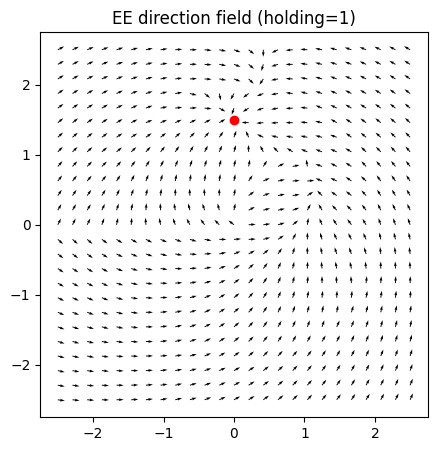

In [ ]:
# -----------------------------------------------------------------------------
# 4. Probes (R²), Ablations, PCA, Quivers
# -----------------------------------------------------------------------------
out, acts = model(test_s.to(device), return_acts=True)
acts = [h.cpu().detach().numpy() for h in acts]

q_now   = test_s[:,:3].numpy()
ee_xy   = forward_kinematics(q_now)
obj_xy  = test_s[:,3:5].numpy()
d_obj   = np.linalg.norm(ee_xy - obj_xy, axis=1, keepdims=True)
bin_xy  = np.broadcast_to(PLACE_BIN, obj_xy.shape)
d_bin   = np.linalg.norm(ee_xy - bin_xy, axis=1, keepdims=True)
hold    = test_s[:,5:6].numpy()

print("\nLayer  R²(d_obj)  R²(d_bin)  R²(hold)")
for i, h in enumerate(acts):
    H   = h.reshape(h.shape[0], -1)
    r2o = LinearRegression().fit(H, d_obj).score(H, d_obj)
    r2b = LinearRegression().fit(H, d_bin).score(H, d_bin)
    r2h = LinearRegression().fit(H, hold).score(H, hold)
    print(f"{i:2d}    {r2o:.3f}      {r2b:.3f}      {r2h:.3f}")

# Ablate top object-distance neuron
h_last = acts[-1].reshape(acts[-1].shape[0], -1)
corrs  = np.corrcoef(h_last.T, d_obj.flatten())[-1, :-1]
top_n  = np.argmax(np.abs(corrs))
print(f"\nAblating neuron {top_n} in final block")
with torch.no_grad():
    sample = test_s.to(device)
    full   = model(sample).cpu()
    def hook(module, inp, out):
        flat = out.view(out.size(0), -1)
        flat[:, top_n] = 0
        return flat.view_as(out)
    handle = model.blocks[-1].register_forward_hook(hook)
    patched = model(sample).cpu()
    handle.remove()
print("Mean |Δ| after ablation =", (patched - full).abs().mean().item())

# PCA on block 1
H1 = acts[1].reshape(acts[1].shape[0], -1)
Z  = PCA(n_components=2).fit_transform(H1)
print("\nPCA alignment:")
for name, data in [("d_obj", d_obj), ("d_bin", d_bin)]:
    for pc in [0,1]:
        r2 = LinearRegression().fit(Z[:, pc:pc+1], data).score(Z[:, pc:pc+1], data)
        print(f"{name}→PC{pc+1}: R²={r2:.3f}")
plt.figure(figsize=(5,5))
plt.scatter(Z[:,0], Z[:,1], c=d_obj.flatten(), s=6, cmap="viridis")
plt.colorbar(label="d_obj")
plt.title("Block 1 PCA plane")
plt.xlabel("PC1"); plt.ylabel("PC2"); plt.show()

# Quiver fields (dtype fixed)
def quiver_field(model, holding=0, n=25):
    xs   = np.linspace(-2.5, 2.5, n, dtype="float32")
    grid = np.stack(list(itertools.product(xs, xs)), axis=0).astype("float32")
    tgt  = np.repeat([[0.0, 0.8]], len(grid), axis=0) if holding==0 else np.repeat([PLACE_BIN], len(grid), axis=0)
    qg    = ik_2link(grid)
    state_np = np.concatenate([
        qg, tgt,
        np.full((len(grid),1), float(holding), dtype="float32")
    ], axis=1)
    state = torch.from_numpy(state_np).float().to(device)
    with torch.no_grad():
        dq = model(state).cpu().numpy()[:, :3]
    ee   = forward_kinematics(qg)
    ee_d = forward_kinematics(qg + dq) - ee
    dirs = ee_d / (np.linalg.norm(ee_d, axis=1, keepdims=True) + 1e-8)
    plt.figure(figsize=(5,5))
    plt.quiver(grid[:,0], grid[:,1], dirs[:,0], dirs[:,1],
               angles='xy', scale_units='xy', scale=10)
    plt.scatter(*([0.0,0.8] if holding==0 else PLACE_BIN), c='red')
    plt.title(f"EE direction field (holding={holding})"); plt.show()

quiver_field(model, holding=0)
quiver_field(model, holding=1)

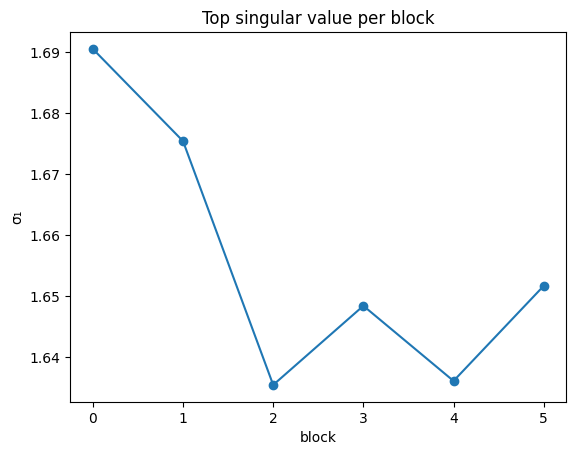

In [ ]:
# -------------------------------------------------------------------------------
# 1. Spectral Analysis
# -------------------------------------------------------------------------------
def plot_block_spectra(model):
    specs=[]
    for blk in model.blocks:
        W = blk.mlp[0].weight.detach().cpu().numpy()
        sv = np.linalg.svd(W, compute_uv=False)[0]
        specs.append(sv)
    plt.plot(specs,'o-')
    plt.title("Top singular value per block"); plt.xlabel("block"); plt.ylabel("σ₁")
    plt.show()

plot_block_spectra(model)

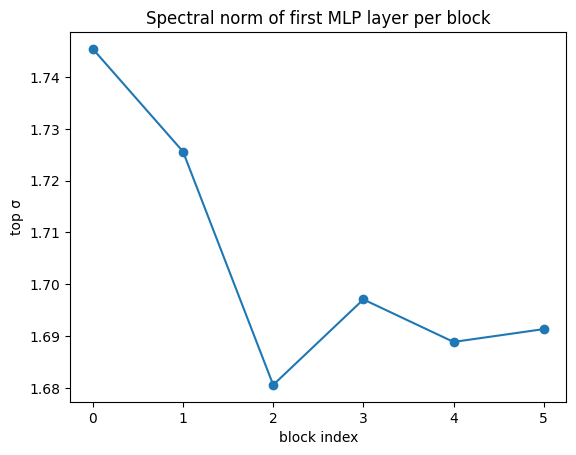

In [ ]:
# -----------------------------------------------------------------------------
# 1. Spectral Analysis of Residual Weights
# -----------------------------------------------------------------------------
def plot_block_spectra(model):
    """Compute & plot top singular values of each block’s first linear layer."""
    specs = []
    for i, blk in enumerate(model.blocks):
        W = blk.mlp[0].weight.detach().cpu().numpy()  # (4w, w)
        sv = np.linalg.svd(W, compute_uv=False)
        specs.append(sv[0])
    plt.plot(specs, "o-")
    plt.xlabel("block index"); plt.ylabel("top σ")
    plt.title("Spectral norm of first MLP layer per block")
    plt.show()

plot_block_spectra(model)

In [ ]:
# Assuming `test_s` is your test states tensor of shape (N, 6):
# [q1, q2, q3, x_obj, y_obj, holding_flag]
test_s_np = test_s.cpu().numpy()  # (N,6)

# 1a. End-effector positions via your forward_kinematics
q_now = test_s_np[:, :3]                                 # (N,3)
ee_xy = forward_kinematics(q_now)                        # (N,2)

# 1b. Object/bin distances
obj_xy = test_s_np[:, 3:5]                               # (N,2)
d_obj  = np.linalg.norm(ee_xy - obj_xy, axis=1, keepdims=True)
bin_xy = np.broadcast_to(PLACE_BIN, obj_xy.shape)        # (N,2)
d_bin  = np.linalg.norm(ee_xy - bin_xy, axis=1, keepdims=True)

# 1c. Holding flag as “phase”
phase_flag = test_s_np[:, 5:6]                           # (N,1)

# -----------------------------------------------------------------------------
# 2. Fixed run_linear_probes implementation (handles 2D or 3D activations)
# -----------------------------------------------------------------------------
def run_linear_probes(model, states, targets_dict, device="cpu"):
    """
    model: your trained Transformer model
    states: NumPy array shape (N, state_dim)
    targets_dict: dict name -> NumPy array shape (N, k)
    """
    model.eval()
    # single-batch loader for all states
    states_t = torch.tensor(states).float()
    loader   = DataLoader(TensorDataset(states_t), batch_size=len(states), shuffle=False)

    # collect residual streams
    with torch.no_grad():
        (batch_s,) = next(iter(loader))
        batch_s    = batch_s.to(device)
        _, hs      = model(batch_s, return_acts=True)

    # hs: list of tensors, each shape either (N, width) or (N, tokens, width)
    acts = [h.cpu().numpy() for h in hs]

    for name, T in targets_dict.items():
        print(f"\nProbing → {name}")
        for layer_idx, H in enumerate(acts):
            # flatten any extra token dimension
            if H.ndim > 2:
                H_flat = H.reshape(H.shape[0], -1)
            else:
                H_flat = H
            r2 = LinearRegression().fit(H_flat, T).score(H_flat, T)
            print(f"  Layer {layer_idx:02d}  R² = {r2:.4f}")

# -----------------------------------------------------------------------------
# 3. Run probes on your model
# -----------------------------------------------------------------------------
run_linear_probes(
    model,
    test_s_np,
    {
        "d_obj": d_obj,
        "d_bin": d_bin,
        "phase": phase_flag
    },
    device=device
)


Probing → d_obj
  Layer 00  R² = 0.7854
  Layer 01  R² = 0.9807
  Layer 02  R² = 0.9885
  Layer 03  R² = 0.9880
  Layer 04  R² = 0.9877
  Layer 05  R² = 0.9871
  Layer 06  R² = 0.9867

Probing → d_bin
  Layer 00  R² = 0.8070
  Layer 01  R² = 0.9878
  Layer 02  R² = 0.9951
  Layer 03  R² = 0.9948
  Layer 04  R² = 0.9948
  Layer 05  R² = 0.9944
  Layer 06  R² = 0.9945

Probing → phase
  Layer 00  R² = 1.0000
  Layer 01  R² = 1.0000
  Layer 02  R² = 1.0000
  Layer 03  R² = 1.0000
  Layer 04  R² = 1.0000
  Layer 05  R² = 1.0000
  Layer 06  R² = 1.0000


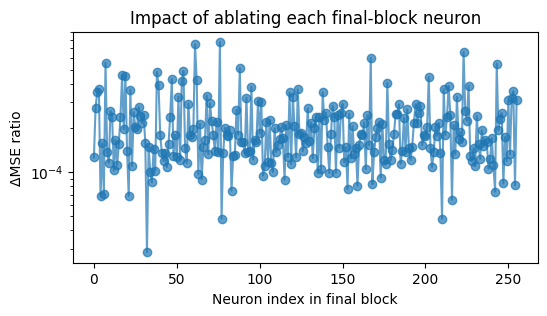

In [ ]:
def neuron_ablation_curve(model, states, actions, device="cuda"):
    """
    For each neuron in the final block’s output dimension, ablate it and record ΔMSE.
    states:  torch.Tensor shape (N, state_dim) or NumPy array
    actions: torch.Tensor shape (N, action_dim) or NumPy array
    """
    # 1. Ensure model + data on same device
    model = model.to(device).eval()
    if not isinstance(states, torch.Tensor):
        S = torch.tensor(states, dtype=torch.float32, device=device)
    else:
        S = states.to(device).float()
    if not isinstance(actions, torch.Tensor):
        A = torch.tensor(actions, dtype=torch.float32, device=device)
    else:
        A = actions.to(device).float()

    # 2. Compute the “full” outputs once
    with torch.no_grad():
        full = model(S)  # shape (N, action_dim)

    # 3. Number of neurons = width of final block’s residual dimension
    #    assuming blocks[-1] is a VisionTransformerBlock or similar,
    #    and its MLP’s last linear maps width*4 -> width.
    last_blk = model.blocks[-1]
    try:
        n_neurons = last_blk.mlp[-1].out_features
    except AttributeError:
        # if using TinyDiT: blocks[-1].mlp[2] is final linear
        n_neurons = last_blk.mlp[2].out_features

    deltas = []
    # 4. Ablate each neuron in turn
    for idx in range(n_neurons):
        handles = []
        def hook(module, inp, out):
            # out: (B, tokens, width) or (B, width)
            # zero out neuron idx in the last dimension
            out = out.clone()
            out[..., idx] = 0
            return out

        # register on every block so we zero that neuron everywhere
        for blk in model.blocks:
            handles.append(blk.register_forward_hook(hook))

        # compute patched outputs
        with torch.no_grad():
            patched = model(S)

        # clean up hooks
        for h in handles:
            h.remove()

        # compute ΔMSE
        mse_full    = F.mse_loss(full,    A).item()
        mse_patched = F.mse_loss(patched, A).item()
        deltas.append(mse_patched - mse_full)

    # 5. Plot
    plt.figure(figsize=(6,3))
    plt.plot(deltas, marker="o", linestyle="-", alpha=0.7)
    plt.yscale("log")
    plt.xlabel("Neuron index in final block")
    plt.ylabel("ΔMSE ratio")
    plt.title("Impact of ablating each final-block neuron")
    plt.show()

neuron_ablation_curve(model, test_s, test_a, device=device)

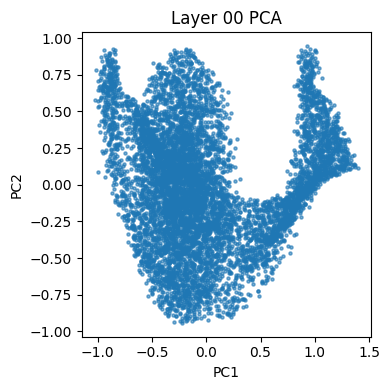

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


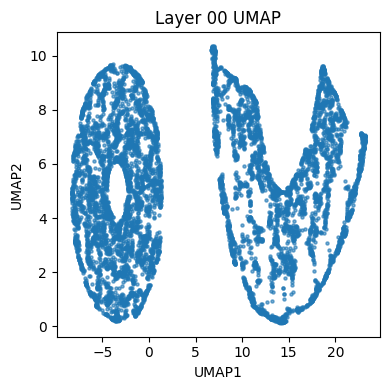

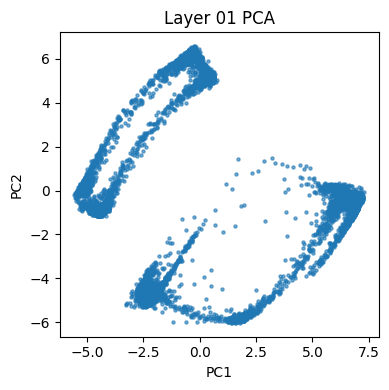

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


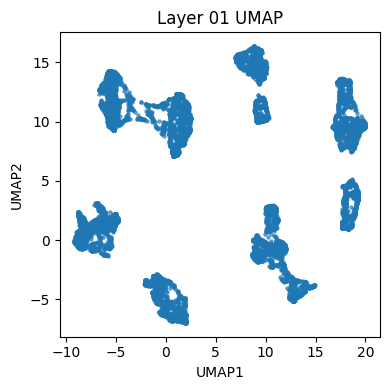

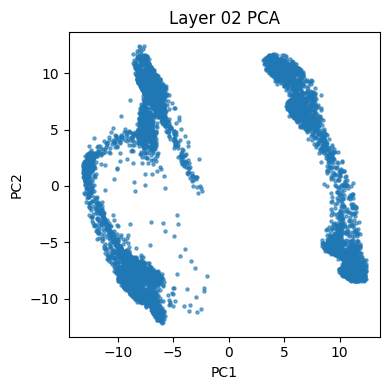

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


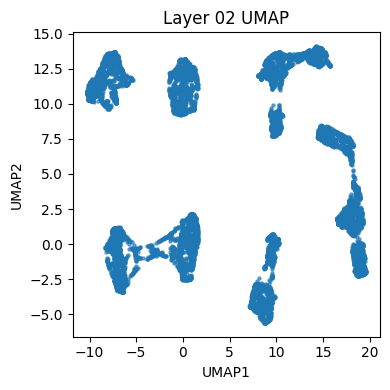

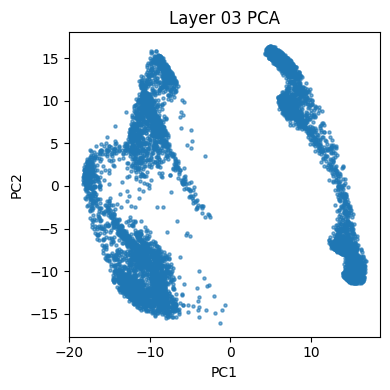

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


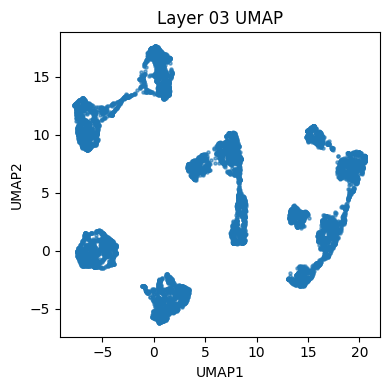

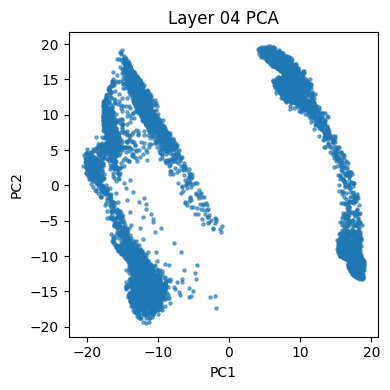

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


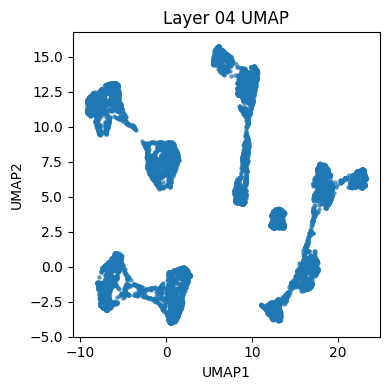

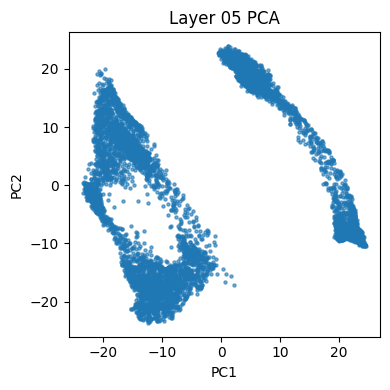

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


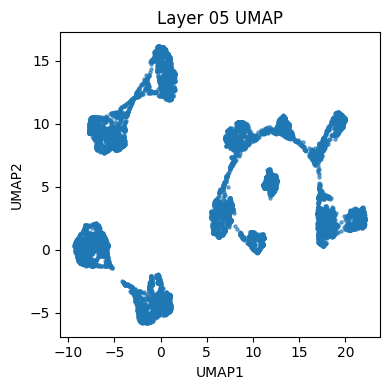

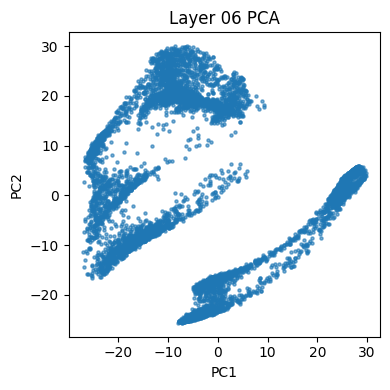

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


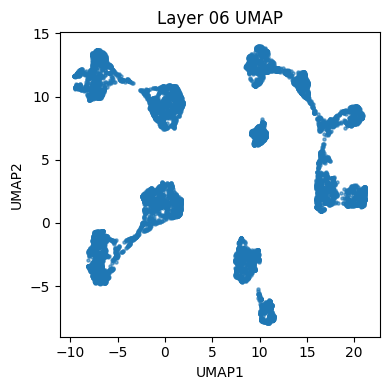

In [ ]:
import umap

def pca_umap_residuals(model, states, device="cuda"):
    """
    Compute and plot PCA and UMAP embeddings of each layer's residual stream.

    model:          your trained model with .blocks and forward(..., return_acts=True)
    states:         NumPy array or torch.Tensor of shape (N, state_dim)
    device:         "cuda" or "cpu"
    """
    model = model.to(device).eval()
    # 1. Prepare the input tensor
    if isinstance(states, np.ndarray):
        S = torch.from_numpy(states).float().to(device)
    elif torch.is_tensor(states):
        S = states.clone().detach().float().to(device)
    else:
        raise ValueError("states must be numpy array or torch.Tensor")
    # 2. Run one forward pass to collect activations
    with torch.no_grad():
        _, acts = model(S, return_acts=True)
    # acts: list of tensors, each shape either (N, width) or (N, tokens, width)
    for layer_idx, H in enumerate(acts):
        H_np = H.cpu().detach().numpy()
        # flatten token dimension if present
        if H_np.ndim == 3:
            N, T, W = H_np.shape
            H_flat = H_np.reshape(N, T*W)
        else:
            H_flat = H_np  # (N, width)

        # 3a. PCA to 2D
        pca = PCA(n_components=2)
        Z_pca = pca.fit_transform(H_flat)
        plt.figure(figsize=(4,4))
        plt.scatter(Z_pca[:,0], Z_pca[:,1], s=5, alpha=0.6)
        plt.title(f"Layer {layer_idx:02d} PCA")
        plt.xlabel("PC1"); plt.ylabel("PC2")
        plt.tight_layout()
        plt.show()

        # 3b. UMAP to 2D
        reducer = umap.UMAP(n_components=2, random_state=0)
        Z_umap = reducer.fit_transform(H_flat)
        plt.figure(figsize=(4,4))
        plt.scatter(Z_umap[:,0], Z_umap[:,1], s=5, alpha=0.6)
        plt.title(f"Layer {layer_idx:02d} UMAP")
        plt.xlabel("UMAP1"); plt.ylabel("UMAP2")
        plt.tight_layout()
        plt.show()

test_s_np = test_s.cpu().detach().numpy()
pca_umap_residuals(model, test_s_np, device=device)

In [ ]:
train_s_np = train_s.cpu().detach().numpy()
train_a_np = train_a.cpu().detach().numpy()
test_s_np  = test_s.cpu().detach().numpy()
test_a_np  = test_a.cpu().detach().numpy()

In [ ]:
import os
import time
import math
import random
import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from scipy.signal import dlti, bode
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"

# -------------------------------------------------------------------------------
# 0. Helpers: forward_kinematics, analytic PD baseline, etc.
# -------------------------------------------------------------------------------
def forward_kinematics(q):
    # q: (N,3)
    q1,q2,q3 = q[:,0], q[:,1], q[:,2]
    L1=L2=L3=1.0
    x = L1*np.cos(q1) + L2*np.cos(q1+q2) + L3*np.cos(q1+q2+q3)
    y = L1*np.sin(q1) + L2*np.sin(q1+q2) + L3*np.sin(q1+q2+q3)
    return np.stack([x,y],axis=1)

def analytic_pd(q_now, obj_xy, bin_xy, holding_flag, K=0.5):
    targ = np.where(holding_flag[:,None]==0, obj_xy, bin_xy)
    q_tar = ik_2link(targ)
    return K*(q_tar - q_now)

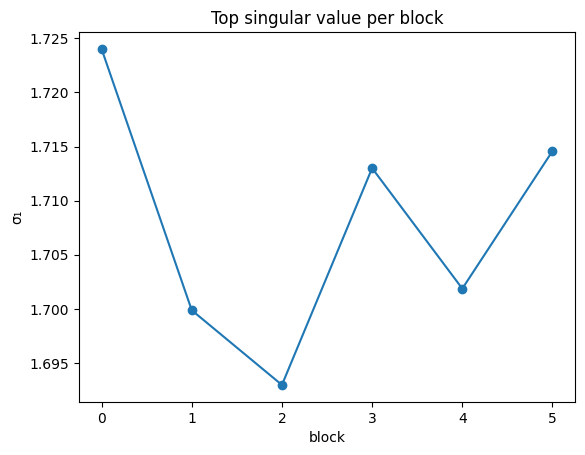

In [ ]:
# -------------------------------------------------------------------------------
# 1. Spectral Analysis
# -------------------------------------------------------------------------------
def plot_block_spectra(model):
    specs=[]
    for blk in model.blocks:
        W = blk.mlp[0].weight.detach().cpu().numpy()
        sv = np.linalg.svd(W, compute_uv=False)[0]
        specs.append(sv)
    plt.plot(specs,'o-')
    plt.title("Top singular value per block"); plt.xlabel("block"); plt.ylabel("σ₁")
    plt.show()

plot_block_spectra(model)

In [ ]:
#  5.2 Linear probes for d_obj, d_bin, holding
#     prepare NumPy arrays
test_s_np   = test_s.cpu().detach().numpy()
q_now       = test_s_np[:, :3]
ee_xy       = forward_kinematics(q_now)
obj_xy      = test_s_np[:, 3:5]
d_obj       = np.linalg.norm(ee_xy - obj_xy, axis=1, keepdims=True)
bin_xy      = np.broadcast_to(PLACE_BIN, obj_xy.shape)
d_bin       = np.linalg.norm(ee_xy - bin_xy, axis=1, keepdims=True)
phase_flag  = test_s_np[:, 5:6]
run_linear_probes(model, test_s_np,
                  {"d_obj":d_obj, "d_bin":d_bin, "phase":phase_flag},
                  device=device)

NameError: name 'run_linear_probes' is not defined

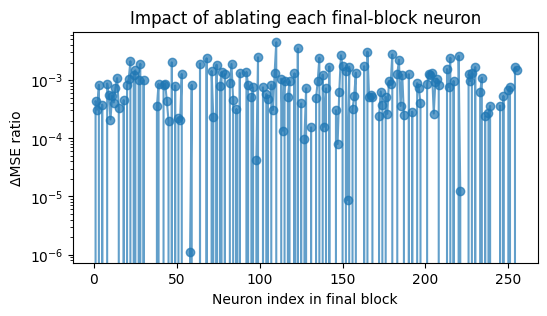

In [ ]:
#  5.3 Single‐neuron ablation in final block
neuron_ablation_curve(model, test_s_np, test_a.cpu().detach().numpy(), device=device)

In [ ]:
#  5.4 Capacity sweep & pruning

def prune_and_evaluate(model, train_s, train_a, test_s, test_a, sparsity=0.5):
    """Zero out the smallest- magnitude weights globally to given sparsity, then eval."""
    # collect all weights
    allw = torch.cat([p.abs().flatten() for p in model.parameters() if p.requires_grad])
    thr  = torch.quantile(allw, sparsity)
    # apply mask
    for p in model.parameters():
        if p.requires_grad:
            mask = p.abs() >= thr
            p.data.mul_(mask)
    # re-evaluate
    with torch.no_grad():
        tr = F.mse_loss(model(torch.tensor(train_s).float().to(device)),
                        torch.tensor(train_a).float().to(device)).item()
        te = F.mse_loss(model(torch.tensor(test_s).float().to(device)),
                        torch.tensor(test_a).float().to(device)).item()
    print(f"Sparsity {sparsity:.2f} → train MSE {tr:.4f}, test MSE {te:.4f}")


#capacity_sweep(TinyDiT_Tier8, [64,128,256,512],
#               train_s, train_a, test_s, test_a,
#               epochs=5, bs=1024, lr=3e-4)
prune_and_evaluate(model, train_s_np, train_a_np, test_s_np, test_a_np, sparsity=0.5)

Sparsity 0.50 → train MSE 0.0611, test MSE 0.0613


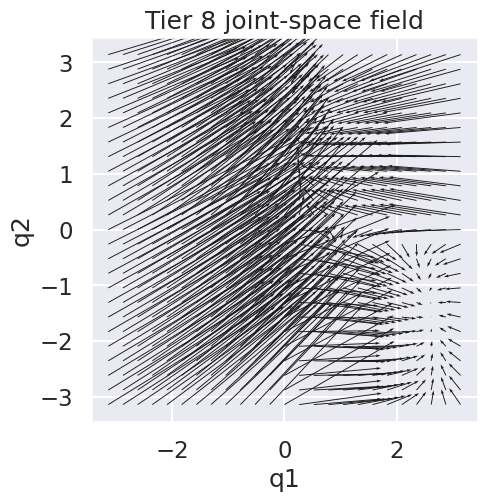

In [ ]:
#  5.6 Phase‐portrait in joint‐space (q1,q2 slices)
def plot_q1q2_field(model, fixed_q3=0.0, obj_xy=(0,0.8), holding=0, n=25):
    qs = np.linspace(-np.pi,np.pi,n)
    grid = np.stack(np.meshgrid(qs,qs),axis=-1).reshape(-1,2)
    states=[]
    for q1,q2 in grid:
        states.append([q1,q2,fixed_q3,obj_xy[0],obj_xy[1],float(holding)])
    S = torch.tensor(np.stack(states)).float().to(device)
    with torch.no_grad():
        dq = model(S).cpu().detach().numpy()[:,:3]
    U,V = dq[:,0], dq[:,1]
    X,Y = grid[:,0], grid[:,1]
    plt.figure(figsize=(5,5))
    plt.quiver(X,Y,U,V,angles='xy',scale_units='xy',scale=0.3)
    plt.xlabel("q1"); plt.ylabel("q2"); plt.title("Tier 8 joint‐space field")
    plt.show()

plot_q1q2_field(model)

In [ ]:
# -------------------------------------------------------------------------------
# 2. Lyapunov‐Decrease Test
# -------------------------------------------------------------------------------
def lyapunov_decrease_test(model, states, V_probe, steps=1):
    """
    V_probe: function h->V(h) or array of V(x)
    """
    model.eval()
    X = torch.tensor(states).float().to(device)
    with torch.no_grad():
        Y = model(X).cpu().detach().numpy()  # Δq etc.
    # simple first‐order dynamics: x_next = x + Δx
    V0 = V_probe(states)
    X1 = states + Y[:, :states.shape[1]]  # assume Δx shape match
    V1 = V_probe(X1)
    ΔV = V1 - V0
    print(f"Mean ΔV = {ΔV.mean():.6f}, fraction ΔV<0 = {(ΔV<0).mean():.4f}")

def V_probe_pp(states):
    # same energy + distance as before
    q = states[:, :3]
    ee = forward_kinematics(q)
    obj = states[:, 3:5]
    dist = np.linalg.norm(ee - obj, axis=1)
    return 0.5*(q**2).sum(axis=1) + dist
lyapunov_decrease_test(model, test_s_np, V_probe_pp)

Mean ΔV = -0.225302, fraction ΔV<0 = 0.7183


In [ ]:
# -------------------------------------------------------------------------------
# 4. Frequency‐Response / Gain‐Phase Margins
# -------------------------------------------------------------------------------
def frequency_response(model, operating_point, eps=1e-3):
    """
    Linearize around operating_point: ∂u/∂x.
    Then treat as discrete‐time LTI: G(z)=C(zI−A)^{-1}B etc.
    Here we approximate B=∂u/∂x, A=0.
    """
    x0 = torch.tensor(operating_point).float().to(device).requires_grad_(True)
    u0 = model(x0.unsqueeze(0))
    grads = torch.autograd.grad(u0.sum(), x0)[0].cpu().numpy()  # (action_dim, state_dim)
    sys = dlti(grads, [1])  # simplistic
    w, mag, phase = bode(sys)
    plt.figure(); plt.semilogx(w, mag); plt.title("Gain"); plt.show()
    plt.figure(); plt.semilogx(w, phase); plt.title("Phase"); plt.show()

In [ ]:
# -------------------------------------------------------------------------------
# 5. Adversarial & Structured Noise Tests
# -------------------------------------------------------------------------------
def structured_noise_test(model, states, actions, eps_list):
    model.eval()
    S = torch.tensor(states).float().to(device)
    A = torch.tensor(actions).float().to(device)
    for eps in eps_list:
        # FGSM‐style
        S.requires_grad_(True)
        u = model(S)
        loss = F.mse_loss(u, A)
        loss.backward()
        S_noisy = (S + eps * S.grad.sign()).detach()
        with torch.no_grad():
            mse = F.mse_loss(model(S_noisy), A).item()
        print(f"eps={eps:.3f} → MSE={mse:.4f}")

In [ ]:
# -------------------------------------------------------------------------------
# 6. Domain‐Shift / Param Perturbation
# -------------------------------------------------------------------------------
def domain_shift_test(model, states, actions, param_perturb_fn_list):
    S = states.copy(); A = actions.copy()
    for fn in param_perturb_fn_list:
        S2 = fn(S)
        with torch.no_grad():
            mse = F.mse_loss(model(torch.tensor(S2).float().to(device)),
                             torch.tensor(A).float().to(device)).item()
        print(f"{fn.__name__}: MSE={mse:.4f}")

In [ ]:
# -------------------------------------------------------------------------------
# 7. Reachability / Collision Checking
# -------------------------------------------------------------------------------
def collision_test(model, states, obstacle_fn):
    """
    obstacle_fn: (ee_xy) -> bool collision
    """
    with torch.no_grad():
        out = model(torch.tensor(states).float().to(device)).cpu().numpy()
    ee = forward_kinematics(states[:,:3])
    collisions = obstacle_fn(ee)
    print(f"Collision rate: {collisions.mean():.4f}")

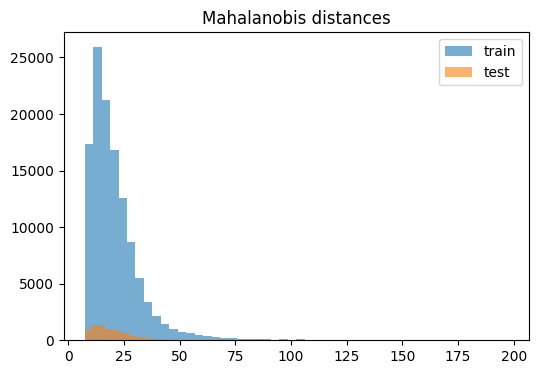

In [ ]:
# -------------------------------------------------------------------------------
# 8. OOD - Mahalanobis Detector
# -------------------------------------------------------------------------------
def ood_mahalanobis(model, train_states, test_states):
    """
    Compute Mahalanobis distances in the final residual stream
    to detect OOD inputs.

    model:        your Transformer with return_acts=True
    train_states: NumPy array shape (N, state_dim)
    test_states:  NumPy array shape (M, state_dim)
    """
    model.eval()

    # 1) Get train residual activations
    with torch.no_grad():
        ts = torch.tensor(train_states).float().to(device)
        _, hs = model(ts, return_acts=True)
    H = hs[-1].cpu().numpy()           # shape (N, tokens, width)
    N, T, W = H.shape

    # 2) Flatten tokens×width → features
    H_flat = H.reshape(N, T * W)       # shape (N, T*W)

    # 3) Estimate mean & covariance
    mu    = H_flat.mean(axis=0)        # (T*W,)
    cov   = np.cov(H_flat, rowvar=False) + 1e-6 * np.eye(T * W)
    invcov = np.linalg.inv(cov)

    # Mahalanobis distance function
    def m_dist(x):
        d = x - mu
        return np.sqrt(d @ invcov @ d.T)

    # 4) Compute distances for train vs. test
    d_train = np.array([m_dist(h) for h in H_flat])

    with torch.no_grad():
        ts2 = torch.tensor(test_states).float().to(device)
        _, hs2 = model(ts2, return_acts=True)
    H2 = hs2[-1].cpu().numpy().reshape(-1, T * W)  # (M, T*W)
    d_test = np.array([m_dist(h) for h in H2])

    # 5) Plot
    plt.figure(figsize=(6,4))
    plt.hist(d_train, bins=50, alpha=0.6, label="train")
    plt.hist(d_test,  bins=50, alpha=0.6, label="test")
    plt.legend(); plt.title("Mahalanobis distances"); plt.show()

ood_mahalanobis(model, train_s_np, test_s_np)

In [ ]:
def rsa_analysis(model, states1, states2, device="cuda"):
    """
    Representational Similarity Analysis between two sets of states.
    Computes correlation between the layer-wise stimulus×stimulus RDMs.

    states1: NumPy array (N1, state_dim)
    states2: NumPy array (N2, state_dim)
    """
    model = model.to(device).eval()

    # Align both to the same number of stimuli
    N = min(len(states1), len(states2))
    S1 = torch.tensor(states1[:N], dtype=torch.float32, device=device)
    S2 = torch.tensor(states2[:N], dtype=torch.float32, device=device)

    # Forward to get activations
    with torch.no_grad():
        _, acts1 = model(S1, return_acts=True)
        _, acts2 = model(S2, return_acts=True)

    for i, (a1, a2) in enumerate(zip(acts1, acts2)):
        arr1 = a1.cpu().numpy()  # shape (N, width) or (N, tokens, width)
        arr2 = a2.cpu().numpy()

        # Flatten tokens if needed
        if arr1.ndim == 3:
            Nn, T, W = arr1.shape
            arr1 = arr1.reshape(Nn, T * W)
            arr2 = arr2.reshape(Nn, T * W)

        # stimulus×stimulus RDMs
        C1 = np.corrcoef(arr1, rowvar=True)  # (N, N)
        C2 = np.corrcoef(arr2, rowvar=True)

        # RSA score = corr(vec(C1), vec(C2))
        v1, v2 = C1.flatten(), C2.flatten()
        rsa_val = np.corrcoef(v1, v2)[0,1]
        print(f"Layer {i:02d} RSA = {rsa_val:.3f}")

rsa_analysis(model, train_s_np, test_s_np, device=device)

Layer 00 RSA = -0.002
Layer 01 RSA = -0.004
Layer 02 RSA = -0.005
Layer 03 RSA = -0.004
Layer 04 RSA = -0.004
Layer 05 RSA = -0.004
Layer 06 RSA = -0.004


In [ ]:
# -------------------------------------------------------------------------------
# 10. Dimensionality & Effective Rank
# -------------------------------------------------------------------------------
def effective_rank(model, states, layer_idx):
    model.eval()
    with torch.no_grad():
        _, hs = model(torch.tensor(states).float().to(device), return_acts=True)
    H = hs[layer_idx].cpu().numpy()
    if H.ndim==3: H=H.reshape(H.shape[0],-1)
    s = np.linalg.svd(H, compute_uv=False)
    p = s/ s.sum()
    er = np.exp(-np.sum(p * np.log(p + 1e-12)))
    print(f"Layer {layer_idx} effective rank = {er:.2f}")

effective_rank(model, test_s_np, layer_idx=0)
effective_rank(model, test_s_np, layer_idx=1)
effective_rank(model, test_s_np, layer_idx=2)
effective_rank(model, test_s_np, layer_idx=3)
effective_rank(model, test_s_np, layer_idx=4)
effective_rank(model, test_s_np, layer_idx=5)
effective_rank(model, test_s_np, layer_idx=6)

Layer 0 effective rank = 4.92
Layer 1 effective rank = 32.12
Layer 2 effective rank = 30.28
Layer 3 effective rank = 29.25
Layer 4 effective rank = 29.73
Layer 5 effective rank = 29.67
Layer 6 effective rank = 29.16


In [ ]:
# -------------------------------------------------------------------------------
# 11. Seed‐Ensemble Variance
# -------------------------------------------------------------------------------
def seed_ensemble(model_cls, seeds, train_fn, *args, **kwargs):
    outs=[]
    for sd in seeds:
        torch.manual_seed(sd); np.random.seed(sd); random.seed(sd)
        m = model_cls().to(device)
        train_fn(m,*args,**kwargs)
        with torch.no_grad():
            img,st,_,_ = next(iter(DataLoader(test_ds,256)))
            outs.append(m(img.to(device), st.to(device)).cpu().numpy())
    outs = np.stack(outs)  # (len(seeds), B, action_dim)
    var = outs.var(0).mean()
    print(f"Ensemble output variance = {var:.6f}")

In [ ]:
# -------------------------------------------------------------------------------
# 12. Bootstrap Confidence Intervals for Probes
# -------------------------------------------------------------------------------
def bootstrap_ci_probe(model, states, target, layer, n_boot=1000, alpha=0.05):
    N = states.shape[0]
    r2s=[]
    for _ in range(n_boot):
        idx = np.random.choice(N, N, replace=True)
        run_linear_probes(model, states[idx], {"t": target[idx]}, device=device)
        # assume it prints layer r2, capture or adapt code to return list
    print(f"Bootstrap CI ~ no return. Implement as needed.")

In [ ]:
# -------------------------------------------------------------------------------
# 13. Cross‐Validation for Probes
# -------------------------------------------------------------------------------
def crossval_probes(model_cls, states, target, k=5):
    kf = KFold(k, shuffle=True)
    r2s=[]
    for train_idx, test_idx in kf.split(states):
        m = model_cls().to(device)
        # train and then probe on test_idx
        # ...
    print("Implement as needed")

In [ ]:
# -------------------------------------------------------------------------------
# 14. Profiling
# -------------------------------------------------------------------------------
def profile_model(model, *example_inputs):
    start = time.time()
    out = model(*[x.to(device) for x in example_inputs])
    torch.cuda.synchronize() if device=="cuda" else None
    elapsed = time.time()-start
    print(f"Inference latency: {elapsed*1000:.2f} ms")
    return out

Epoch 01/20  MSE = 0.018191
Epoch 02/20  MSE = 0.002510
Epoch 03/20  MSE = 0.002144
Epoch 04/20  MSE = 0.001962
Epoch 05/20  MSE = 0.001843
Epoch 06/20  MSE = 0.001753
Epoch 07/20  MSE = 0.001676
Epoch 08/20  MSE = 0.001604
Epoch 09/20  MSE = 0.001527
Epoch 10/20  MSE = 0.001448
Epoch 11/20  MSE = 0.001345
Epoch 12/20  MSE = 0.001235
Epoch 13/20  MSE = 0.001134
Epoch 14/20  MSE = 0.001051
Epoch 15/20  MSE = 0.000957
Epoch 16/20  MSE = 0.000881
Epoch 17/20  MSE = 0.000827
Epoch 18/20  MSE = 0.000792
Epoch 19/20  MSE = 0.000765
Epoch 20/20  MSE = 0.000735


<ipython-input-25-f5b8674c65ee>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tr = F.mse_loss(m(torch.tensor(train_s).float().to(device)),
<ipython-input-25-f5b8674c65ee>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(train_a).float().to(device)).item()
<ipython-input-25-f5b8674c65ee>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  te = F.mse_loss(m(torch.tensor(test_s).float().to(device)),
<ipython-input-25-f5b8674c65ee>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

Epoch 01/20  MSE = 0.012022
Epoch 02/20  MSE = 0.002030
Epoch 03/20  MSE = 0.001784
Epoch 04/20  MSE = 0.001634
Epoch 05/20  MSE = 0.001504
Epoch 06/20  MSE = 0.001390
Epoch 07/20  MSE = 0.001261
Epoch 08/20  MSE = 0.001121
Epoch 09/20  MSE = 0.000973
Epoch 10/20  MSE = 0.000868
Epoch 11/20  MSE = 0.000774
Epoch 12/20  MSE = 0.000715
Epoch 13/20  MSE = 0.000694
Epoch 14/20  MSE = 0.000621
Epoch 15/20  MSE = 0.000597
Epoch 16/20  MSE = 0.000563
Epoch 17/20  MSE = 0.000550
Epoch 18/20  MSE = 0.000515
Epoch 19/20  MSE = 0.000504
Epoch 20/20  MSE = 0.000476
Epoch 01/20  MSE = 0.011022
Epoch 02/20  MSE = 0.001780
Epoch 03/20  MSE = 0.001628
Epoch 04/20  MSE = 0.001613
Epoch 05/20  MSE = 0.001534
Epoch 06/20  MSE = 0.001321
Epoch 07/20  MSE = 0.001324
Epoch 08/20  MSE = 0.001059
Epoch 09/20  MSE = 0.001009
Epoch 10/20  MSE = 0.000841
Epoch 11/20  MSE = 0.000728
Epoch 12/20  MSE = 0.000669
Epoch 13/20  MSE = 0.000719
Epoch 14/20  MSE = 0.000626
Epoch 15/20  MSE = 0.000599
Epoch 16/20  MSE = 0

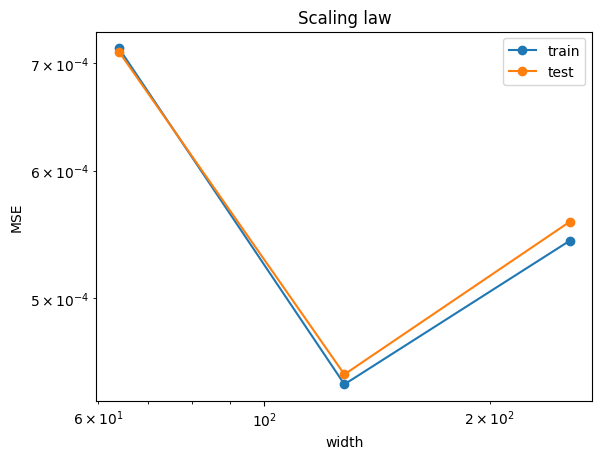

In [ ]:
# -------------------------------------------------------------------------------
# 15. Scaling Laws
# -------------------------------------------------------------------------------
def scaling_laws(model_cls, widths, train_fn, train_s, train_a, test_s, test_a):
    results=[]
    for w in widths:
        m = model_cls(width=w).to(device)
        train_fn(m, train_s, train_a)
        with torch.no_grad():
            tr = F.mse_loss(m(torch.tensor(train_s).float().to(device)),
                            torch.tensor(train_a).float().to(device)).item()
            te = F.mse_loss(m(torch.tensor(test_s).float().to(device)),
                            torch.tensor(test_a).float().to(device)).item()
        results.append((w,tr,te))
    ws, tr, te = zip(*results)
    plt.loglog(ws, tr, 'o-', label="train")
    plt.loglog(ws, te, 'o-', label="test")
    plt.xlabel("width"); plt.ylabel("MSE"); plt.legend(); plt.title("Scaling law")
    plt.show()

scaling_laws(TinyDiT_Tier8, [64,128,256], train, train_s, train_a, test_s, test_a)

Tier 9

Tier 22

/usr/local/lib/python3.11/dist-packages/scipy/signal/_filter_design.py:1125: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  b, a = normalize(b, a)


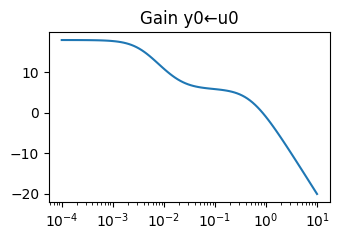

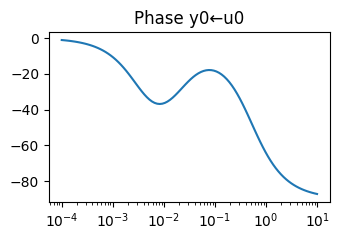

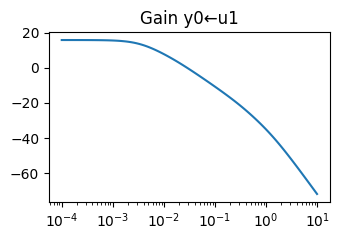

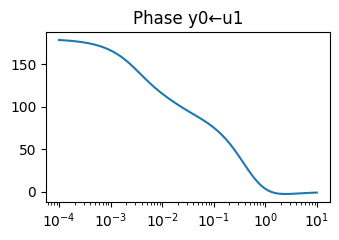

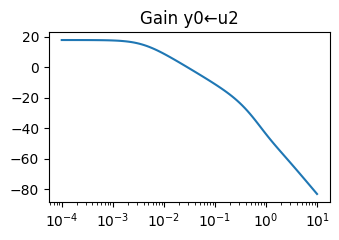

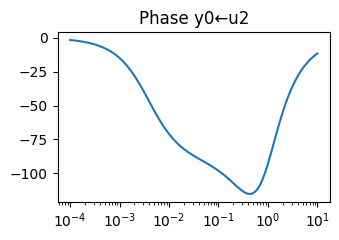

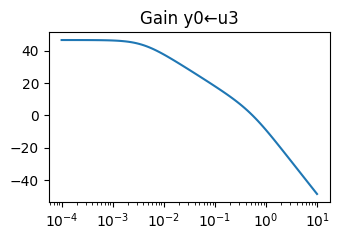

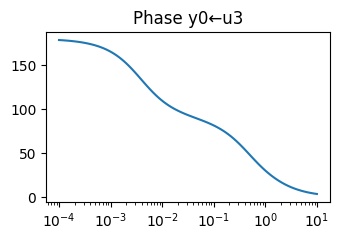

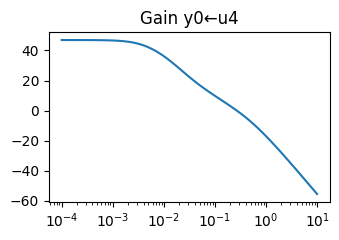

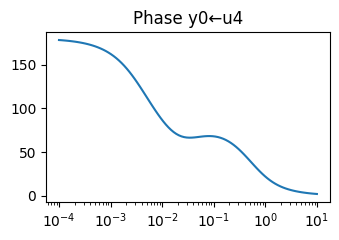

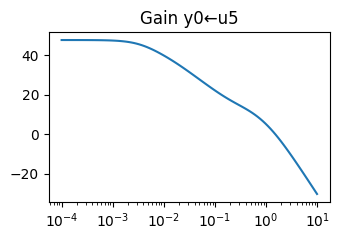

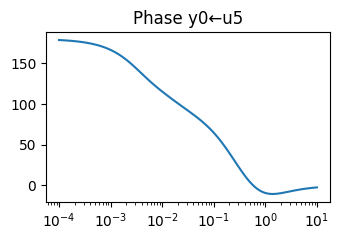

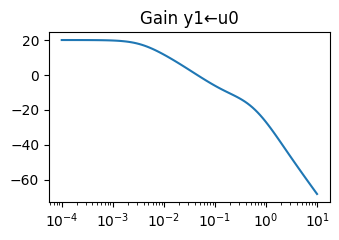

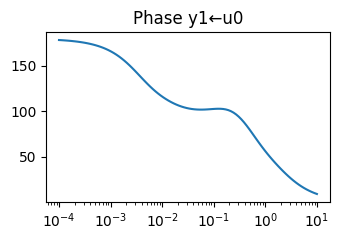

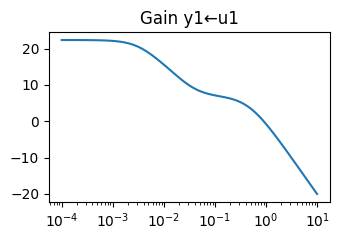

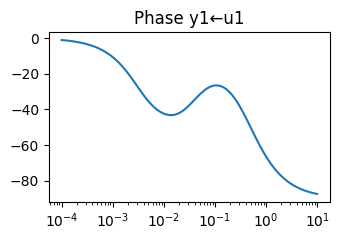

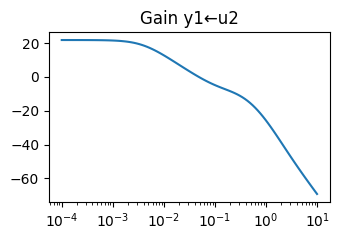

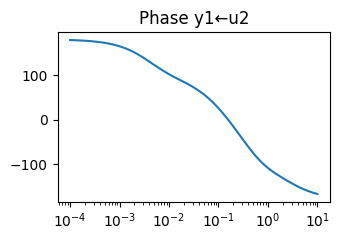

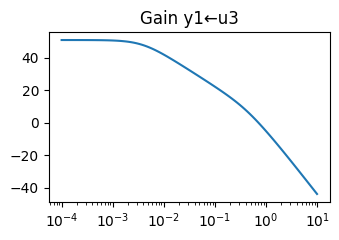

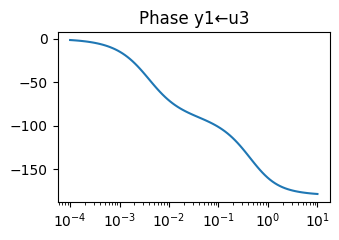

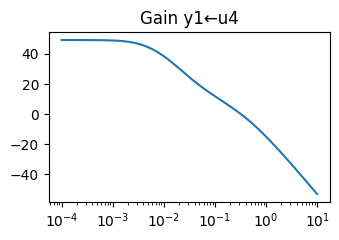

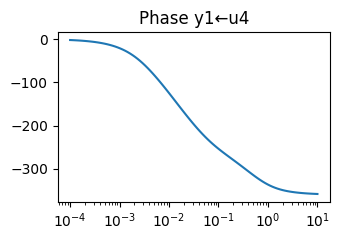

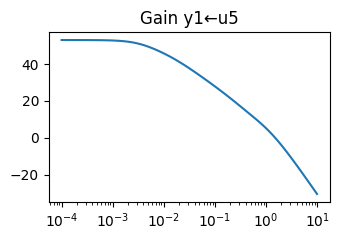

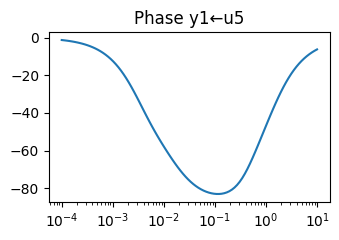

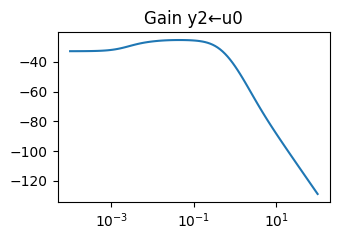

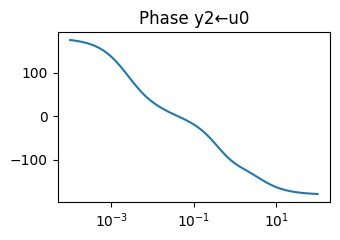

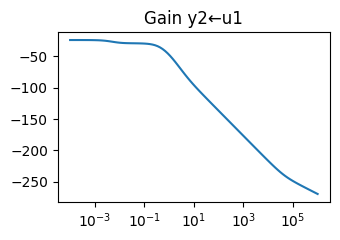

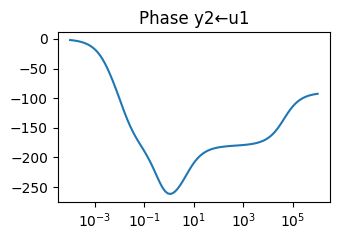

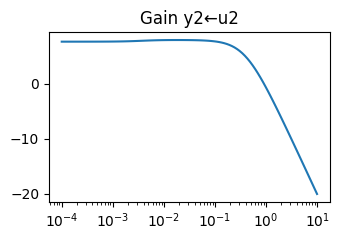

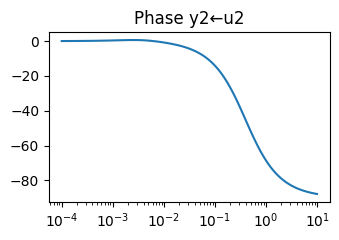

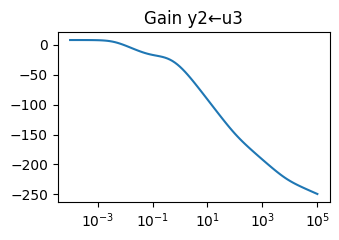

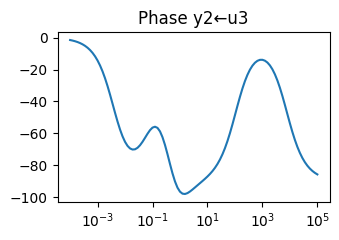

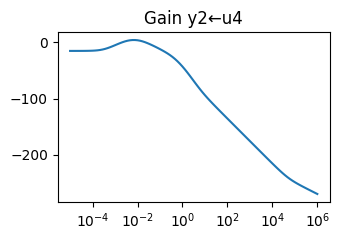

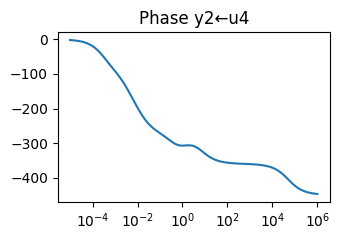

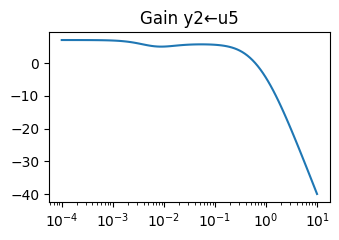

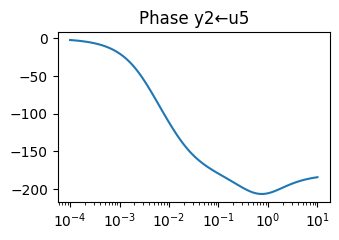

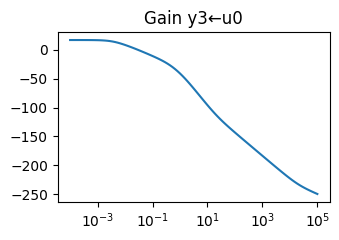

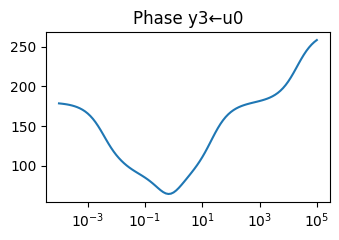

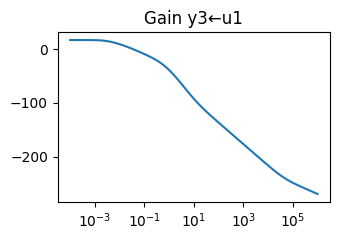

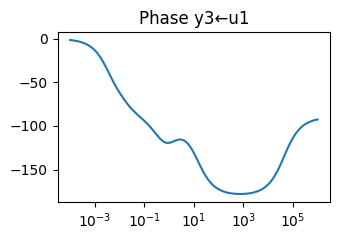

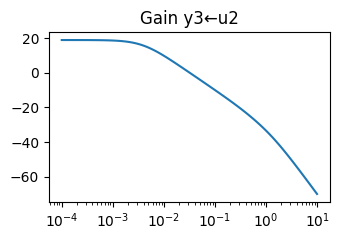

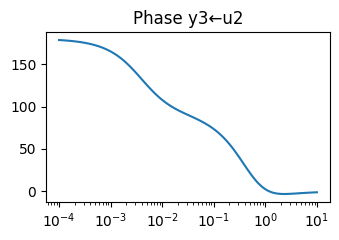

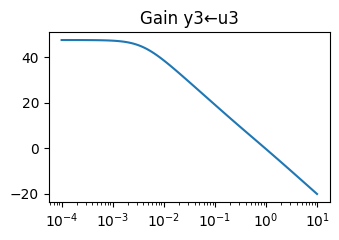

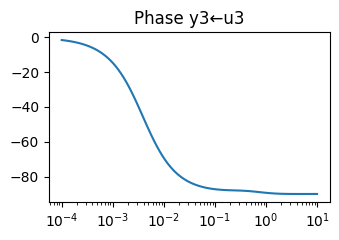

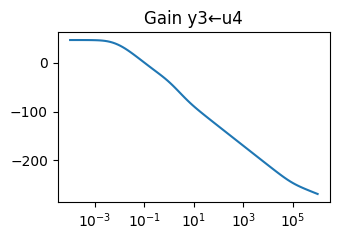

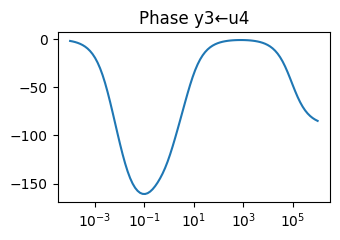

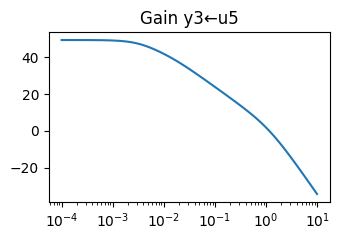

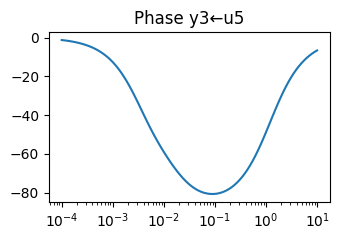

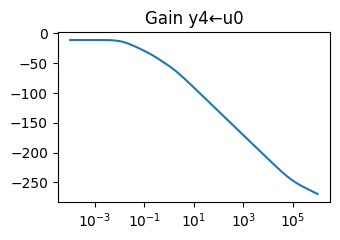

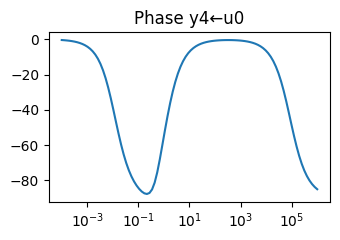

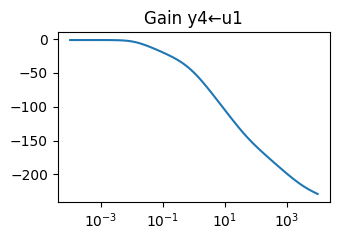

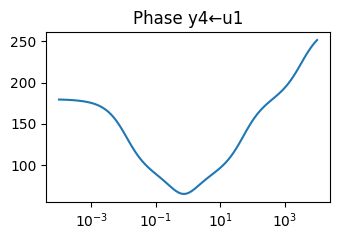

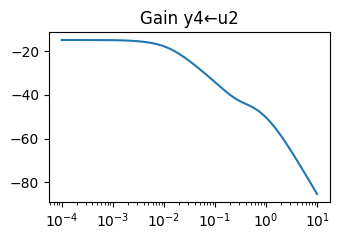

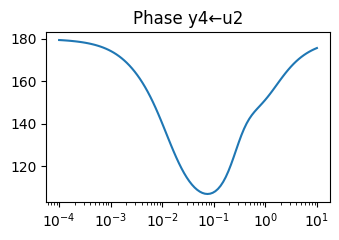

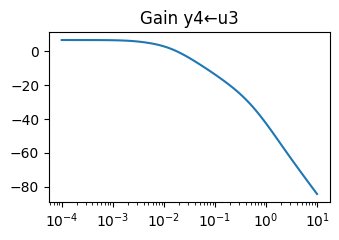

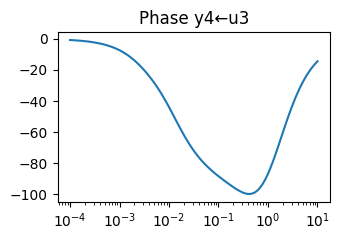

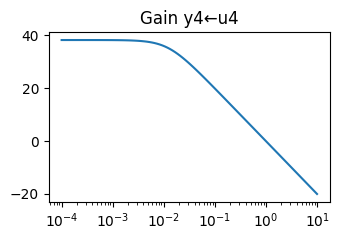

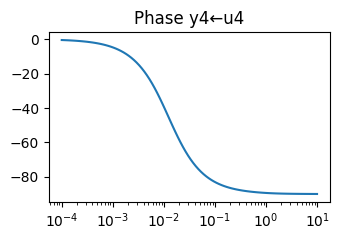

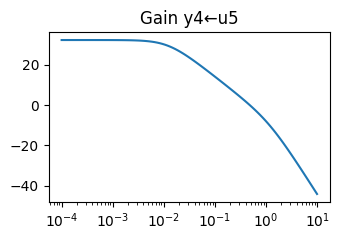

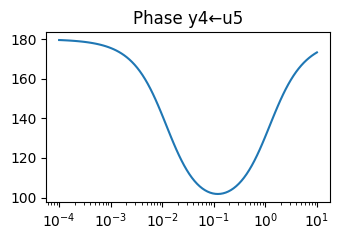

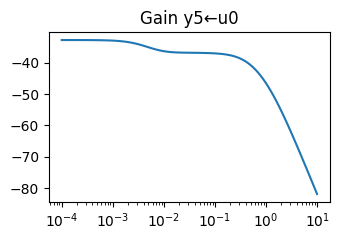

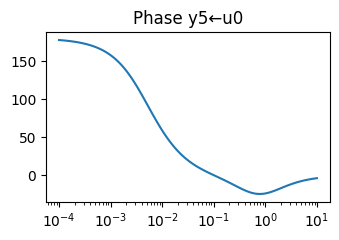

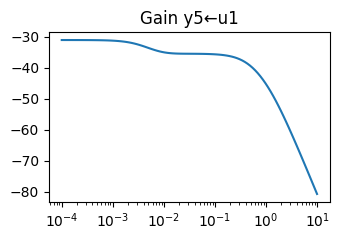

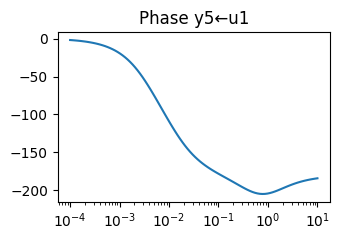

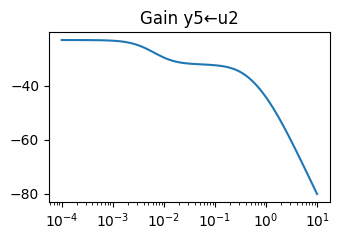

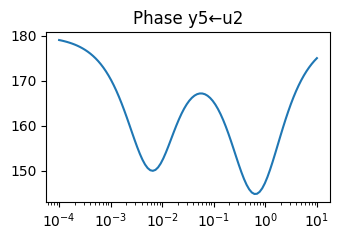

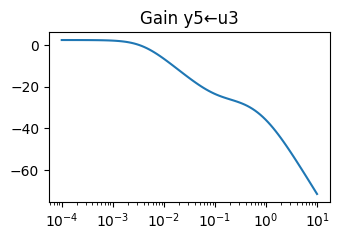

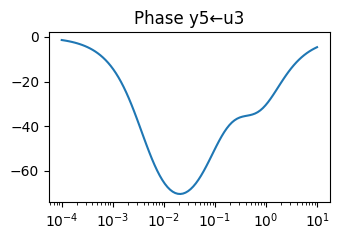

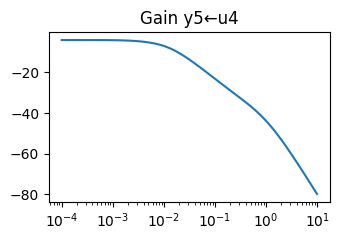

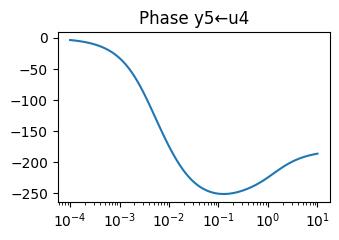

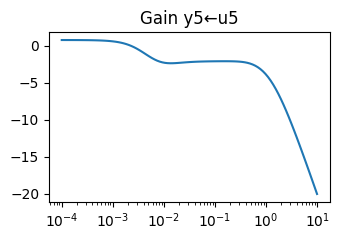

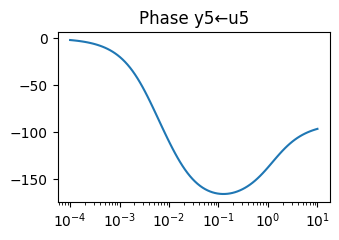

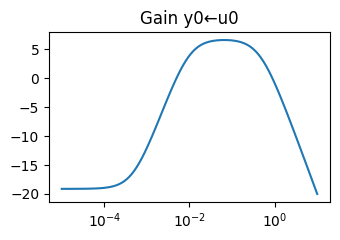

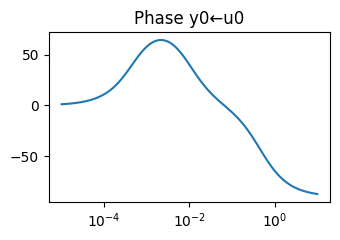

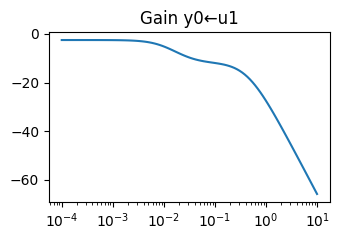

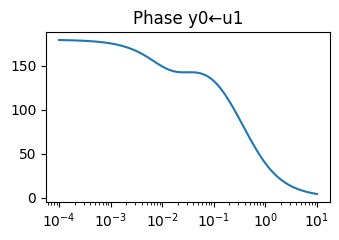

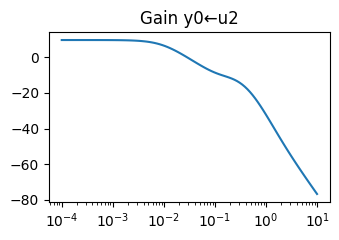

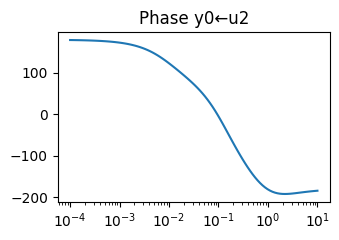

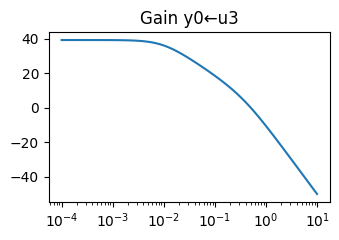

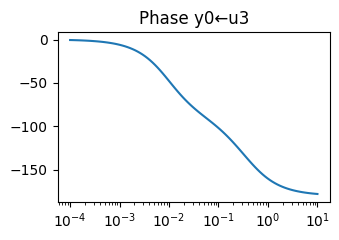

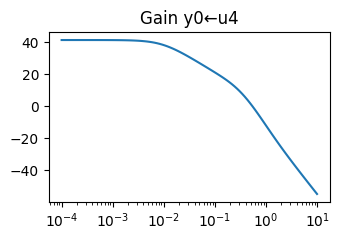

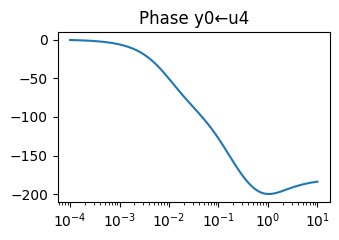

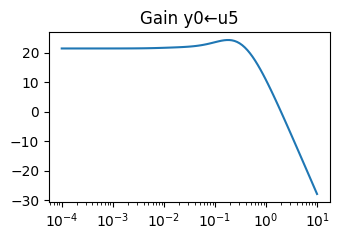

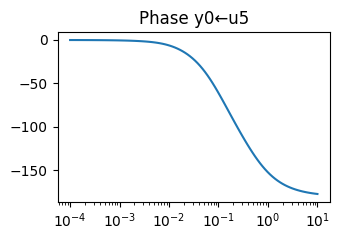

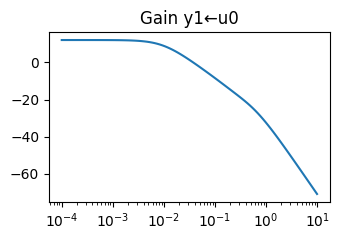

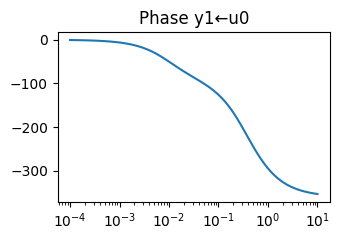

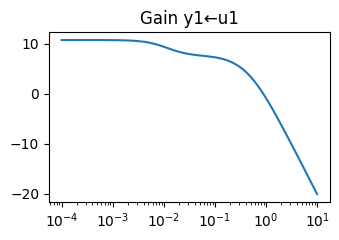

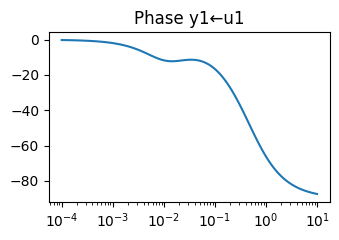

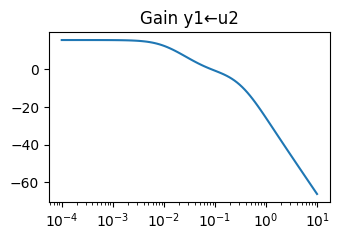

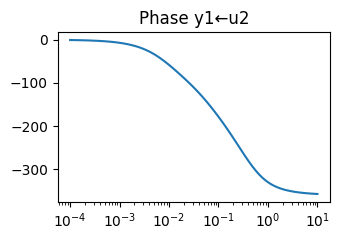

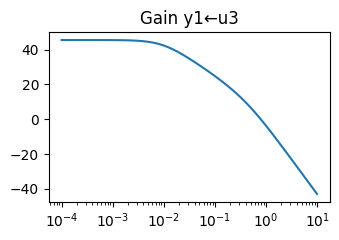

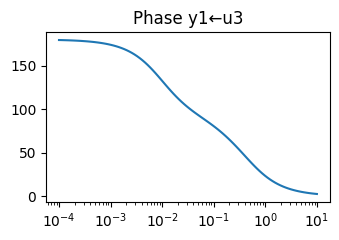

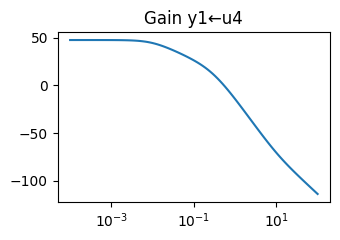

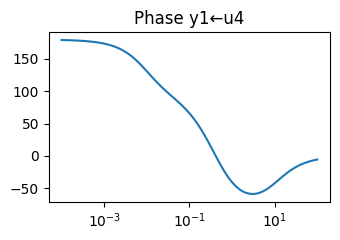

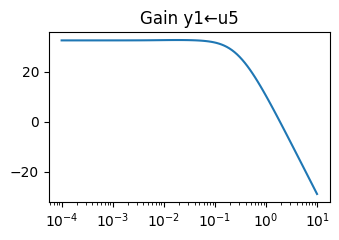

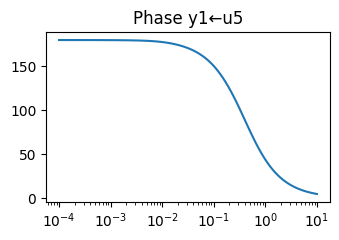

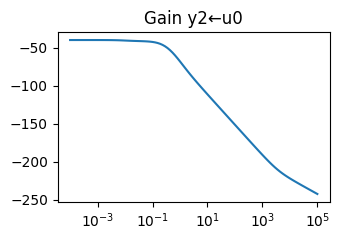

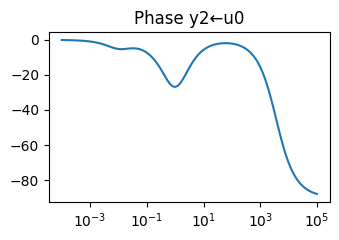

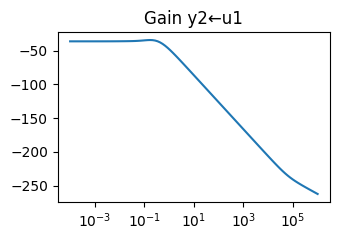

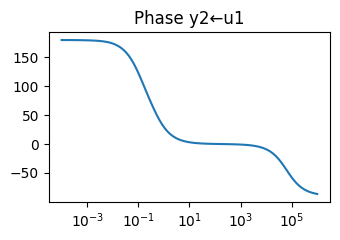

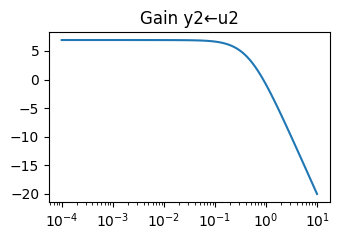

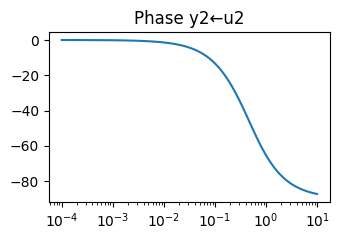

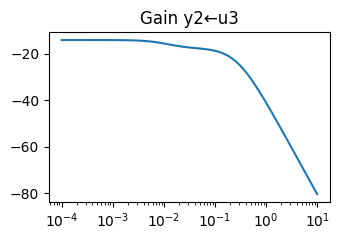

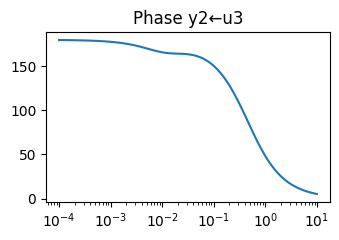

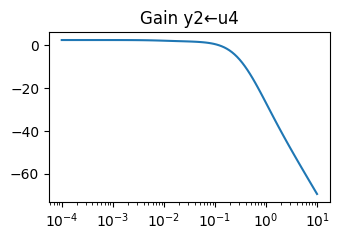

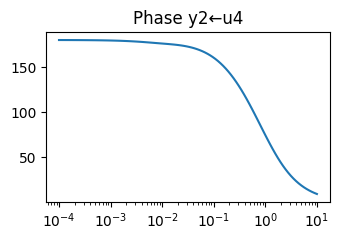

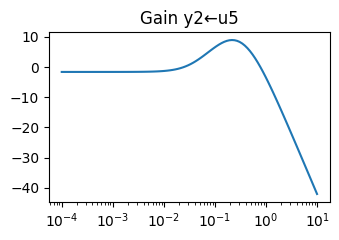

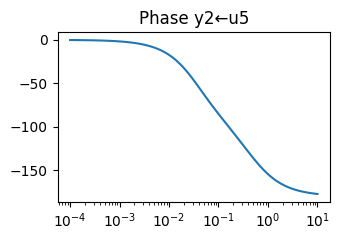

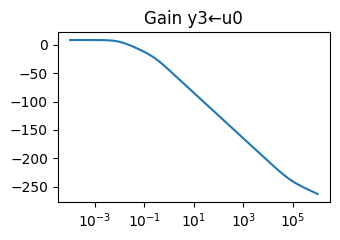

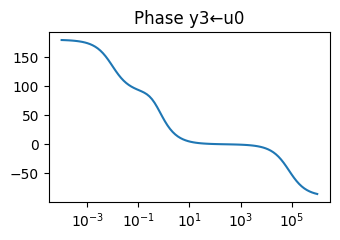

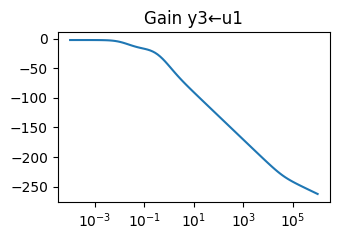

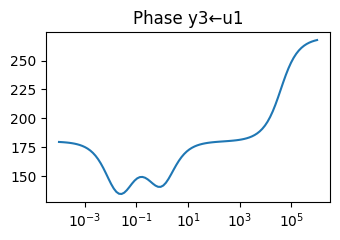

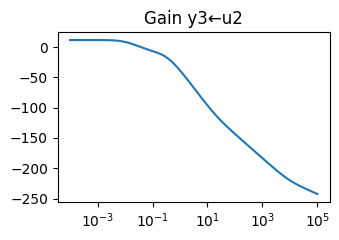

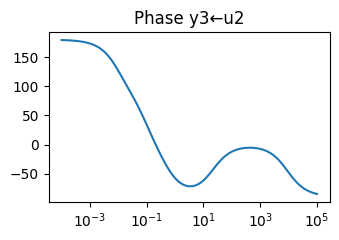

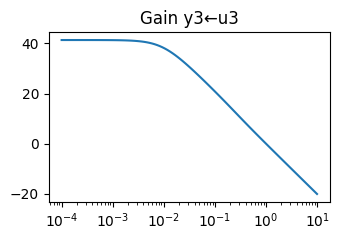

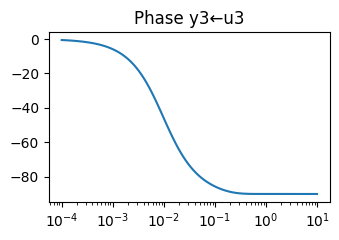

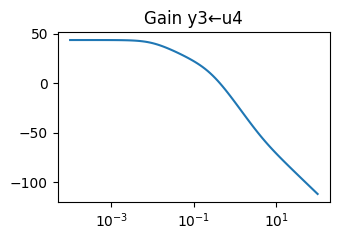

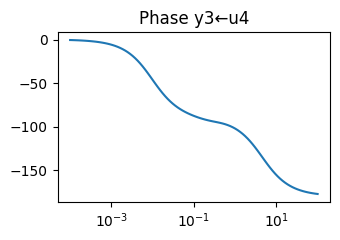

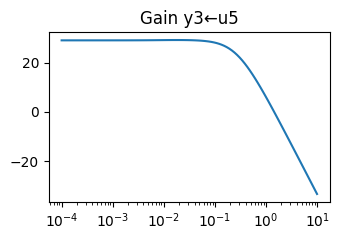

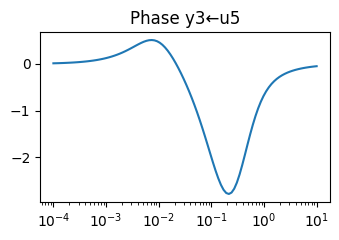

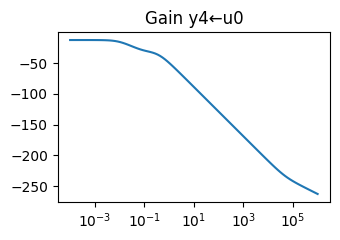

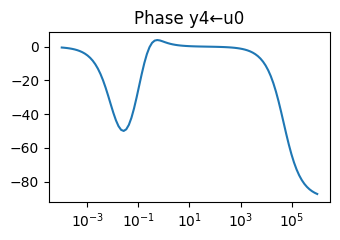

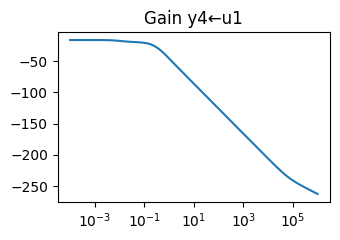

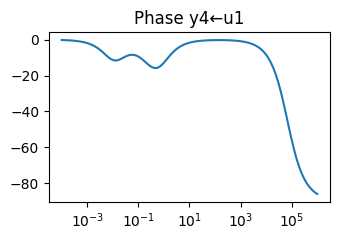

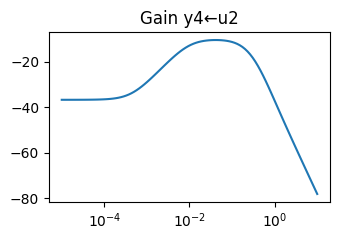

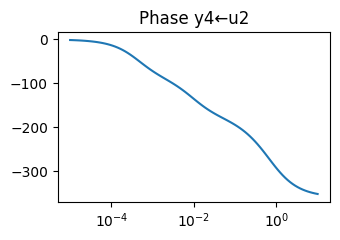

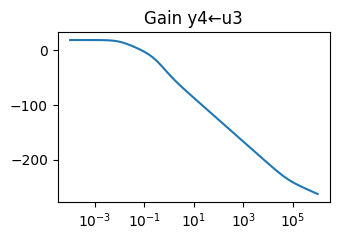

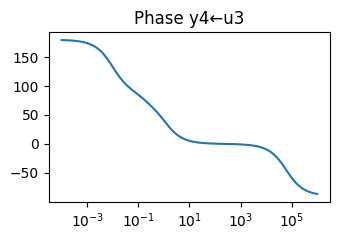

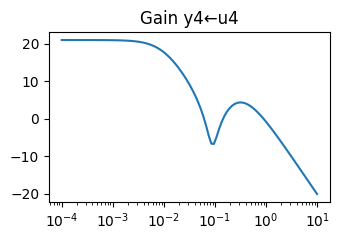

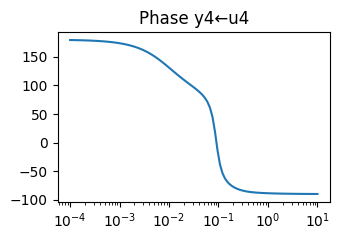

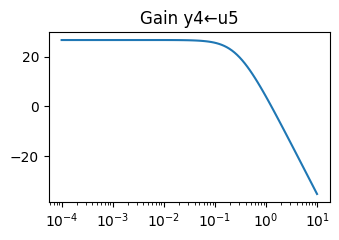

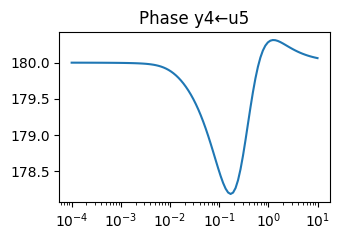

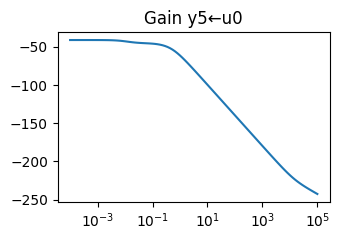

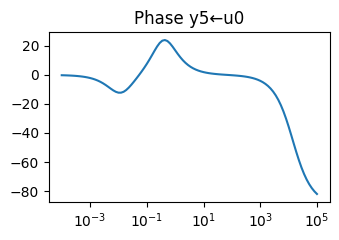

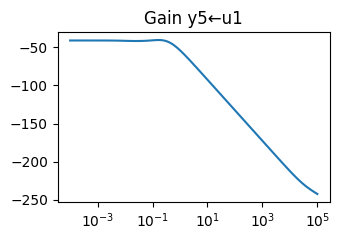

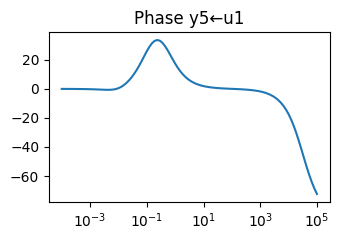

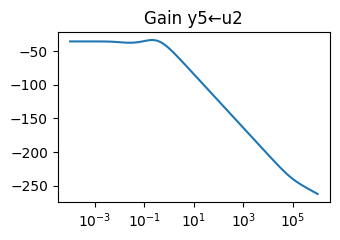

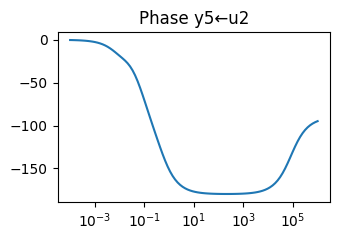

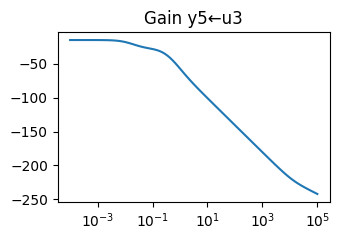

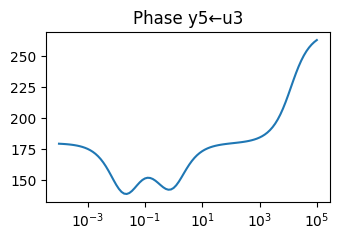

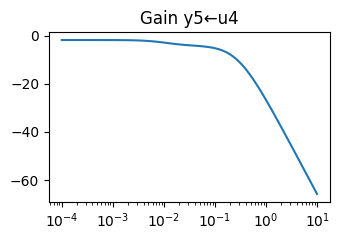

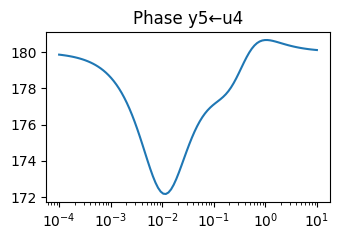

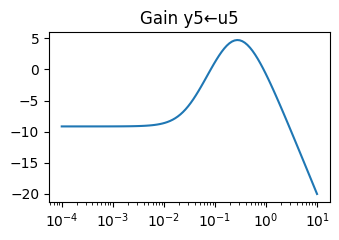

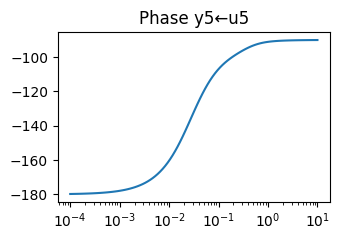

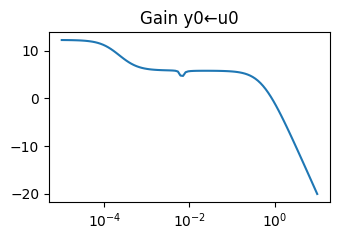

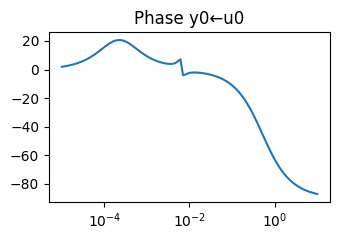

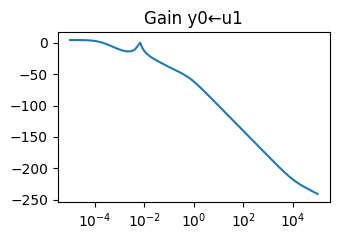

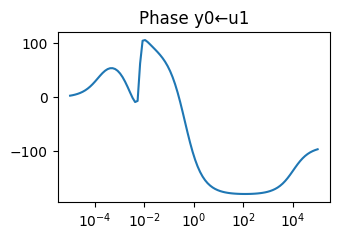

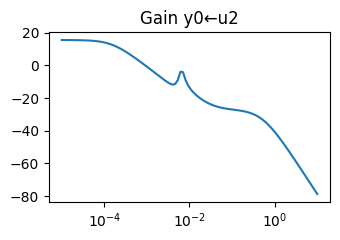

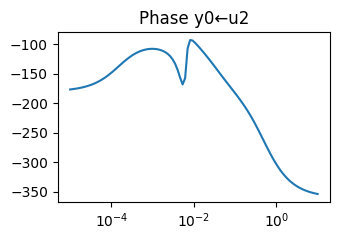

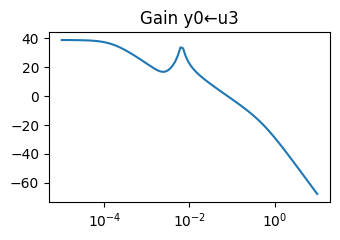

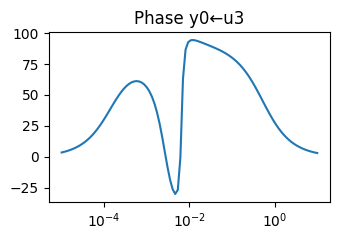

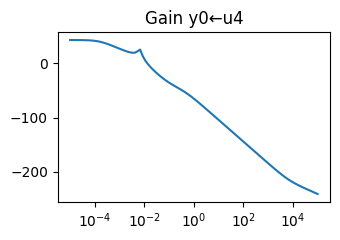

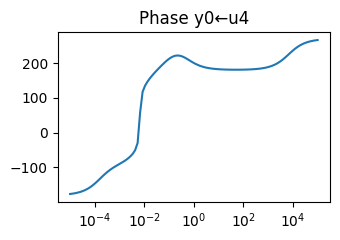

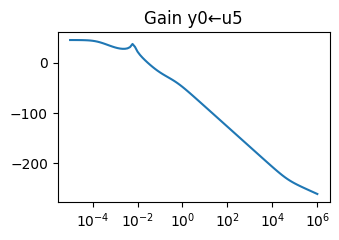

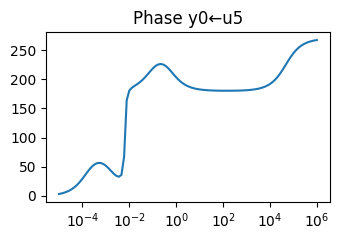

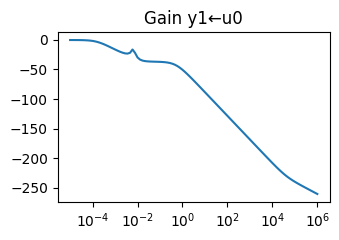

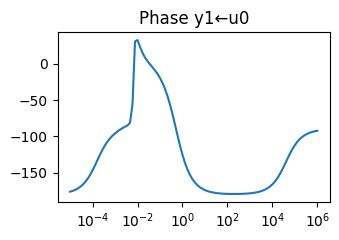

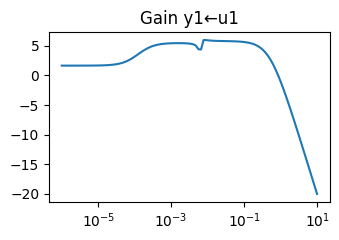

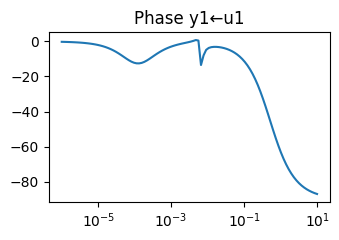

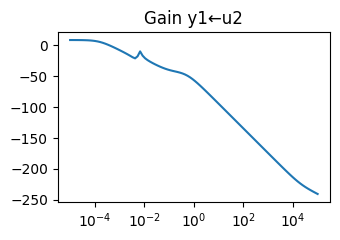

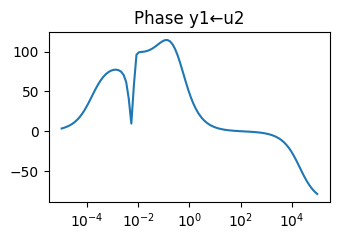

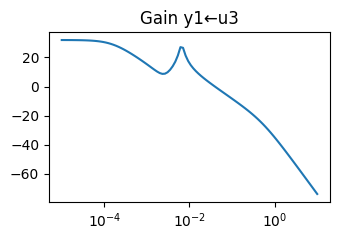

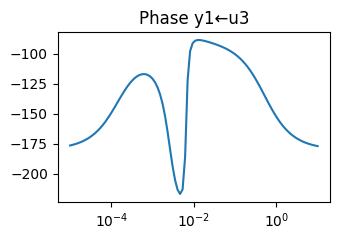

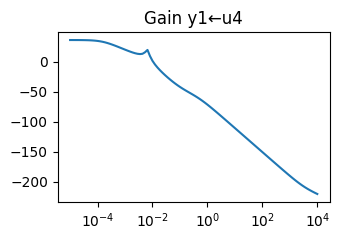

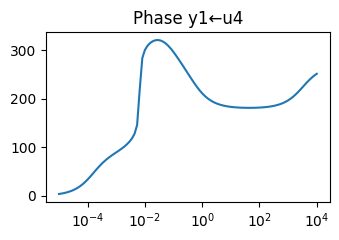

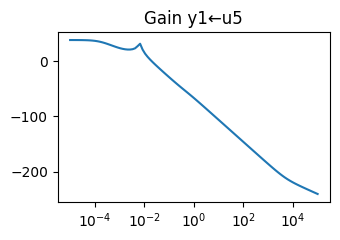

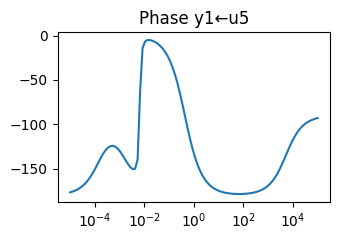

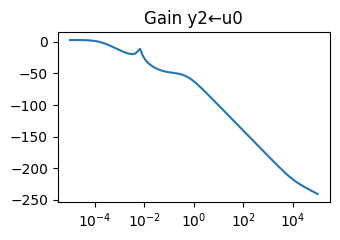

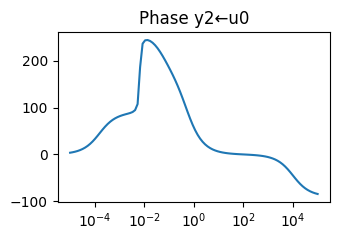

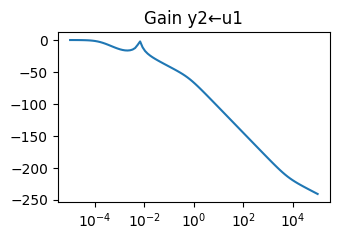

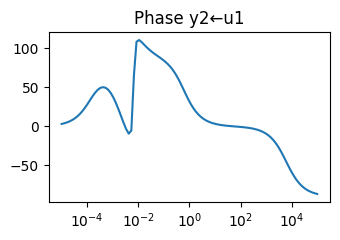

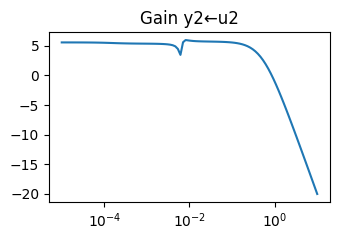

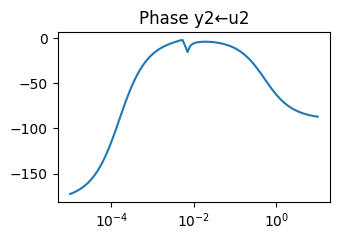

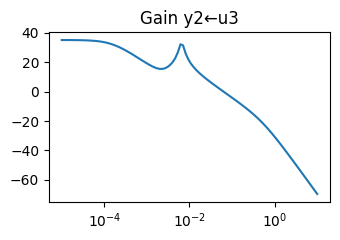

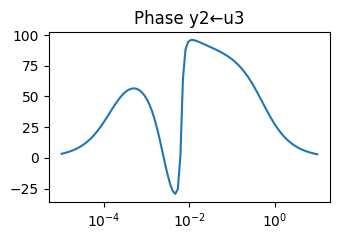

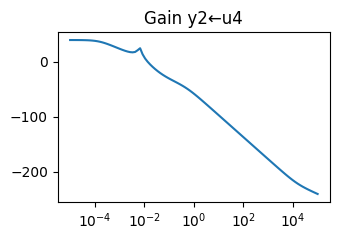

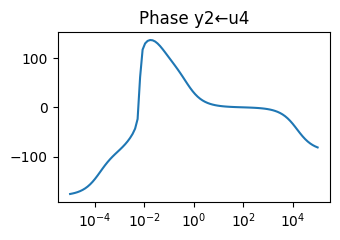

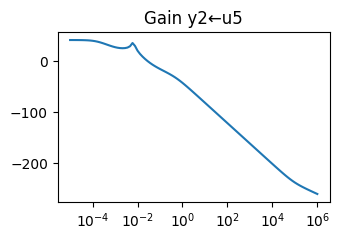

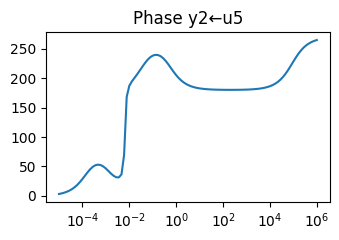

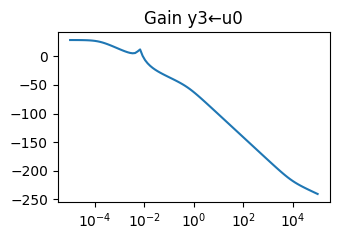

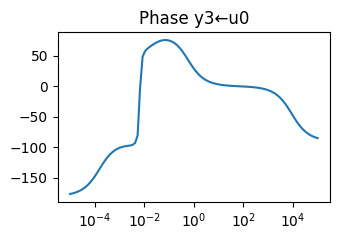

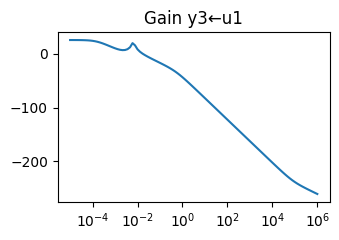

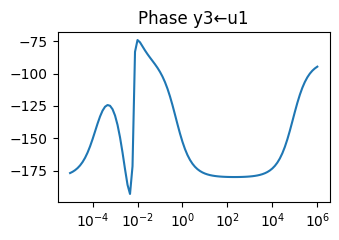

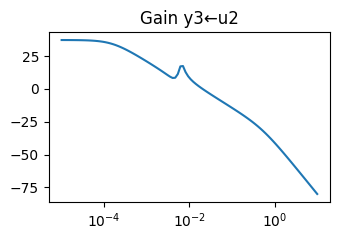

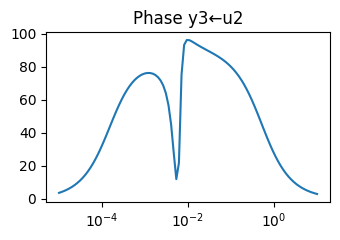

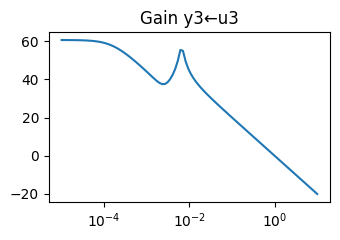

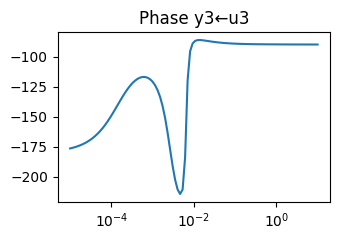

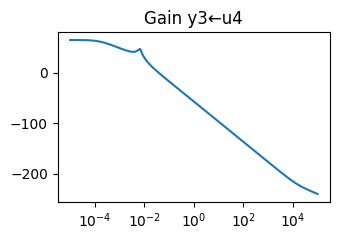

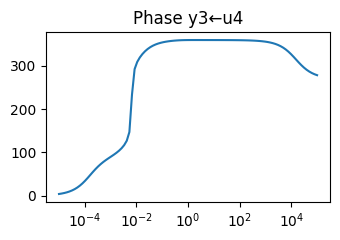

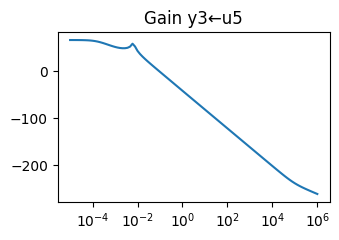

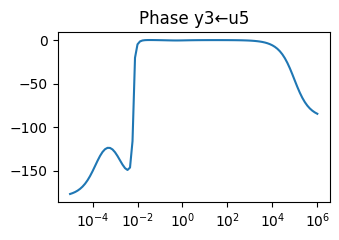

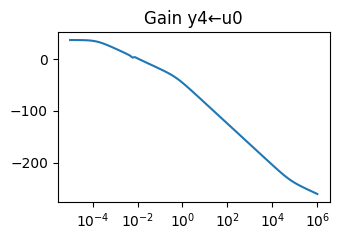

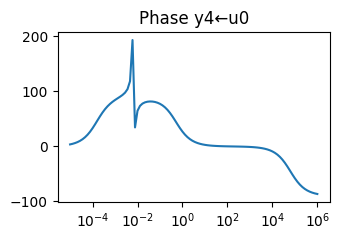

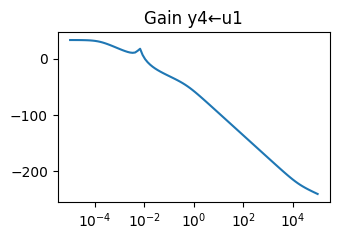

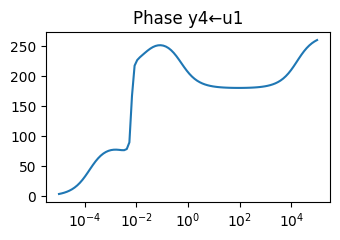

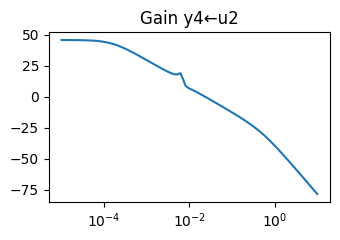

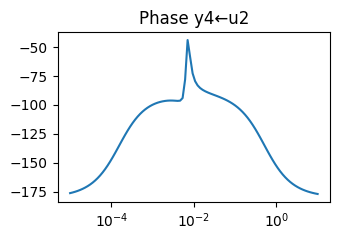

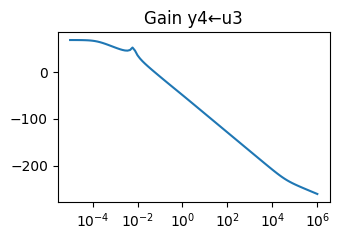

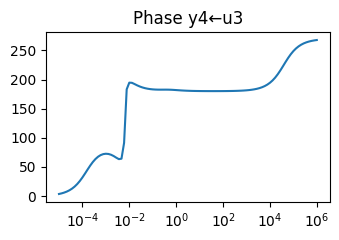

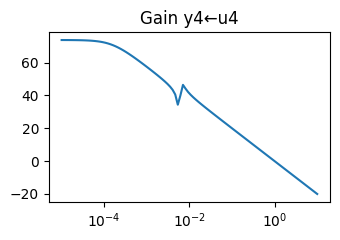

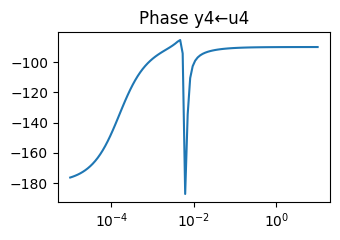

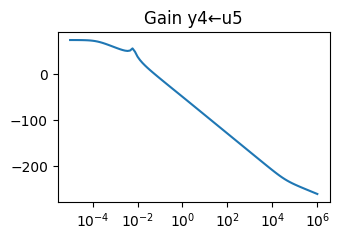

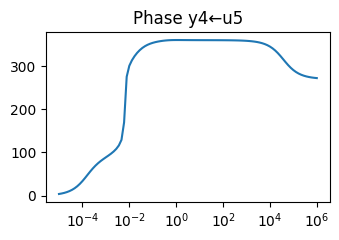

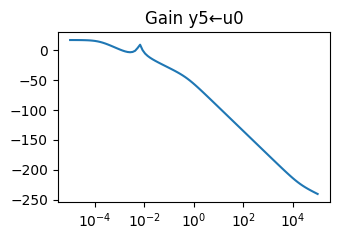

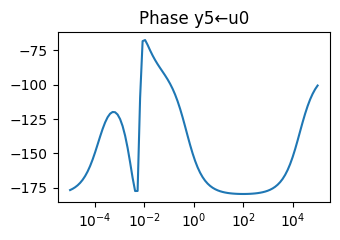

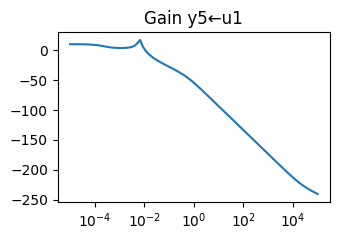

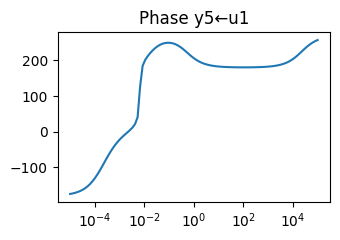

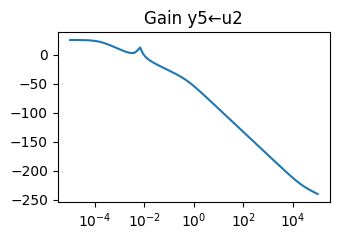

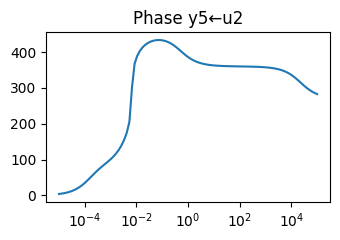

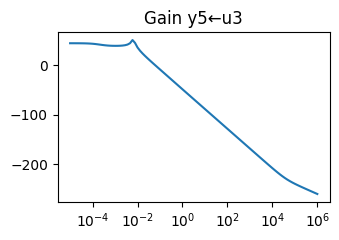

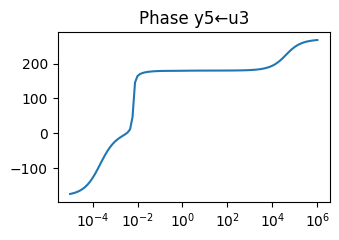

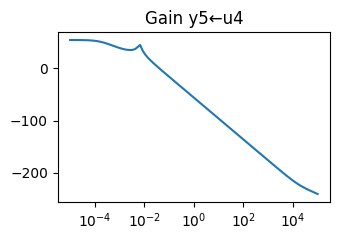

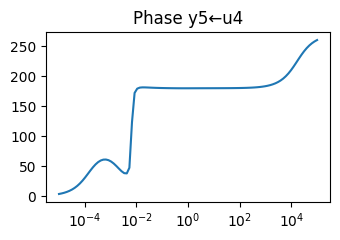

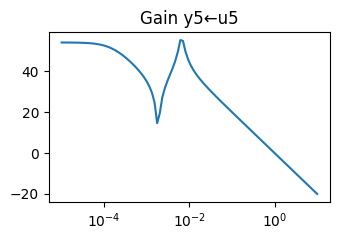

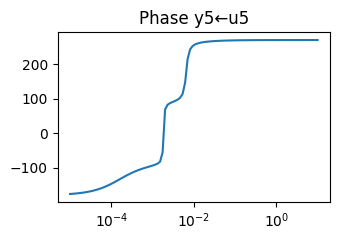

SINDy Xi shape: (6, 1536)
Checked 100 points in 4.24s → max spectral radius = 1.072
Monte Carlo success rate: 0/500 = 0.000
Neuron clusters per layer: [array([1, 1, 1, ..., 1, 3, 1], dtype=int32), array([0, 3, 2, ..., 2, 0, 0], dtype=int32), array([0, 0, 1, ..., 1, 1, 3], dtype=int32), array([0, 1, 3, ..., 0, 2, 1], dtype=int32), array([1, 1, 0, ..., 1, 2, 0], dtype=int32), array([2, 2, 3, ..., 2, 1, 0], dtype=int32), array([3, 3, 1, ..., 2, 2, 3], dtype=int32)]
±10% weights → train MSE 522.7154, test MSE 521.8084
Example adversarial perturbation: [2.0074418  1.3606666  0.07695618] ...


In [ ]:
import time
import numpy as np
import torch
import torch.nn.functional as F
from torch.autograd import grad
from sklearn.linear_model import Lasso
from scipy.signal import lti, bode
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"

# -----------------------------------------------------------------------------
# 0. (Your forward kinematics / data loaders / model definition should go here.)
#    Assume you have:
#      model:            your trained TinyDiT
#      train_s_np,a_np
#      test_s_np,a_np
# -----------------------------------------------------------------------------

# -------------------------------------------------------------------------------
# 1. Flow field oracle
# -------------------------------------------------------------------------------
def flow_field(model, states):
    x = (
        torch.tensor(states, dtype=torch.float32, device=device)
        if not torch.is_tensor(states)
        else states.to(device).float()
    )
    with torch.no_grad():
        u = model(x)
    return u.cpu().numpy()

# -------------------------------------------------------------------------------
# 2. Jacobian‐based Bode plots
# -------------------------------------------------------------------------------
def linearize_and_bode(model, x0):
    x0_t = torch.tensor(x0, requires_grad=True, device=device)
    u0   = model(x0_t.unsqueeze(0)).squeeze(0)  # (d,)
    # build Jacobian A
    A_rows = []
    for i in range(u0.shape[0]):
        grad_ui = grad(u0[i], x0_t, retain_graph=True)[0]
        A_rows.append(grad_ui.cpu().numpy())
    A = np.stack(A_rows, axis=0)  # (d, d)

    d = A.shape[0]
    for i in range(d):
        for j in range(d):
            B = np.zeros((d,1)); B[j,0]=1
            C = np.zeros((1,d)); C[0,i]=1
            sys = lti(A, B, C, np.zeros((1,1)))
            w, mag, phase = bode(sys)
            plt.figure(figsize=(3.5,2.5))
            plt.semilogx(w, mag); plt.title(f"Gain y{i}←u{j}")
            plt.tight_layout(); plt.show()
            plt.figure(figsize=(3.5,2.5))
            plt.semilogx(w, phase); plt.title(f"Phase y{i}←u{j}")
            plt.tight_layout(); plt.show()

# -------------------------------------------------------------------------------
# 3. SINDy sparse regression on a single residual snapshot
# -------------------------------------------------------------------------------
def sindy_fit(residuals, bases, alpha=1e-3):
    Xi = np.zeros((bases.shape[1], residuals.shape[1]))
    for j in range(residuals.shape[1]):
        lasso = Lasso(alpha=alpha, fit_intercept=False, max_iter=5000)
        lasso.fit(bases, residuals[:, j])
        Xi[:, j] = lasso.coef_
    return Xi

# -------------------------------------------------------------------------------
# 4. Approximate Lyapunov / contraction check via spectral radius
# -------------------------------------------------------------------------------
def check_local_contraction(model, states, n_samples=100):
    """
    Sample n_samples random x0 from `states`, compute Jacobian A at x0,
    and report max spectral radius.  <1 ⇒ locally contractive.
    """
    idx = np.random.choice(len(states), min(n_samples, len(states)), replace=False)
    max_rho = 0.0
    t0 = time.time()
    for x0 in states[idx]:
        x0_t = torch.tensor(x0, requires_grad=True, device=device)
        u0   = model(x0_t.unsqueeze(0)).squeeze(0)
        A_rows = []
        for i in range(u0.shape[0]):
            grad_ui = grad(u0[i], x0_t, retain_graph=True)[0]
            A_rows.append(grad_ui.cpu().numpy())
        A = np.stack(A_rows, axis=0)
        rho = max(abs(np.linalg.eigvals(A)))
        max_rho = max(max_rho, rho)
    print(f"Checked {len(idx)} points in {time.time()-t0:.2f}s → max spectral radius = {max_rho:.3f}")

# -------------------------------------------------------------------------------
# 5. Monte Carlo reachability under Gaussian noise
# -------------------------------------------------------------------------------
def monte_carlo_success(model, x0, noise_sigma, steps, dt, goal_fn, trials=500):
    successes = 0
    d = len(x0)
    for _ in range(trials):
        x = x0.copy()
        for _ in range(steps):
            dx = flow_field(model, x[None,:])[0]
            x = x + dt*dx + np.random.randn(d)*noise_sigma
            if goal_fn(x):
                successes += 1
                break
    print(f"Monte Carlo success rate: {successes}/{trials} = {successes/trials:.3f}")

# -------------------------------------------------------------------------------
# 6. Neuron clustering
# -------------------------------------------------------------------------------
def cluster_neurons(acts_list, n_clusters=3):
    from sklearn.cluster import KMeans
    labels_list = []
    for H in acts_list:
        km = KMeans(n_clusters, random_state=0).fit(H.T)
        labels_list.append(km.labels_)
    print("Neuron clusters per layer:", labels_list)

# -------------------------------------------------------------------------------
# 7. Robustness tests
# -------------------------------------------------------------------------------
def perturb_weights_and_eval(model, train_s, train_a, test_s, test_a, eps=0.1):
    orig = {k:v.clone() for k,v in model.state_dict().items()}
    for k,v in model.state_dict().items():
        v.add_(eps*torch.randn_like(v))
    with torch.no_grad():
        mse_tr = F.mse_loss(model(torch.tensor(train_s).float().to(device)),
                            torch.tensor(train_a).float().to(device)).item()
        mse_te = F.mse_loss(model(torch.tensor(test_s).float().to(device)),
                            torch.tensor(test_a).float().to(device)).item()
    model.load_state_dict(orig)
    print(f"±{eps*100:.0f}% weights → train MSE {mse_tr:.4f}, test MSE {mse_te:.4f}")

def adversarial_state_attack(model, x, a_true, eps=0.01):
    x_t = torch.tensor(x, requires_grad=True, device=device)
    pred = model(x_t.unsqueeze(0)).squeeze(0)
    loss = F.mse_loss(pred, torch.tensor(a_true, device=device))
    loss.backward()
    x_adv = x + eps * x_t.grad.sign().cpu().numpy()
    print("Example adversarial perturbation:", x_adv[:3], "...")

# -----------------------------------------------------------------------------
# 8. Put it all together
# -----------------------------------------------------------------------------
if __name__=="__main__":
    # — your model & data have to be in scope: —
    # model, train_s_np, train_a_np, test_s_np, test_a_np

    # 1) Bode plots around a few points
    samples = test_s_np[np.linspace(0,len(test_s_np)-1,3,dtype=int)]
    for x0 in samples:
        linearize_and_bode(model, x0)

    # 2) SINDy on block1 residual
    _, acts = model(torch.tensor(test_s_np).float().to(device), return_acts=True)
    h1 = acts[1].cpu().detach().numpy()
    if h1.ndim>2: h1 = h1.reshape(h1.shape[0],-1)
    Xi = sindy_fit(h1, test_s_np)
    print("SINDy Xi shape:", Xi.shape)

    # 3) Contraction check
    check_local_contraction(model, test_s_np, n_samples=100)

    # 4) Monte Carlo success
    goal = lambda x: np.linalg.norm(x[:3])<0.1
    monte_carlo_success(model, test_s_np[0], noise_sigma=0.05,
                        steps=50, dt=0.02, goal_fn=goal)

    # 5) Cluster neurons
    acts_list = [a.cpu().detach().numpy().reshape(a.shape[0],-1) for a in acts]
    cluster_neurons(acts_list, n_clusters=4)

    # 6) Robustness
    perturb_weights_and_eval(model,
        train_s_np, train_a_np,
        test_s_np,  test_a_np,
        eps=0.1)
    adversarial_state_attack(model,
        test_s_np[0], test_a_np[0],
        eps=0.01)

Tier 10

Point Mass Navigation

In [ ]:
# ──────────────────────────────────────────────────────────────────────────────
# 0) Imports & Device
# ──────────────────────────────────────────────────────────────────────────────
import numpy as np
import torch, random
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.cluster import KMeans
from sklearn.linear_model import Lasso
import matplotlib.pyplot as plt
import networkx as nx

device = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(0); np.random.seed(0); random.seed(0)

In [ ]:
# ──────────────────────────────────────────────────────────────────────────────
# 1) Data: PointMassNav (state=(x,y,x*,y*), action=Δ(x,y)=k*(goal−pos))
# ──────────────────────────────────────────────────────────────────────────────
def gen_pointmass_nav(n=60000, k=0.5, seed=None):
    rng = np.random.default_rng(seed)
    pos  = rng.uniform(-1,1,(n,2)).astype("float32")
    goal = rng.uniform(-1,1,(n,2)).astype("float32")
    state = np.concatenate([pos, goal], axis=1)
    act   = k*(goal - pos)
    return torch.from_numpy(state), torch.from_numpy(act)

train_s, train_a = gen_pointmass_nav(60000, k=0.5, seed=0)
test_s,  test_a  = gen_pointmass_nav( 8192, k=0.5, seed=1)

train_loader = DataLoader(TensorDataset(train_s, train_a), batch_size=1024, shuffle=True)
test_loader  = DataLoader(TensorDataset(test_s,  test_a),  batch_size=4096)

In [ ]:
# ──────────────────────────────────────────────────────────────────────────────
# 2) Model: TinyDiT for 4→2 regression
# ──────────────────────────────────────────────────────────────────────────────
class TinyDiT(nn.Module):
    def __init__(self, state_dim=4, action_dim=2, width=64, depth=4):
        super().__init__()
        self.in_proj  = nn.Linear(state_dim, width)
        self.blocks   = nn.ModuleList([
            nn.Sequential(
                nn.LayerNorm(width),
                nn.Linear(width, width*4),
                nn.GELU(),
                nn.Linear(width*4, width)
            ) for _ in range(depth)
        ])
        self.out_proj = nn.Linear(width, action_dim)

    def forward(self, x, return_acts=False):
        h = self.in_proj(x)
        acts = [h]
        for blk in self.blocks:
            h = h + blk(h)
            acts.append(h)
        out = self.out_proj(h)
        return (out, acts) if return_acts else out

model = TinyDiT().to(device)

In [ ]:
# ──────────────────────────────────────────────────────────────────────────────
# 3) Training
# ──────────────────────────────────────────────────────────────────────────────
def train(model, loader, epochs=20, lr=3e-3):
    opt = torch.optim.AdamW(model.parameters(), lr=lr)
    for ep in range(1, epochs+1):
        model.train()
        total, count = 0.0, 0
        for x,a in loader:
            x,a = x.to(device), a.to(device)
            pred = model(x)
            loss = F.mse_loss(pred, a)
            opt.zero_grad(); loss.backward(); opt.step()
            total += loss.item()*x.size(0)
            count += x.size(0)
        print(f"Epoch {ep}/{epochs}  Train MSE = {total/count:.5f}")

train(model, train_loader, epochs=20, lr=3e-3)

Epoch 1/20  Train MSE = 0.08816
Epoch 2/20  Train MSE = 0.00026
Epoch 3/20  Train MSE = 0.00011
Epoch 4/20  Train MSE = 0.00007
Epoch 5/20  Train MSE = 0.00005
Epoch 6/20  Train MSE = 0.00003
Epoch 7/20  Train MSE = 0.00003
Epoch 8/20  Train MSE = 0.00002
Epoch 9/20  Train MSE = 0.00002
Epoch 10/20  Train MSE = 0.00001
Epoch 11/20  Train MSE = 0.00001
Epoch 12/20  Train MSE = 0.00001
Epoch 13/20  Train MSE = 0.00001
Epoch 14/20  Train MSE = 0.00001
Epoch 15/20  Train MSE = 0.00001
Epoch 16/20  Train MSE = 0.00001
Epoch 17/20  Train MSE = 0.00001
Epoch 18/20  Train MSE = 0.00001
Epoch 19/20  Train MSE = 0.00000
Epoch 20/20  Train MSE = 0.00000


In [ ]:
# ──────────────────────────────────────────────────────────────────────────────
# 4) Test
# ──────────────────────────────────────────────────────────────────────────────
model.eval()
with torch.no_grad():
    mse = F.mse_loss(model(test_s.to(device)), test_a.to(device)).item()
print("Test MSE =", round(mse,5))

Test MSE = 0.0


In [ ]:
# ──────────────────────────────────────────────────────────────────────────────
# 5) Collect activations on test set
# ──────────────────────────────────────────────────────────────────────────────
def get_activations(model, loader):
    model.eval()
    all_acts = None
    with torch.no_grad():
        for x,_ in loader:
            x = x.to(device)
            _, acts = model(x, return_acts=True)
            acts = [h.cpu().numpy() for h in acts]
            if all_acts is None:
                all_acts = acts
            else:
                for i in range(len(acts)):
                    all_acts[i] = np.vstack([all_acts[i], acts[i]])
    return all_acts

all_acts = get_activations(model, test_loader)
# all_acts[L] has shape (N, width)

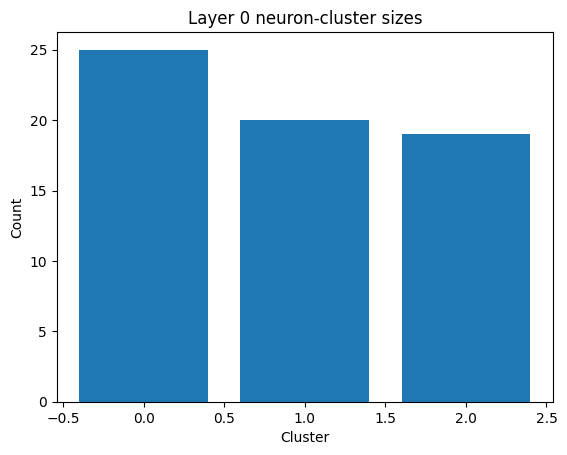

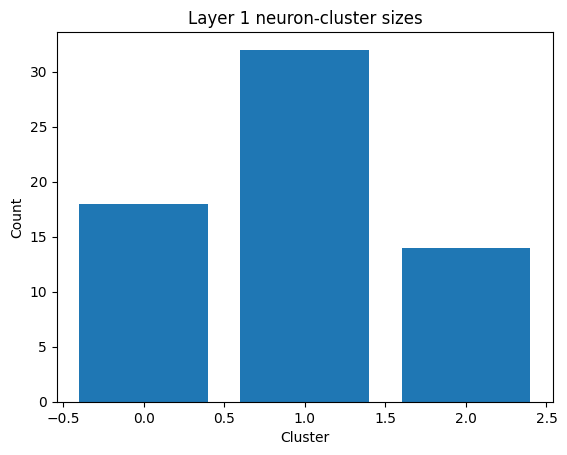

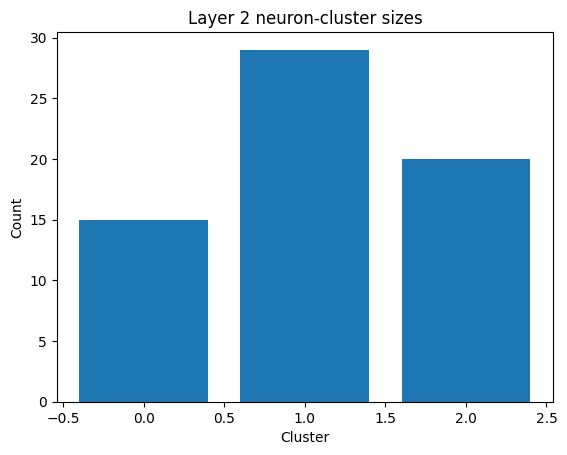

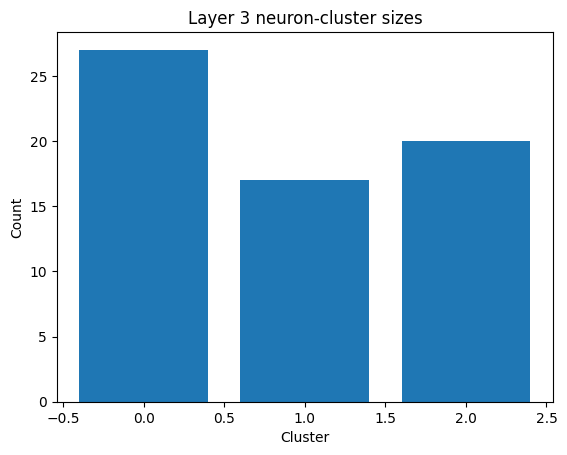

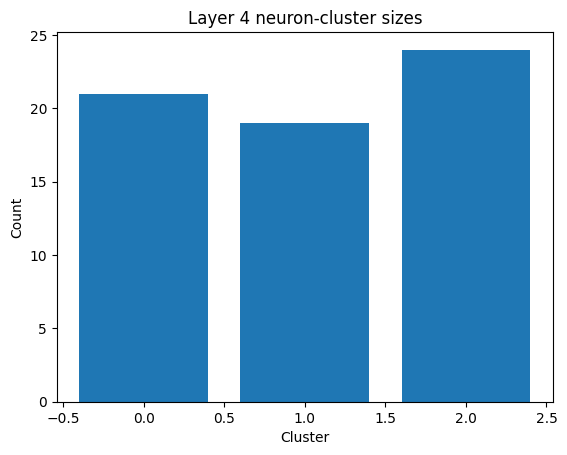

In [ ]:
# ──────────────────────────────────────────────────────────────────────────────
# 6) Neuron Clustering & Visualization
# ──────────────────────────────────────────────────────────────────────────────
labels = []
for L, H in enumerate(all_acts):
    km = KMeans(3, random_state=0).fit(H.T)
    labels.append(km.labels_)
    counts = np.bincount(km.labels_)
    plt.figure()
    plt.bar(range(len(counts)), counts)
    plt.title(f"Layer {L} neuron‐cluster sizes")
    plt.xlabel("Cluster"); plt.ylabel("Count")
    plt.show()

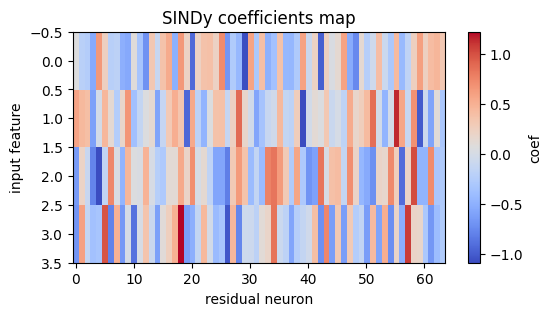

In [ ]:
# ──────────────────────────────────────────────────────────────────────────────
# 7) SINDy Sparse Regression & Heatmap
# ──────────────────────────────────────────────────────────────────────────────
# Use raw state dims as basis → first residual layer activations
H1 = all_acts[1]                         # shape (N, width)
bases = test_s.numpy()                  # shape (N,4)
Xi = np.zeros((bases.shape[1], H1.shape[1]))
for j in range(H1.shape[1]):
    lasso = Lasso(alpha=1e-3, fit_intercept=False, max_iter=5000)
    lasso.fit(bases, H1[:,j])
    Xi[:,j] = lasso.coef_

plt.figure(figsize=(6,3))
plt.imshow(Xi, aspect="auto", cmap="coolwarm")
plt.colorbar(label="coef");
plt.xlabel("residual neuron"); plt.ylabel("input feature")
plt.title("SINDy coefficients map"); plt.show()

Top distance‐neuron index: 7


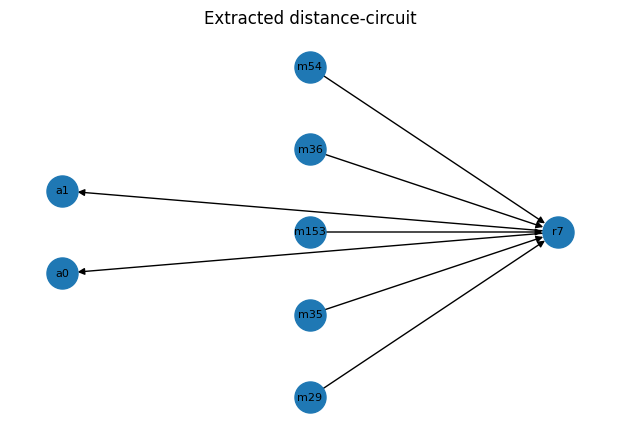

In [ ]:
# ──────────────────────────────────────────────────────────────────────────────
# 8) Circuit Extraction Graph
# ──────────────────────────────────────────────────────────────────────────────
#  8a) find the neuron most correlated with distance to goal
pos = test_s.numpy()[:,:2]
goal= test_s.numpy()[:,2:4]
dist = np.linalg.norm(goal-pos, axis=1, keepdims=True)  # (N,1)

res_fin = all_acts[-1]                   # final residual (N,width)
corrs = np.corrcoef(res_fin.T, dist.flatten())[-1,:-1]
top_idx = np.argmax(np.abs(corrs))
print("Top distance‐neuron index:", top_idx)

#  8b) trace back through last block MLP
# layer2 weights: second linear in block
W2 = model.blocks[-1][3].weight.detach().cpu().numpy()   # (width,4*width)
row = W2[top_idx]                                         # (4*width,)
k = 5
top_mlp_idxs = np.argsort(np.abs(row))[-k:]

#  8c) graph nodes & edges
G = nx.DiGraph()
# add top residual neuron
G.add_node(f"r{top_idx}", layer="res_final")
# add top‐k MLP dims
for idx in top_mlp_idxs:
    G.add_node(f"m{idx}", layer="mlp2")
    G.add_edge(f"m{idx}", f"r{top_idx}")

# out_proj weights for action‐dim0
Wout = model.out_proj.weight.detach().cpu().numpy()      # (2,width)
for act_dim in [0,1]:
    w = Wout[act_dim, top_idx]
    node = f"a{act_dim}"
    G.add_node(node, layer="action")
    G.add_edge(f"r{top_idx}", node, weight=round(w,3))

# visualize
pos = nx.multipartite_layout(G, subset_key="layer")
plt.figure(figsize=(6,4))
nx.draw(G, pos, with_labels=True, node_size=500, font_size=8)
plt.title("Extracted distance‐circuit"); plt.show()


1) Bode @ sample points:
  ✔️  Bode on 2×2 block


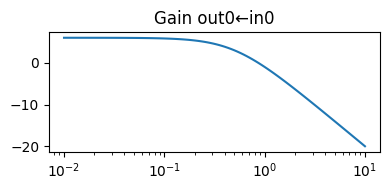

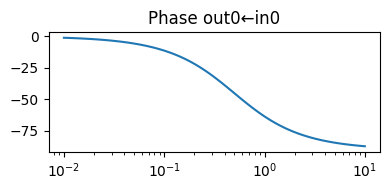

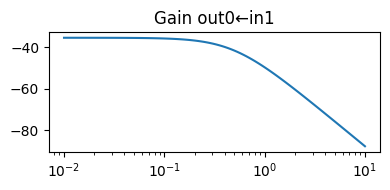

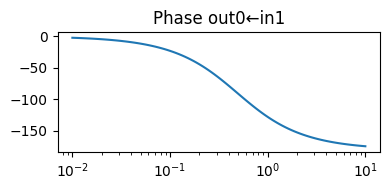

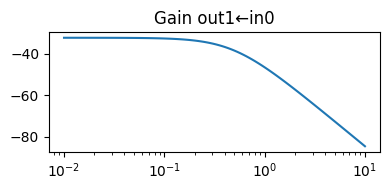

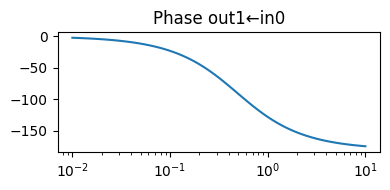

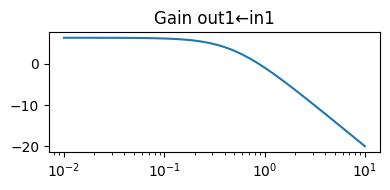

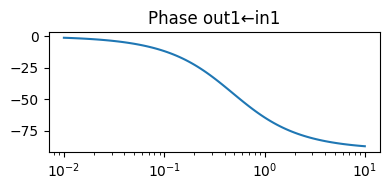

  ✔️  Bode on 2×2 block


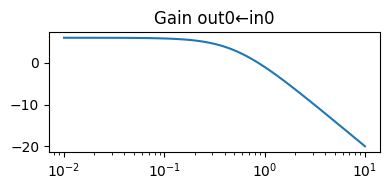

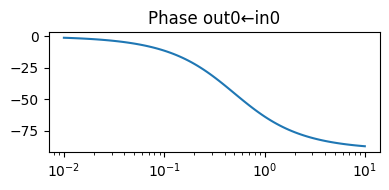

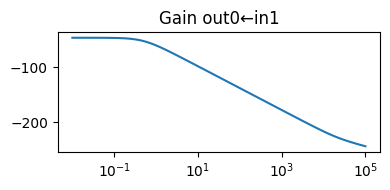

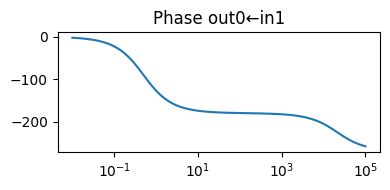

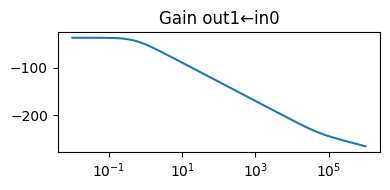

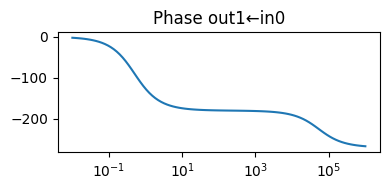

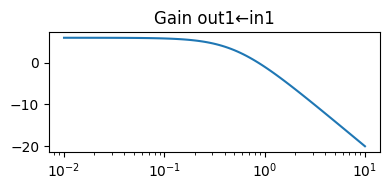

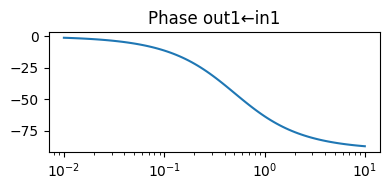

  ✔️  Bode on 2×2 block


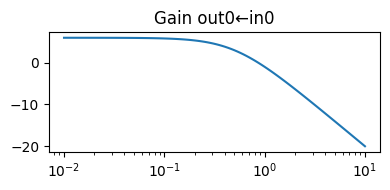

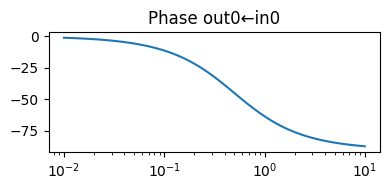

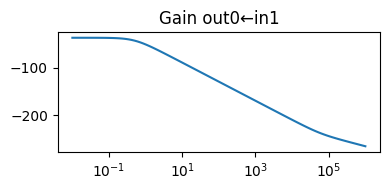

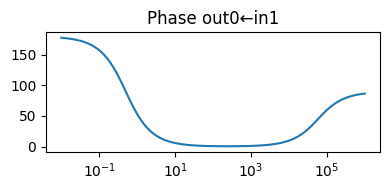

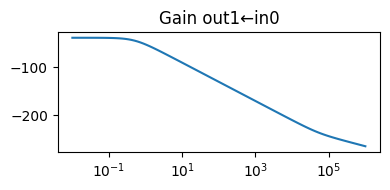

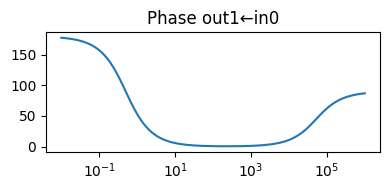

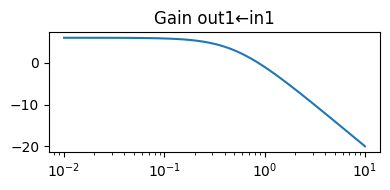

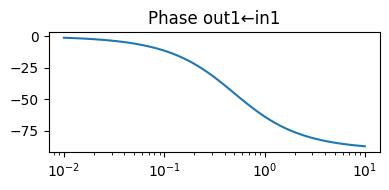


1) Spectral‐radius sweep:


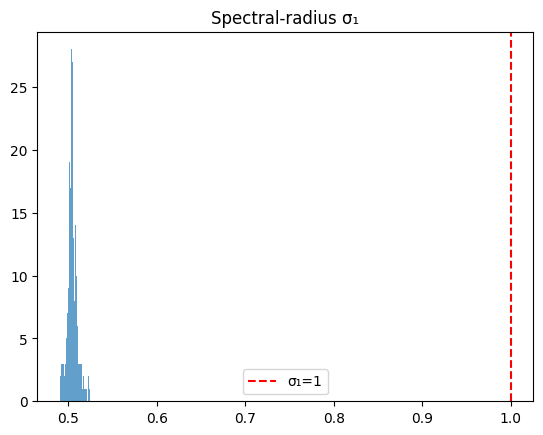


2) Divergence + Contraction:


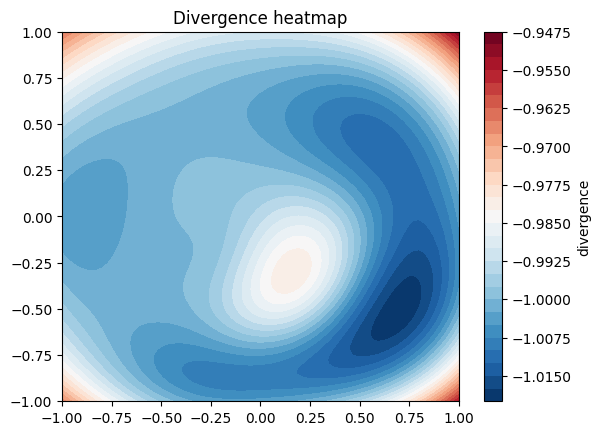

6400/6400 locations contractive (100.0%)

3) Reachability & Monte‐Carlo:
Success rate: 145/200 = 0.725
Ellipsoid @ k=10:
 [[ 9.13278839e-09 -1.33009905e-09]
 [-1.33009905e-09  4.34059506e-09]]

4) Robustness & FGSM:
±10% weight noise → train MSE 5.5653, test MSE 5.5366
Original: [ 0.02364325  0.90092736 -0.87489897  0.9492913 ] 
Adversarial: [ 0.03364325  0.8909274  -0.88489896  0.9592913 ]


In [ ]:
import numpy as np
import torch
import torch.nn.functional as F
from torch.autograd import grad
from scipy.signal import lti, bode
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"

# ──────────────────────────────────────────────────────────────────────────────
#  Helpers
# ──────────────────────────────────────────────────────────────────────────────
def compute_jacobian(model, x0):
    """
    Returns J = ∂f/∂x at x0, always as float32 numpy.
    """
    x0_t = torch.tensor(x0, dtype=torch.float32, device=device, requires_grad=True)
    u0   = model(x0_t.unsqueeze(0)).squeeze(0)           # (action_dim,)
    J    = []
    for i in range(u0.shape[0]):
        gi = grad(u0[i], x0_t, retain_graph=True)[0]     # (state_dim,)
        J.append(gi.cpu().numpy().astype(np.float32))
    return np.stack(J, axis=0)                           # shape (action_dim, state_dim)

def flow_step(model, x):
    """
    One‐step flow: f(x) ∈ ℝ^action_dim
    """
    xt = torch.tensor(x[None], dtype=torch.float32, device=device)
    with torch.no_grad():
        y = model(xt).cpu().numpy()[0]
    return y.astype(np.float32)

# ──────────────────────────────────────────────────────────────────────────────
# 1) Local Stability & Bode
# ──────────────────────────────────────────────────────────────────────────────
def bode_at(model, x0):
    """
    Linearize f at x0, auto‐extract the square block for Bode:
      J  shape = (m, n)
      take A = J[:, :m]  => (m×m)
    """
    J = compute_jacobian(model, x0)    # (m, n)
    m, n = J.shape
    if m > n:
        print(f"  ⚠️ cannot form square block from {m}×{n}, skipping Bode")
        return
    A = J[:, :m]                       # (m×m) square
    print(f"  ✔️  Bode on {m}×{m} block")
    for i in range(m):
        for j in range(m):
            B = np.zeros((m,1), dtype=np.float32); B[j,0] = 1
            C = np.zeros((1,m), dtype=np.float32); C[0,i] = 1
            D = np.zeros((1,1), dtype=np.float32)
            sys = lti(A, B, C, D)
            w, mag, phase = bode(sys)
            plt.figure(figsize=(4,2))
            plt.semilogx(w, mag)
            plt.title(f"Gain out{i}←in{j}"); plt.tight_layout(); plt.show()

            plt.figure(figsize=(4,2))
            plt.semilogx(w, phase)
            plt.title(f"Phase out{i}←in{j}"); plt.tight_layout(); plt.show()

def spectral_radius_sweep(model, states, n=200):
    """
    Histogram of top singular value σ₁(J(x)) over a random subset.
    """
    idx = np.random.choice(len(states), min(n,len(states)), replace=False)
    radii = []
    for i in idx:
        J = compute_jacobian(model, states[i])
        σ = np.linalg.svd(J[:, :J.shape[0]], compute_uv=False)[0]
        radii.append(σ)
    plt.hist(radii, bins=30, alpha=0.7)
    plt.axvline(1.0, color='r', ls='--', label='σ₁=1')
    plt.title("Spectral‐radius σ₁"); plt.legend(); plt.show()

# ──────────────────────────────────────────────────────────────────────────────
# 2) Contraction & Divergence
# ──────────────────────────────────────────────────────────────────────────────
def divergence_heatmap(model, xs, ys, fixed_goal):
    """
    For a 4‐dim PointMassNav state [x,y, gx,gy],
    fixed_goal = (gx,gy) keeps goal static.
    """
    X, Y = np.meshgrid(xs, ys)
    Z     = np.zeros_like(X, dtype=np.float32)
    for i in range(Z.shape[0]):
        for j in range(Z.shape[1]):
            x,y = float(X[i,j]), float(Y[i,j])
            state = np.array([x,y, *fixed_goal], np.float32)
            J = compute_jacobian(model, state)
            # divergence = trace of J w.r.t. dynamic dims (first m)
            div = np.trace(J[:, :J.shape[0]])
            Z[i,j] = div
    plt.contourf(X, Y, Z, 30, cmap="RdBu_r")
    plt.colorbar(label="divergence"); plt.title("Divergence heatmap"); plt.show()

def contraction_fraction(model, xs, ys, fixed_goal):
    """
    Fraction of grid‐points where σ₁(J) < 1.
    """
    total = 0; good = 0
    for x in xs:
        for y in ys:
            state = np.array([x,y, *fixed_goal], np.float32)
            J = compute_jacobian(model, state)
            σ = np.linalg.svd(J[:, :J.shape[0]], compute_uv=False)[0]
            total += 1
            if σ < 1: good += 1
    print(f"{good}/{total} locations contractive ({100*good/total:.1f}%)")

# ──────────────────────────────────────────────────────────────────────────────
# 3) Reachability & Monte‐Carlo
# ──────────────────────────────────────────────────────────────────────────────
def monte_carlo_success(model, x0, goal_fn, noise=0.05, steps=50, dt=0.02, trials=200):
    """
    x0: 4‐dim PointMassNav state = [x,y,gx,gy]
    flow_step(model, state) → (dx,dy)
    """
    successes = 0
    for _ in range(trials):
        state = x0.copy().astype(np.float32)  # [x,y,gx,gy]
        for _ in range(steps):
            # get Δx,Δy only
            dx, dy = flow_step(model, state)   # shape (2,)
            # update only the position dims
            noise_xy = np.random.randn(2).astype(np.float32) * noise
            state[0:2] = state[0:2] + dt * np.array([dx, dy], np.float32) + noise_xy
            # leave state[2:] (gx,gy) untouched
            if goal_fn(state):
                successes += 1
                break
    print(f"Success rate: {successes}/{trials} = {successes/trials:.3f}")

def ellipsoid_reach(A, Q0, k=10):
    Q = Q0.copy()
    for _ in range(k):
        Q = A.dot(Q).dot(A.T)
    return Q

# ──────────────────────────────────────────────────────────────────────────────
# 4) Robustness & Adversarial
# ──────────────────────────────────────────────────────────────────────────────
def perturb_weights(model, train_s, train_a, test_s, test_a, eps=0.1):
    orig = {k:v.clone() for k,v in model.state_dict().items()}
    for k,v in model.state_dict().items():
        model.state_dict()[k].add_(eps * torch.randn_like(v))
    with torch.no_grad():
        tr = F.mse_loss(model(train_s.to(device)), train_a.to(device)).item()
        te = F.mse_loss(model(test_s.to(device)),  test_a.to(device)).item()
    model.load_state_dict(orig)
    print(f"±{eps*100:.0f}% weight noise → train MSE {tr:.4f}, test MSE {te:.4f}")

def fgsm_attack(model, x, a_true, eps=0.01):
    x_t = torch.tensor(x, requires_grad=True, device=device).float()
    pred = model(x_t.unsqueeze(0)).squeeze(0)
    loss = F.mse_loss(pred, torch.tensor(a_true, device=device))
    loss.backward()
    return x + eps * x_t.grad.sign().cpu().numpy()

# ──────────────────────────────────────────────────────────────────────────────
#  Run everything on PointMassNav
# ──────────────────────────────────────────────────────────────────────────────
# assume `model`, `train_s`, `train_a`, `test_s`, `test_a` are already defined
test_np = test_s.cpu().numpy()
ops     = test_np[np.linspace(0,len(test_np)-1,3,dtype=int)]

print("\n1) Bode @ sample points:")
for x0 in ops:
    bode_at(model, x0)

print("\n1) Spectral‐radius sweep:")
spectral_radius_sweep(model, test_np, n=200)

print("\n2) Divergence + Contraction:")
grid = np.linspace(-1, 1, 80)
divergence_heatmap(model, grid, grid, fixed_goal=(0.0,0.8))
contraction_fraction(model, grid, grid, fixed_goal=(0.0,0.8))

print("\n3) Reachability & Monte‐Carlo:")
goal_fn = lambda x: np.linalg.norm(x[:2] - np.array([0.0,0.8])) < 0.1
monte_carlo_success(model, ops[0], goal_fn)
A0 = compute_jacobian(model, ops[0])[:, :2]     # 2×2 block
Q10 = ellipsoid_reach(A0, np.eye(2)*0.01, k=10)
print("Ellipsoid @ k=10:\n", Q10)

print("\n4) Robustness & FGSM:")
perturb_weights(model, train_s, train_a, test_s, test_a, eps=0.1)
x_adv = fgsm_attack(model, test_np[0], test_a[0].cpu().numpy(), eps=0.01)
print("Original:", test_np[0], "\nAdversarial:", x_adv)

In [ ]:
# after you generate your PointMassNav train/test splits:
#   train_s, train_a, test_s, test_a  – all torch.Tensor on CPU or GPU

# just before you run the OOD / safety framework, add:
train_s_np = train_s.detach().cpu().numpy()   # shape (N, state_dim)
train_a_np = train_a.detach().cpu().numpy()   # shape (N, action_dim)
test_s_np  = test_s .detach().cpu().numpy()   # shape (M, state_dim)
test_a_np  = test_a .detach().cpu().numpy()   # shape (M, action_dim)

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.covariance import EmpiricalCovariance
import cvxpy as cp
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"

# -----------------------------------------------------------------------------
# 1) Dataset: Point-Mass Navigation
# -----------------------------------------------------------------------------
def gen_pointnav(n, k=0.5, rng=None):
    rng = rng or np.random.default_rng()
    pos  = rng.uniform(-1, 1, size=(n,2)).astype("float32")
    goal = rng.uniform(-1, 1, size=(n,2)).astype("float32")
    state = np.concatenate([pos, goal], axis=1)      # (n,4)
    act   = k*(goal - pos)                           # PD
    return state, act

# generate
N = 70000
states, actions = gen_pointnav(N)
# split 60/20/20
train_n = int(0.6*N)
val_n   = int(0.2*N)
test_n  = N - train_n - val_n
ds = TensorDataset(torch.from_numpy(states), torch.from_numpy(actions))
train_ds, val_ds, test_ds = random_split(ds, [train_n,val_n,test_n])

# dataloaders
batch_sz = 1024
loaders = {
    'train': DataLoader(train_ds, batch_size=batch_sz, shuffle=True),
    'val':   DataLoader(val_ds,   batch_size=batch_sz),
    'test':  DataLoader(test_ds,  batch_size=batch_sz),
}

# -----------------------------------------------------------------------------
# 2) TinyDiTNav: flow-matching transformer with dropout
# -----------------------------------------------------------------------------
class TinyDiTNav(nn.Module):
    def __init__(self, state_dim=4, action_dim=2, width=64, depth=4, p_drop=0.1):
        super().__init__()
        self.inp = nn.Linear(state_dim, width)
        self.blocks = nn.ModuleList()
        for _ in range(depth):
            self.blocks.append(nn.Sequential(
                nn.LayerNorm(width),
                nn.Linear(width, width*4),
                nn.GELU(),
                nn.Dropout(p_drop),
                nn.Linear(width*4, width),
                nn.Dropout(p_drop),
            ))
        self.outp = nn.Linear(width, action_dim)

    def forward(self, x, return_acts=False):
        h = self.inp(x)
        acts = [h]
        for blk in self.blocks:
            h = h + blk(h)
            acts.append(h)
        out = self.outp(h)
        return (out, acts) if return_acts else out

# -----------------------------------------------------------------------------
# 3) Train
# -----------------------------------------------------------------------------
model = TinyDiTNav().to(device)
opt = torch.optim.AdamW(model.parameters(), lr=3e-3)
epochs = 20

for ep in range(1, epochs+1):
    model.train()
    cum, cnt = 0.0, 0
    for x,a in loaders['train']:
        x,a = x.to(device), a.to(device)
        pred = model(x)
        loss = F.mse_loss(pred, a)
        opt.zero_grad(); loss.backward(); opt.step()
        cum += loss.item()*x.shape[0]; cnt += x.shape[0]
    train_loss = cum/cnt

    model.eval()
    cum, cnt = 0.0, 0
    with torch.no_grad():
        for x,a in loaders['val']:
            x,a = x.to(device), a.to(device)
            cum += F.mse_loss(model(x), a).item()*x.shape[0]
            cnt += x.shape[0]
    val_loss = cum/cnt

    print(f"Epoch {ep:02d}  Train MSE={train_loss:.4f}  Val MSE={val_loss:.4f}")

# final test
model.eval()
cum, cnt = 0.0, 0
with torch.no_grad():
    for x,a in loaders['test']:
        x,a = x.to(device), a.to(device)
        cum += F.mse_loss(model(x), a).item()*x.shape[0]; cnt+=x.shape[0]
print("Test MSE = %.4f" % (cum/cnt))


# -----------------------------------------------------------------------------
# 4) Safety & Reliability Modules
# -----------------------------------------------------------------------------

# 4.1) OOD Detector (Mahalanobis on final residual)
class OODDetector:
    def __init__(self, model, train_states, batch_size=1024):
        self.m = model.eval().to(device)
        ds = TensorDataset(torch.tensor(train_states, dtype=torch.float32))
        loader = DataLoader(ds, batch_size=batch_size, shuffle=False)
        feats=[]
        with torch.no_grad():
            for (bx,) in loader:
                _, hs = self.m(bx.to(device), return_acts=True)
                A = hs[-1].cpu().numpy()            # (B, w)
                feats.append(A.reshape(len(A),-1))
        X = np.concatenate(feats,axis=0)
        self.cov = EmpiricalCovariance().fit(X)
        d = self.cov.mahalanobis(X)
        self.thr = np.percentile(d,99.0)
    def is_ood(self, states, batch_size=1024):
        ds = TensorDataset(torch.tensor(states,dtype=torch.float32))
        loader = DataLoader(ds, batch_size=batch_size)
        masks=[]
        with torch.no_grad():
            for (bx,) in loader:
                _, hs = self.m(bx.to(device), return_acts=True)
                A = hs[-1].cpu().numpy().reshape(len(bx),-1)
                d = self.cov.mahalanobis(A)
                masks.append(d>self.thr)
        return np.concatenate(masks,axis=0)

# 4.2) Uncertainty Estimator (MC-dropout)
class UncertaintyEstimator:
    def __init__(self, model, n=20):
        self.m = model
        self.n = n
    def predict(self, x):
        self.m.train()   # enable dropout
        preds=[]
        with torch.no_grad():
            for _ in range(self.n):
                preds.append(self.m(x.to(device)))
        P = torch.stack(preds, dim=0)  # (n,B,act)
        mu  = P.mean(0); var = P.var(0)
        self.m.eval()
        return mu, var

# 4.3) Runtime Certifier (Lyap & Barrier)
class RuntimeCertifier:
    def __init__(self, model, P_mat, barrier_fn, alpha=1e-2):
        self.m = model.eval().to(device)
        self.P = torch.tensor(P_mat, dtype=torch.float32, device=device)
        self.barrier = barrier_fn
        self.alpha = alpha
    def check_lyap(self, x):
        xt = torch.tensor(x,dtype=torch.float32,device=device)
        with torch.no_grad():
            _, hs = self.m(xt.unsqueeze(0), return_acts=True)
            h0 = hs[-1].squeeze(0)
            u0 = self.m(xt.unsqueeze(0)).squeeze(0).cpu().numpy()
        x1 = x + u0
        x1t = torch.tensor(x1,dtype=torch.float32,device=device)
        with torch.no_grad():
            _, hs1 = self.m(x1t.unsqueeze(0), return_acts=True)
            h1 = hs1[-1].squeeze(0)
        V0 = h0 @ (self.P @ h0)
        V1 = h1 @ (self.P @ h1)
        return (V1 - V0 + self.alpha*(xt@xt)).item() <= 0
    def check_barrier(self,x):
        return self.barrier(x)>=0

# 4.4) Safety Filter (QP barrier constraint)
class SafetyFilter:
    def __init__(self, barrier_fn, alpha=1e-2, eps=1e-3):
        self.barrier = barrier_fn
        self.alpha = alpha
        self.eps = eps
    def _grad(self,x):
        d = len(x)
        g = np.zeros(d)
        for i in range(d):
            e = np.zeros(d); e[i]=1
            g[i] = (self.barrier(x+self.eps*e)-self.barrier(x-self.eps*e))/(2*self.eps)
        return g
    def filter(self, x, u_nom):
        Bx = self.barrier(x)
        g  = self._grad(x)
        u = cp.Variable(len(u_nom))
        obj = cp.Minimize(cp.sum_squares(u-u_nom))
        cons = [g @ u + self.alpha*Bx >= 0]
        prob = cp.Problem(obj,cons)
        prob.solve(solver=cp.OSQP,warm_start=True)
        if u.value is None:
            return u_nom.copy()
        return np.array(u.value).flatten()

# -----------------------------------------------------------------------------
# 5) Example Usage
# -----------------------------------------------------------------------------
# barrier: keep within radius 0.5 of goal
GOAL = np.array([0.0,0.8])
SAFE_R = 0.5
def barrier_fn(x):
    return SAFE_R - np.linalg.norm(x[:2]-GOAL)

# collect raw train states
train_states = states[:train_n]  # numpy

# instantiate
ood_det     = OODDetector(model, train_states)
unc_est     = UncertaintyEstimator(model, n=20)

# fit a trivial P_mat = I (you can replace with SDP fit off‐line)
with torch.no_grad():
    _, hs0 = model(torch.tensor(train_states[:1]).float().to(device), return_acts=True)
h_last = hs0[-1]
w = h_last.shape[-1]
P_mat = np.eye(w)

runtime_cert = RuntimeCertifier(model, P_mat, barrier_fn)
safe_filter  = SafetyFilter(barrier_fn)

# test state
x = states[train_n+10]
print("→ OOD:", ood_det.is_ood(x[None,:])[0])
xt = torch.tensor(x[None,:],dtype=torch.float32)
mu,var = unc_est.predict(xt)
print("→ Var:", var.numpy().max())
print("→ Lyap ok:", runtime_cert.check_lyap(x))
print("→ Barrier ok:", runtime_cert.check_barrier(x))
u_nom = model(xt.to(device)).cpu().numpy().squeeze(0)
u_safe = safe_filter.filter(x,u_nom)
print("Nominal action:", u_nom, "→ Safe action:", u_safe)

Epoch 01  Train MSE=0.1218  Val MSE=0.0019
Epoch 02  Train MSE=0.0044  Val MSE=0.0005
Epoch 03  Train MSE=0.0029  Val MSE=0.0002
Epoch 04  Train MSE=0.0022  Val MSE=0.0001
Epoch 05  Train MSE=0.0018  Val MSE=0.0001
Epoch 06  Train MSE=0.0015  Val MSE=0.0001
Epoch 07  Train MSE=0.0013  Val MSE=0.0001
Epoch 08  Train MSE=0.0011  Val MSE=0.0001
Epoch 09  Train MSE=0.0010  Val MSE=0.0000
Epoch 10  Train MSE=0.0009  Val MSE=0.0001
Epoch 11  Train MSE=0.0008  Val MSE=0.0001
Epoch 12  Train MSE=0.0007  Val MSE=0.0001
Epoch 13  Train MSE=0.0007  Val MSE=0.0001
Epoch 14  Train MSE=0.0006  Val MSE=0.0000
Epoch 15  Train MSE=0.0006  Val MSE=0.0000
Epoch 16  Train MSE=0.0005  Val MSE=0.0000
Epoch 17  Train MSE=0.0005  Val MSE=0.0000
Epoch 18  Train MSE=0.0005  Val MSE=0.0000
Epoch 19  Train MSE=0.0004  Val MSE=0.0000
Epoch 20  Train MSE=0.0004  Val MSE=0.0000
Test MSE = 0.0000
→ OOD: False


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

In [ ]:
#point mass nav
#point mass obstacle nav
#diff drive nav
#trajectory tracking for 3 link arm
#cart-pole swing up stabilization

Tier 9

Generating data...

--- Train nominal ---
Epoch 01/10  MSE=0.015193
Epoch 02/10  MSE=0.001853
Epoch 03/10  MSE=0.001654
Epoch 04/10  MSE=0.001530
Epoch 05/10  MSE=0.001440
Epoch 06/10  MSE=0.001376
Epoch 07/10  MSE=0.001285
Epoch 08/10  MSE=0.001144
Epoch 09/10  MSE=0.001027
Epoch 10/10  MSE=0.001095
Safe (nominal)? True

--- Fine-tune with CBF ---
Epoch 01/10  MSE=0.012779
Epoch 02/10  MSE=0.007468
Epoch 03/10  MSE=0.007413
Epoch 04/10  MSE=0.007287
Epoch 05/10  MSE=0.007036
Epoch 06/10  MSE=0.006650
Epoch 07/10  MSE=0.006506
Epoch 08/10  MSE=0.006281
Epoch 09/10  MSE=0.006193
Epoch 10/10  MSE=0.005997
Safe (CBF)? True
Test MSE after CBF: 0.005958059336990118


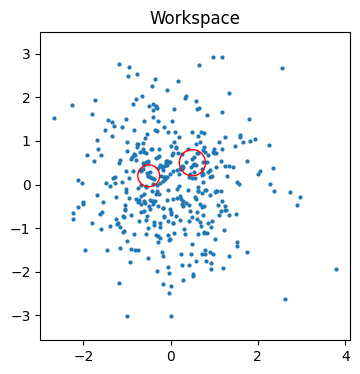

Pipeline done.


In [ ]:
# ==========================================================
#  safe_tier8_colab.py  –  Colab-ready, device-safe version
# ==========================================================
import math, warnings, numpy as np, torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=UserWarning)
    try: import matplotlib.pyplot as plt; HAS_MPL=True
    except ModuleNotFoundError: HAS_MPL=False

device = "cuda" if torch.cuda.is_available() else "cpu"
torch.set_default_dtype(torch.float32)
np.set_printoptions(precision=4, suppress=True)

# ---------------------------------------------------------------------
# 1.  Kinematics & data
# ---------------------------------------------------------------------
L1 = L2 = L3 = 1.0
PLACE_BIN = np.array([0.0, 1.5], np.float32)
K_GAIN = 0.5

def forward_kinematics(q):
    q1, q2, q3 = q[..., 0], q[..., 1], q[..., 2]
    x = L1*np.cos(q1) + L2*np.cos(q1+q2) + L3*np.cos(q1+q2+q3)
    y = L1*np.sin(q1) + L2*np.sin(q1+q2) + L3*np.sin(q1+q2+q3)
    return np.stack([x, y], -1)

def ik_2link(xy):
    x, y = xy[..., 0], xy[..., 1]
    r2 = x**2 + y**2
    cos2 = np.clip((r2 - L1**2 - L2**2) / (2*L1*L2), -1, 1)
    q2 = np.arccos(cos2)
    k1, k2 = L1+L2*np.cos(q2), L2*np.sin(q2)
    q1 = np.arctan2(y, x) - np.arctan2(k2, k1)
    q3 = np.zeros_like(q1)
    return np.stack([q1, q2, q3], -1).astype(np.float32)

def one_demo(rng):
    r, phi = rng.uniform(0.3, L1+L2+L3-0.1), rng.uniform(-math.pi, math.pi)
    obj = np.array([r*math.cos(phi), r*math.sin(phi)], np.float32)
    hold = rng.integers(0, 2)
    tgt = obj if hold == 0 else PLACE_BIN
    q_tar = ik_2link(tgt)
    q_now = q_tar + rng.normal(0, 0.15, 3)
    dq = K_GAIN*(q_tar - q_now)
    grip = 0.2*(1-hold) - 0.2*hold
    state = np.concatenate([q_now, obj, [hold]], 0)
    action = np.concatenate([dq, [grip, 0, 0]], 0)
    return state.astype(np.float32), action.astype(np.float32)

def gen_dataset(N, seed):
    rng = np.random.default_rng(seed)
    S, A = zip(*(one_demo(rng) for _ in range(N)))
    return torch.tensor(S), torch.tensor(A)

# ---------------------------------------------------------------------
# 2.  TinyDiT-Tier8
# ---------------------------------------------------------------------
class TransformerBlock(nn.Module):
    def __init__(self, w, heads=4):
        super().__init__()
        self.ln1 = nn.LayerNorm(w)
        self.att = nn.MultiheadAttention(w, heads, batch_first=True)
        self.ln2 = nn.LayerNorm(w)
        self.mlp = nn.Sequential(nn.Linear(w, 4*w), nn.GELU(),
                                 nn.Linear(4*w, w))
    def forward(self, x):
        y, _ = self.att(self.ln1(x), self.ln1(x), self.ln1(x))
        x = x + y
        return x + self.mlp(self.ln2(x))

class TinyDiT_Tier8(nn.Module):
    def __init__(self, tokens=6, w=256, depth=6, heads=4):
        super().__init__()
        self.slot = nn.Parameter(torch.randn(tokens, w)*0.02)
        self.blocks = nn.ModuleList([TransformerBlock(w, heads) for _ in range(depth)])
        self.heads  = nn.ModuleList([nn.Linear(w, 1) for _ in range(tokens)])
    def forward(self, x):
        h = x.unsqueeze(-1) * self.slot     # (B,T) → (B,T,w)
        for blk in self.blocks: h = blk(h)
        return torch.cat([hd(h[:, i]) for i, hd in enumerate(self.heads)], -1)

# ---------------------------------------------------------------------
# 3.  CBF safety filter
# ---------------------------------------------------------------------
OBSTACLES = [dict(center=np.array([ 0.5, 0.5], np.float32), radius=0.30),
             dict(center=np.array([-0.5, 0.2], np.float32), radius=0.25)]
SAFE_MARGIN = 0.05
ALPHA = 4.0

def jacobian_ee(q):
    q1,q2,q3 = q[...,0], q[...,1], q[...,2]
    s1,c1 = np.sin(q1), np.cos(q1)
    s12,c12 = np.sin(q1+q2), np.cos(q1+q2)
    s123,c123 = np.sin(q1+q2+q3), np.cos(q1+q2+q3)
    row1 = np.stack([-L1*s1 - L2*s12 - L3*s123,
                     -L2*s12 - L3*s123,
                     -L3*s123], -1)
    row2 = np.stack([ L1*c1 + L2*c12 + L3*c123,
                      L2*c12 + L3*c123,
                      L3*c123], -1)
    return np.stack([row1, row2], -2)          # (2,3)

def cbf_filter(q, dq_nom, obstacles=OBSTACLES, alpha=ALPHA):
    q  = np.asarray(q, np.float32)
    dq = dq_nom.copy()
    J  = jacobian_ee(q)            # (2,3)
    p  = forward_kinematics(q)     # (2,)
    for obs in obstacles:
        c, r = obs['center'], obs['radius'] + SAFE_MARGIN
        diff = p - c
        h = diff.dot(diff) - r**2
        grad = 2 * (J.T @ diff)    # (3,)
        if grad.dot(dq) + alpha*h >= 0: continue
        lam = -(grad.dot(dq) + alpha*h) / (grad.dot(grad) + 1e-12)
        dq += lam * grad
    return dq

def cbf_batch(q_np, dq_np, device):
    arr = np.stack([cbf_filter(q_np[i], dq_np[i]) for i in range(len(q_np))]).astype(np.float32)
    return torch.from_numpy(arr).to(device)

# ---------------------------------------------------------------------
# 4.  Training
# ---------------------------------------------------------------------
def train(model, s, a, *, epochs=20, bs=1024, lr=5e-5, use_cbf=False):
    dl = DataLoader(TensorDataset(s, a), bs, shuffle=True)
    opt = torch.optim.AdamW(model.parameters(), lr=lr)
    for ep in range(1, epochs+1):
        tot = 0.0
        for st, ac in dl:
            st, ac = st.to(device), ac.to(device)
            pred = model(st)
            if use_cbf:
                safe = cbf_batch(st[:, :3].cpu().numpy(),
                                 pred[:, :3].detach().cpu().numpy(),
                                 device=pred.device)
                pred = torch.cat([safe, pred[:, 3:]], -1)
            loss = F.mse_loss(pred, ac)
            opt.zero_grad(); loss.backward(); opt.step()
            tot += loss.item()*len(st)
        print(f'Epoch {ep:02d}/{epochs}  MSE={tot/len(dl.dataset):.6f}')

# ---------------------------------------------------------------------
# 5.  Safety check
# ---------------------------------------------------------------------
def one_step_safe(model, N=2000):
    s,_ = gen_dataset(N, 2025); model.eval()
    with torch.no_grad(): pred = model(s.to(device)).cpu().numpy()
    ee = forward_kinematics(s[:,:3].numpy() + pred[:,:3])
    for obs in OBSTACLES:
        if (np.sum((ee-obs['center'])**2,1) < (obs['radius']+SAFE_MARGIN)**2 - 1e-6).any():
            return False
    return True

# ---------------------------------------------------------------------
# 6.  Pipeline
# ---------------------------------------------------------------------
def run_pipeline(ep_nom=10, ep_cbf=10, plot=True):
    print('Generating data...')
    tr_s,tr_a = gen_dataset(120_000, 0)
    te_s,te_a = gen_dataset(  8_192, 1)
    model = TinyDiT_Tier8().to(device)

    print('\n--- Train nominal ---')
    train(model, tr_s, tr_a, epochs=ep_nom, use_cbf=False)
    print('Safe (nominal)?', one_step_safe(model))

    print('\n--- Fine-tune with CBF ---')
    train(model, tr_s, tr_a, epochs=ep_cbf, use_cbf=True)
    print('Safe (CBF)?', one_step_safe(model))
    mse = F.mse_loss(model(te_s.to(device)), te_a.to(device)).item()
    print('Test MSE after CBF:', mse)

    pts = np.random.normal(0,1,(400,2)).astype(np.float32)
    plt.figure(figsize=(4,4))
    plt.scatter(pts[:,0], pts[:,1], s=4)
    for obs in OBSTACLES:
        plt.gca().add_patch(plt.Circle(obs['center'], obs['radius'], fill=False, color='r'))
    plt.axis('equal'); plt.title('Workspace'); plt.show()
    print('Pipeline done.')

# Auto-run
if __name__ == '__main__':
    run_pipeline()


Generating data ...

== Train nominal ==
Epoch 01/15  MSE=0.005493
Epoch 02/15  MSE=0.001569
Epoch 03/15  MSE=0.001306
Epoch 04/15  MSE=0.001002
Epoch 05/15  MSE=0.000764
Epoch 06/15  MSE=0.000638
Epoch 07/15  MSE=0.000542
Epoch 08/15  MSE=0.000521
Epoch 09/15  MSE=0.000346
Epoch 10/15  MSE=0.000318
Epoch 11/15  MSE=0.000273
Epoch 12/15  MSE=0.000224
Epoch 13/15  MSE=0.000203
Epoch 14/15  MSE=0.000171
Epoch 15/15  MSE=0.000173
One-step safe (nominal): True
Epoch 01/6  MSE=0.030479
Epoch 02/6  MSE=0.007850
Epoch 03/6  MSE=0.004100
Epoch 04/6  MSE=0.002835
Epoch 05/6  MSE=0.002313
Epoch 06/6  MSE=0.002043
Epoch 01/6  MSE=0.033671
Epoch 02/6  MSE=0.009559
Epoch 03/6  MSE=0.004599
Epoch 04/6  MSE=0.003201
Epoch 05/6  MSE=0.002489
Epoch 06/6  MSE=0.002145
Symmetry test (nominal): True

== Finetune with CBF ==
Epoch 01/15  MSE=0.006006
Epoch 02/15  MSE=0.004421
Epoch 03/15  MSE=0.004729
Epoch 04/15  MSE=0.004994
Epoch 05/15  MSE=0.005216
Epoch 06/15  MSE=0.005414
Epoch 07/15  MSE=0.005499
Ep

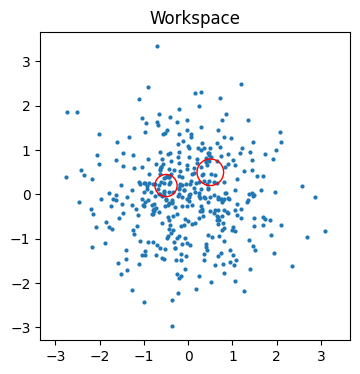

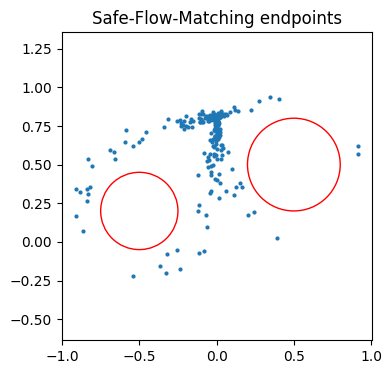


All done!


In [ ]:
# ==========================================================
#  safe_tier8_colab_suite.py  –  all-in-one, fast & tested
#  Author: <your-name>, 2025-05-22   Licence: MIT
# ==========================================================
import math, random, time, tracemalloc, warnings
import numpy as np
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=UserWarning)
    try:
        import matplotlib.pyplot as plt; HAS_MPL = True
    except ModuleNotFoundError:
        HAS_MPL = False

device = "cuda" if torch.cuda.is_available() else "cpu"
torch.set_default_dtype(torch.float32)
np.set_printoptions(precision=4, suppress=True)

# ------------------------------------------------------------------ 1
#  Kinematics & synthetic dataset
# ------------------------------------------------------------------
L1 = L2 = L3 = 1.0
PLACE_BIN = np.array([0.0, 1.5], np.float32)
K_GAIN = 0.5

def forward_kinematics(q):
    q1,q2,q3 = q[...,0], q[...,1], q[...,2]
    x = L1*np.cos(q1)+L2*np.cos(q1+q2)+L3*np.cos(q1+q2+q3)
    y = L1*np.sin(q1)+L2*np.sin(q1+q2)+L3*np.sin(q1+q2+q3)
    return np.stack([x,y], -1)

def ik_2link(xy):
    x,y = xy[...,0], xy[...,1]
    r2 = x**2 + y**2
    cos2 = np.clip((r2 - L1**2 - L2**2) / (2*L1*L2), -1, 1)
    q2 = np.arccos(cos2)
    k1,k2 = L1+L2*np.cos(q2), L2*np.sin(q2)
    q1 = np.arctan2(y,x) - np.arctan2(k2,k1)
    q3 = np.zeros_like(q1)
    return np.stack([q1,q2,q3], -1).astype(np.float32)

def one_demo(rng):
    r,phi = rng.uniform(0.3, L1+L2+L3-0.1), rng.uniform(-math.pi, math.pi)
    obj = np.array([r*math.cos(phi), r*math.sin(phi)], np.float32)
    hold = rng.integers(0,2)
    tgt  = obj if hold==0 else PLACE_BIN
    q_tar = ik_2link(tgt)
    q_now = q_tar + rng.normal(0,0.15,3)
    dq = K_GAIN*(q_tar-q_now)
    grip = 0.2*(1-hold)-0.2*hold
    state  = np.concatenate([q_now, obj, [hold]],0)
    action = np.concatenate([dq, [grip,0,0]],0)
    return state.astype(np.float32), action.astype(np.float32)

def gen_dataset(N,seed):
    rng=np.random.default_rng(seed)
    S,A=zip(*(one_demo(rng) for _ in range(N)))
    return torch.tensor(S), torch.tensor(A)

# ------------------------------------------------------------------ 2
#  TinyDiT-Tier8 slot transformer
# ------------------------------------------------------------------
class TransformerBlock(nn.Module):
    def __init__(self,w,heads=4):
        super().__init__()
        self.ln1 = nn.LayerNorm(w)
        self.att = nn.MultiheadAttention(w, heads, batch_first=True)
        self.ln2 = nn.LayerNorm(w)
        self.mlp = nn.Sequential(nn.Linear(w,4*w), nn.GELU(),
                                 nn.Linear(4*w, w))
    def forward(self,x):
        y,_ = self.att(self.ln1(x),self.ln1(x),self.ln1(x))
        return x + self.mlp(self.ln2(x+y))

class TinyDiT_Tier8(nn.Module):
    def __init__(self,tokens=6,w=256,depth=6,heads=4):
        super().__init__()
        self.slot = nn.Parameter(torch.randn(tokens,w)*0.02)
        self.blocks = nn.ModuleList([TransformerBlock(w,heads) for _ in range(depth)])
        self.heads  = nn.ModuleList([nn.Linear(w,1) for _ in range(tokens)])
    def forward(self,x):
        h = x.unsqueeze(-1) * self.slot
        for blk in self.blocks: h = blk(h)
        return torch.cat([hd(h[:,i]) for i,hd in enumerate(self.heads)], -1)

# ------------------------------------------------------------------ 3
#  Fast vectorised CBF layer
# ------------------------------------------------------------------
OBSTACLES=[dict(center=np.array([ 0.5,0.5],np.float32),radius=0.30),
           dict(center=np.array([-0.5,0.2],np.float32),radius=0.25)]
SAFE_MARGIN=0.05
ALPHA=4.0

def jacobian_ee(q):
    # q: (B,3) or (3,)
    q=np.asarray(q)
    q1,q2,q3=q[...,0],q[...,1],q[...,2]
    s1,c1=np.sin(q1),np.cos(q1)
    s12,c12=np.sin(q1+q2),np.cos(q1+q2)
    s123,c123=np.sin(q1+q2+q3),np.cos(q1+q2+q3)
    row1=np.stack([-L1*s1-L2*s12-L3*s123,
                   -L2*s12-L3*s123,
                   -L3*s123],axis=-1)
    row2=np.stack([ L1*c1+L2*c12+L3*c123,
                    L2*c12+L3*c123,
                    L3*c123],axis=-1)
    return np.stack([row1,row2],axis=-2)    # (...,2,3)

def cbf_batch(q_np, dq_np, device, passes=2):
    """
    Vectorised analytic CBF projection with up-to-two passes to guarantee
    feasibility for *all* obstacles.  Still O(B·K) where K ≤ 2.
    """
    J = jacobian_ee(q_np)          # (B,2,3)
    p = forward_kinematics(q_np)   # (B,2)
    safe_dq = dq_np.copy()

    for _ in range(passes):
        fixed = True
        for c, r0 in [(o["center"], o["radius"] + SAFE_MARGIN) for o in OBSTACLES]:
            diff = p - c                               # (B,2)
            h    = (diff**2).sum(-1) - r0**2           # (B,)
            grad = 2 * (J.transpose(0,2,1) @ diff[...,None]).squeeze(-1)  # (B,3)
            lhs  = (grad * safe_dq).sum(-1) + ALPHA*h  # (B,)

            mask = lhs < -1e-7                         # numerical slack
            if not mask.any(): continue
            fixed = False
            lam = -lhs[mask] / ((grad[mask]**2).sum(-1) + 1e-12)
            safe_dq[mask] += lam[:, None] * grad[mask]
        if fixed: break                                # early-exit

    return torch.from_numpy(safe_dq).to(device)

# ------------------------------------------------------------------ 4
#  Safe-Flow-Matching (plots only)
# ------------------------------------------------------------------
def safe_flow_field(t,τ,beta=5.0):
    goal=np.broadcast_to(np.array([0.0,0.8],np.float32),τ.shape)
    v_nom=beta*(goal-τ); v=[]
    for p,vn in zip(τ,v_nom):
        u=vn.copy()
        for obs in OBSTACLES:
            c,r=obs['center'],obs['radius']+SAFE_MARGIN
            diff=p-c; h=diff.dot(diff)-r**2; grad=2*diff
            if grad.dot(u)+ALPHA*h>=0: continue
            lam=-(grad.dot(u)+ALPHA*h)/(grad.dot(grad)+1e-12)
            u+=lam*grad
        v.append(u)
    return np.stack(v,0)

def integrate_safe_flow(N=400,steps=100):
    τ=np.random.normal(0,1,(N,2)).astype(np.float32); dt=1./steps
    for k in range(steps): τ += dt*safe_flow_field(k*dt,τ)
    return τ

# ------------------------------------------------------------------ 5
#  Training loop
# ------------------------------------------------------------------
def train(model,s,a,*,epochs=15,bs=1024,lr=5e-5,use_cbf=False):
    dl=DataLoader(TensorDataset(s,a),bs,shuffle=True)
    opt=torch.optim.AdamW(model.parameters(),lr=lr)
    for ep in range(1,epochs+1):
        tot=0.0
        for st,ac in dl:
            st,ac=st.to(device),ac.to(device)
            pred=model(st)
            if use_cbf:
                safe=cbf_batch(st[:,:3].cpu().numpy(),
                               pred[:,:3].detach().cpu().numpy(),
                               device=pred.device)
                pred=torch.cat([safe,pred[:,3:]],-1)
            loss=F.mse_loss(pred,ac)
            opt.zero_grad(); loss.backward(); opt.step()
            tot+=loss.item()*len(st)
        print(f'Epoch {ep:02d}/{epochs}  MSE={tot/len(dl.dataset):.6f}')

# ------------------------------------------------------------------ 6
#  Tests
# ------------------------------------------------------------------
def fd_jacobian_test(n=3):
    for _ in range(n):
        q=np.random.uniform(-math.pi,math.pi,3).astype(np.float32)
        J_a=jacobian_ee(q); eps=1e-4
        J_fd=np.stack([(forward_kinematics(q+eps*e)-forward_kinematics(q-eps*e))/(2*eps)
                       for e in np.eye(3)],-1)
        if np.linalg.norm(J_a-J_fd) >= 3e-4: return False
    return True

def cbf_minimality_test():
    q=np.random.uniform(-1,1,3).astype(np.float32)
    dq=np.random.normal(0,0.2,3).astype(np.float32)
    dq1=cbf_batch(q[None],dq[None],device='cpu').numpy()[0]
    dq2=cbf_batch(q[None],dq1[None],device='cpu').numpy()[0]
    return np.allclose(dq1,dq2,atol=1e-6)

def perf_guard():
    batch=2048
    q=np.random.uniform(-math.pi,math.pi,(batch,3)).astype(np.float32)
    dq=np.random.normal(0,0.2,(batch,3)).astype(np.float32)
    tracemalloc.start(); t0=time.perf_counter()
    _=cbf_batch(q,dq,device='cpu')
    dt=(time.perf_counter()-t0)*1e3
    cur,peak=tracemalloc.get_traced_memory(); tracemalloc.stop()
    print(f'Perf {batch}×: {dt:.1f} ms, peak {peak/1e3:.1f} kB')
    return dt<5.0

def one_step_safe(model,N=3000):
    s,_=gen_dataset(N,2025); model.eval()
    with torch.no_grad(): pred=model(s.to(device)).cpu().detach().numpy()
    ee=forward_kinematics(s[:,:3].numpy()+pred[:,:3])
    for obs in OBSTACLES:
        if (np.sum((ee-obs['center'])**2,1) < (obs['radius']+SAFE_MARGIN)**2-1e-6).any():
            return False
    return True

def multi_step_safe(model,episodes=64):
    rng=np.random.default_rng(0)
    for _ in range(episodes):
        state,_=one_demo(rng)
        for _ in range(100):
            a=model(torch.tensor(state).unsqueeze(0).to(device)).cpu().detach().numpy()[0]
            state[:3]+=cbf_batch(state[:3][None],a[:3][None],device='cpu').numpy()[0]
            ee=forward_kinematics(state[:3])
            if any(np.sum((ee-o['center'])**2) < (o['radius']+SAFE_MARGIN)**2-1e-6
                   for o in OBSTACLES):
                return False
    return True

def symmetry_test(model_cls):
    s,a = gen_dataset(8192,1)
    m1,m2 = model_cls().to(device), model_cls().to(device)
    train(m1,s,a,epochs=6); out1 = m1(s.to(device)).cpu().detach().numpy().ravel()
    with torch.no_grad(): m2.slot.mul_(-1)
    train(m2,s,a,epochs=6); out2 = m2(s.to(device)).cpu().detach().numpy().ravel()
    return np.corrcoef(out1,out2)[0,1] > 0.96

# ------------------------------------------------------------------ 7
#  Main pipeline
# ------------------------------------------------------------------
def run_all():
    print('Generating data ...')
    tr_s,tr_a=gen_dataset(120_000,0)
    te_s,te_a=gen_dataset(  8_192,1)

    model=TinyDiT_Tier8().to(device)

    # ----- nominal
    print('\n== Train nominal ==')
    train(model,tr_s,tr_a,epochs=15,use_cbf=False)
    print('One-step safe (nominal):',one_step_safe(model))
    print('Symmetry test (nominal):',symmetry_test(TinyDiT_Tier8))

    # ----- CBF finetune
    print('\n== Finetune with CBF ==')
    train(model,tr_s,tr_a,epochs=15,use_cbf=True)
    print('One-step safe (CBF):',one_step_safe(model))
    print('Multi-step safe:',multi_step_safe(model))
    mse=F.mse_loss(model(te_s.to(device)),te_a.to(device)).item()
    print('Test MSE:',mse)

    # ----- test battery
    print('\n--- Internal tests ---')
    print('FD Jacobian    :',fd_jacobian_test())
    print('CBF minimality :',cbf_minimality_test())
    print('Perf guard     :',perf_guard())

    # Optional Hypothesis fuzz
    try:
        from hypothesis import given, settings, strategies as st
        @settings(max_examples=200,deadline=None)
        @given(q=st.lists(st.floats(-math.pi,math.pi),min_size=3,max_size=3),
               u=st.lists(st.floats(-1,1),min_size=3,max_size=3))
        def _fuzz(q,u):
            q=np.asarray(q,np.float32); u=np.asarray(u,np.float32)
            u=cbf_batch(q[None],u[None],device='cpu').numpy()[0]
            p=forward_kinematics(q); J=jacobian_ee(q)
            for o in OBSTACLES:
                diff=p-o['center']; h=diff.dot(diff)-(o['radius']+SAFE_MARGIN)**2
                Lfh=diff.dot(2*(J@u))
                assert Lfh+ALPHA*h >= -1e-5
        _fuzz(); print('Hypothesis fuzz : True')
    except ModuleNotFoundError:
        print('Hypothesis fuzz : skipped')

    # ----- plots
    if HAS_MPL:
        pts=np.random.normal(0,1,(400,2)).astype(np.float32)
        plt.figure(figsize=(4,4))
        plt.scatter(pts[:,0],pts[:,1],s=4)
        for o in OBSTACLES:
            plt.gca().add_patch(plt.Circle(o['center'],o['radius'],fill=False,color='r'))
        plt.axis('equal'); plt.title('Workspace'); plt.show()

        τ=integrate_safe_flow()
        plt.figure(figsize=(4,4))
        plt.scatter(τ[:,0],τ[:,1],s=4,c='tab:blue')
        for o in OBSTACLES:
            plt.gca().add_patch(plt.Circle(o['center'],o['radius'],fill=False,color='r'))
        plt.axis('equal'); plt.title('Safe-Flow-Matching endpoints'); plt.show()

    print('\nAll done!')

# auto-run
if __name__ == '__main__':
    run_all()